In [1]:
import sys
#sys.path.insert(0,'/eos/home-a/antoniov/SWAN_projects/env/uproot4/lib/python3.7/site-packages')
sys.path.insert(0,'/eos/home-a/antoniov/SWAN_projects/env/uproot/lib/python3.8/site-packages')
print ( sys.path )

import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import mplhep
from matplotlib.colors import LogNorm
from joblib import dump, load
plt.style.use(mplhep.style.CMS)

['/eos/home-a/antoniov/SWAN_projects/env/uproot/lib/python3.8/site-packages', '/cvmfs/sft.cern.ch/lcg/views/LCG_99/x86_64-centos7-gcc8-opt/python', '/cvmfs/sft.cern.ch/lcg/views/LCG_99/x86_64-centos7-gcc8-opt/lib', '', '/cvmfs/sft.cern.ch/lcg/views/LCG_99/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.8.6-3199b/x86_64-centos7-gcc8-opt/lib/python38.zip', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.8.6-3199b/x86_64-centos7-gcc8-opt/lib/python3.8', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.8.6-3199b/x86_64-centos7-gcc8-opt/lib/python3.8/lib-dynload', '/eos/home-a/antoniov/SWAN_projects/env/uproot/lib/python3.8/site-packages', '/cvmfs/sft.cern.ch/lcg/views/LCG_99/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/IPython/extensions', '/scratch/antoniov/.ipython']


In [2]:
# run_ranges_periods, df_run_ranges, fiducial_cuts, fiducial_cuts_all, aperture_period_map, aperture_parametrisation, check_aperture, get_data, process_data_protons_multiRP
from processing import *

save_figures = False

# test_sample_ratio = 0.40

run_tables = False

Welcome to JupyROOT 6.22/06
{'2017B': 2.360904801, '2017C1': 5.313012839, '2017C2': 3.264135878, '2017D': 4.074723964, '2017E': 8.958810514, '2017F1': 1.708478656, '2017F2': 7.877903151, '2017F3': 3.632463163}
Luminosity: 37.190432966


### Event selection

In [3]:
def select_events( df_events, label_jet=None, label_muon=None ):
#     label_jet_ = "_nom"
#     label_muon_ = "_nom"
#     label_WLep_ = "_nom"
#     label_WW_ = "_nom"
    label_jet_ = "_nom"
    if label_jet is not None: label_jet_ = label_jet
    label_muon_ = "_nom"
    if label_muon is not None: label_muon_ = label_muon
    label_WLep_ = "_nom"
    if label_muon is not None:
        label_WLep_ = label_muon
    label_WW_ = "_nom"
    if label_jet is not None:
        label_WW_ = label_jet
    elif label_muon is not None:
        label_WW_ = label_muon
    label_xiCMS_ = "_nom"
    if label_jet is not None:
        label_xiCMS_ = label_jet
    elif label_muon is not None:
        label_xiCMS_ = label_muon
        
    deltaPhi_jet_muon_ = ( df_events.loc[ :, "jet0_phi"] - df_events.loc[ :, "muon0_phi"] )
    msk_dphi_ = ( deltaPhi_jet_muon_ < -np.pi )
    deltaPhi_jet_muon_.loc[ msk_dphi_ ] = deltaPhi_jet_muon_.loc[ msk_dphi_ ] + 2*np.pi
    msk_dphi_ = ( deltaPhi_jet_muon_ >= np.pi )
    deltaPhi_jet_muon_.loc[ msk_dphi_ ] = deltaPhi_jet_muon_.loc[ msk_dphi_ ] - 2*np.pi
    
    deltaEta_jet_muon_ = ( df_events.loc[ :, "jet0_eta"] - df_events.loc[ :, "muon0_eta"] )
    deltaR_jet_muon_ = np.sqrt( ( deltaPhi_jet_muon_ ) ** 2 + ( deltaEta_jet_muon_ ) ** 2 )
    
    deltaPhi_jet_met_ = ( df_events.loc[ :, "jet0_phi"] - df_events.loc[ :, "met_phi"] )
    msk_dphi_ = ( deltaPhi_jet_met_ < -np.pi )
    deltaPhi_jet_met_.loc[ msk_dphi_ ] = deltaPhi_jet_met_.loc[ msk_dphi_ ] + 2*np.pi
    msk_dphi_ = ( deltaPhi_jet_met_ >= np.pi )
    deltaPhi_jet_met_.loc[ msk_dphi_ ] = deltaPhi_jet_met_.loc[ msk_dphi_ ] - 2*np.pi
    
    deltaPhi_jet_Wlep_ = ( df_events.loc[ :, "jet0_phi"] - df_events.loc[ :, "WLeptonicPhi"] )
    msk_dphi_ = ( deltaPhi_jet_Wlep_ < -np.pi )
    deltaPhi_jet_Wlep_.loc[ msk_dphi_ ] = deltaPhi_jet_Wlep_.loc[ msk_dphi_ ] + 2*np.pi
    msk_dphi_ = ( deltaPhi_jet_Wlep_ >= np.pi )
    deltaPhi_jet_Wlep_.loc[ msk_dphi_ ] = deltaPhi_jet_Wlep_.loc[ msk_dphi_ ] - 2*np.pi

    jet0_tau21_ = ( df_events.loc[ :, "jet0_tau2"] / df_events.loc[ :, "jet0_tau1"] )

    msk_All_ = np.full( df_events.shape[0], True, dtype=bool )
    msk_muon_ = ( ( df_events.loc[ :, "muon0_pt" + label_muon_ ] >= 50.0 ) &
                  ( np.abs( df_events.loc[ :, "muon0_eta"] ) <= 2.4 ) & 
                  ( df_events.loc[ :, "muon0_iso"] <= 0.10 ) )
#     msk_jet_ = ( ( df_events.loc[ :, "jet0_pt" + label_jet_] >= 200.0 ) &
#                  ( np.abs( df_events.loc[ :, "jet0_eta"] ) <= 2.4 ) )
    msk_jet_ = ( ( df_events.loc[ :, "jet0_pt" + label_jet_] >= 220.0 ) &
                 ( np.abs( df_events.loc[ :, "jet0_eta"] ) <= 2.4 ) )
    msk_jet_muon_ = ( deltaR_jet_muon_ >= np.pi/2 )
    msk_met_ = ( df_events.loc[ :, "met"] >= 40.0 )
    msk_jet_met_ = ( np.abs( deltaPhi_jet_met_ ) >= 2.0 )
    msk_pruned_mass_ = ( ( df_events.loc[ :, "jet0_corrmass" + label_jet_] >= 50.0 ) &
                         ( df_events.loc[ :, "jet0_corrmass" + label_jet_] <= 110.0 ) )
    msk_tau21_       = ( jet0_tau21_ <= 0.60 )
    msk_bjet_veto_   = ( df_events.loc[ :, "num_bjets_ak4"] == 0 )
#     msk_xiCMS_ = msk_All_.copy()
    msk_xiCMS_       = ( ( df_events.loc[ :, "xiCMS_45" + label_xiCMS_ ] <= 0.20 ) & ( df_events.loc[ :, "xiCMS_56" + label_xiCMS_ ] <= 0.20 ) )
    msk_Wlep_ = ( df_events.loc[ :, "WLeptonicPt" + label_WLep_ ] >= 200.0 )
    msk_jet_Wlep_ = ( np.abs( deltaPhi_jet_Wlep_ ) >= 2.5 )
#     msk_MWW_ = ( df_events.loc[ :, "recoMWW"] >= 500.0 )
    msk_MWW_ = ( df_events.loc[ :, "MWW" + label_WW_ ] >= 500.0 )
    msk_extra_tracks_ = ( df_events.loc[ :, "pfcand_nextracks" ] <= 4 )
#     msk_extra_tracks_ = ( df_events.loc[ :, "pfcand_nextracks" ] <= 999 )
    
    masks_ = [ msk_All_, msk_muon_, msk_jet_, msk_jet_muon_, msk_met_, msk_jet_met_,
               msk_pruned_mass_, msk_tau21_, msk_bjet_veto_, msk_xiCMS_,
               msk_Wlep_, msk_jet_Wlep_, msk_MWW_, msk_extra_tracks_ ]
    selection_keys_ = [ "All", "Muon", "Jet", "Jet_Muon", "MET", "Jet_MET",
                        "PrunedMass", "Tau21", "BJet_Veto", "Xi_CMS",
                        "WLeptonic", "Jet_WLeptonic", "MWW", "ExtraTracks" ]
    selections_ = {}
    msk_ = masks_[ 0 ].copy()
    for idx_, key_ in enumerate( selection_keys_ ):
        msk_ = msk_ & masks_[ idx_ ]
        selections_[ key_ ] = np.sum( msk_ )
        
    df_events = df_events.loc[ msk_ ]
    
    return df_events, selection_keys_, selections_

### Signal

In [4]:
run_tables = False

#label = "GGToWW-AQGC-test-A0W1e-6"
#label = "GGToWW-AQGC-test-A0W2e-6"
#label = "GGToWW-AQGC-test-A0W5e-6"
labels_signals = [ "GGToWW-AQGC-A0W1e-6", "GGToWW-AQGC-A0W2e-6", "GGToWW-AQGC-A0W5e-6" ]

# fileNames_signal = [
#     #"output-GGToWW-AQGC-test-A0W1e-6.h5"
#     #"output-GGToWW-AQGC-test-A0W2e-6.h5"
#     "output-GGToWW-AQGC-test-A0W5e-6.h5"
# ]
fileNames_signals = {
    "GGToWW-AQGC-A0W1e-6": [ "output-GGToWW-AQGC-A0W1e-6.h5" ],
    "GGToWW-AQGC-A0W2e-6": [ "output-GGToWW-AQGC-A0W2e-6.h5" ],
    "GGToWW-AQGC-A0W5e-6": [ "output-GGToWW-AQGC-A0W5e-6.h5" ]
    }

df_counts_signals = {}
df_signals_protons_multiRP_index = {}
df_signals_protons_multiRP_events = {}

for label_ in labels_signals:
    import time
    print( time.strftime("%Y/%m/%d %H:%M:%S", time.localtime() ) )
    time_s_ = time.time()

    #df_counts_signal, df_protons_multiRP_signal, df_protons_singleRP_signal, df_ppstracks_signal = 4 * [None]
    #df_protons_multiRP_signal_index, df_protons_multiRP_signal_events, df_ppstracks_signal_index = 3 * [None]

    if run_tables:
        with pd.HDFStore( "reduced-data-store-{}.h5".format( label_ ), complevel=5 ) as store_:

            df_counts_signal_, df_protons_multiRP_signal_, df_protons_singleRP_signal_, df_ppstracks_signal_ = get_data( fileNames_signals[ label_ ] )
            df_protons_multiRP_signal_index_, df_protons_multiRP_signal_events_, df_ppstracks_signal_index_ = process_data_protons_multiRP( df_protons_multiRP_signal_, df_ppstracks_signal_, apply_fiducial=True, within_aperture=True, select_2protons=False, runOnMC=True )

            store_[ "counts" ] = df_counts_signal_
            store_[ "protons_multiRP"] = df_protons_multiRP_signal_index_
            store_[ "events_multiRP" ] = df_protons_multiRP_signal_events_
    
    with pd.HDFStore( "reduced-data-store-{}.h5".format( label_ ), 'r' ) as store_:
        df_counts_signals[ label_ ] = store_[ "counts" ]
        df_signals_protons_multiRP_index[ label_ ] = store_[ "protons_multiRP" ]
        df_signals_protons_multiRP_events[ label_ ] = store_[ "events_multiRP" ]

    time_e_ = time.time()
    print ( "Total time elapsed: {:.0f}".format( time_e_ - time_s_ ) )

2021/05/14 22:48:03
Total time elapsed: 0
2021/05/14 22:48:03
Total time elapsed: 0
2021/05/14 22:48:04
Total time elapsed: 1


In [5]:
label_ = "GGToWW-AQGC-A0W1e-6"
columns_protons_multiRP =  df_signals_protons_multiRP_index[ label_ ].columns.values
print ( columns_protons_multiRP )
# df_signals_protons_multiRP_index[ label_ ]
df_signals_protons_multiRP_index[ label_ ][ [ 'run_mc', 'crossingAngle', 'period', 'within_aperture' ] ]

['crossingAngle' 'xi' 'thx' 'thy' 't' 'ismultirp' 'rpid' 'arm' 'random'
 'jet0_pt' 'jet0_eta' 'jet0_phi' 'jet0_energy' 'jet0_mass' 'jet0_corrmass'
 'jet0_tau1' 'jet0_tau2' 'jet0_vertexz' 'muon0_pt' 'muon0_eta' 'muon0_phi'
 'muon0_energy' 'muon0_charge' 'muon0_iso' 'muon0_dxy' 'muon0_dz' 'met'
 'met_x' 'met_y' 'met_phi' 'nVertices' 'num_bjets_ak8' 'num_bjets_ak4'
 'num_jets_ak4' 'pfcand_nextracks' 'pfcand_nextracks_noDRl' 'recoMWhad'
 'recoMWlep' 'recoMWW' 'recoRapidityWW' 'dphiWW' 'WLeptonicPt'
 'WLeptonicEta' 'WLeptonicPhi' 'pileupWeight' 'mc_pu_trueinteractions'
 'mcWeight' 'run_mc' 'jet0_jer_res' 'jet0_jer_sf' 'jet0_jer_sfup'
 'jet0_jer_sfdown' 'trackx1' 'tracky1' 'trackpixshift1' 'rpid1' 'trackx2'
 'tracky2' 'trackpixshift2' 'rpid2' 'period' 'jet0_unc' 'jet0_pt_nom'
 'jet0_energy_nom' 'jet0_mass_nom' 'jet0_corrmass_nom' 'jet0_px_nom'
 'jet0_py_nom' 'jet0_pz_nom' 'jet0_pt_jes_up' 'jet0_energy_jes_up'
 'jet0_mass_jes_up' 'jet0_corrmass_jes_up' 'jet0_px_jes_up'
 'jet0_py_jes_up' 'jet0

run_mc  crossingAngle  period  within_aperture
run lumiblock event  slice                                                
1   2266      226549 0      302030          120.0   2017D             True
              226551 0      305965          120.0  2017F3             True
                     0      305965          120.0  2017F3             True
    2267      226605 0      305178          120.0  2017F2             True
              226690 0      299337          120.0  2017C1             True
    2268      226716 0      305178          150.0  2017F2             True
              226773 0      303435          150.0   2017E             True
    2270      226932 0      297020          130.0   2017B             True
                     0      297020          130.0   2017B             True
    2273      227227 0      305178          130.0  2017F2             True
                     0      305178          130.0  2017F2             True
    2274      227321 0      299337          150.0  2017C1             True
              227328 0      299337          150.0  2017C1             True
              227324 0      303435          150.0   2017E             True
    2275      227457 0      303435          150.0   2017E             True
                     0      303435          150.0   2017E             True
    2276      227546 0      300806          140.0  2017C2             True
                     0      300806          140.0  2017C2             True
              227579 0      303435          140.0   2017E             True
                     0      303435          140.0   2017E             True
    2277      227611 0      299337          130.0  2017C1             True
              227610 0      300806          130.0  2017C2             True
              227661 0      302030          130.0   2017D             True
    2278      227745 0      303435          150.0   2017E             True
    2279      227825 0      299337          130.0  2017C1             True
              227868 0      303435          130.0   2017E             True
    2280      227969 0      303435          120.0   2017E             True
    2282      228117 0      299337          130.0  2017C1             True
                     0      299337          130.0  2017C1             True
              228121 0      299337          130.0  2017C1             True
...                            ...            ...     ...              ...
    9019      401833 0      303435          130.0   2017E             True
              401874 0      299337          130.0  2017C1             True
                     0      299337          130.0  2017C1             True
    9021      402066 0      303435          119.0   2017E             True
                     0      303435          119.0   2017E             True
              402070 0      303435          119.0   2017E             True
              402092 0      303435          119.0   2017E             True
    9024      402306 0      305965          150.0  2017F3             True
              402311 0      302030          150.0   2017D             True
              402331 0      305178          150.0  2017F2             True
              402381 0      302030          150.0   2017D             True
    9026      402504 0      303435          150.0   2017E             True
    9039      403821 0      302030          130.0   2017D             True
    9041      404017 0      297020          130.0   2017B             True
              404092 0      302030          130.0   2017D             True
              404091 0      305178          130.0  2017F2             True
    9042      404200 0      303435          140.0   2017E             True
    9043      404249 0      305178          140.0  2017F2             True
    9049      404804 0      305178          120.0  2017F2             True
              404867 0      299337          120.0  2017C1             True
              404859 0      305178          120.0  20

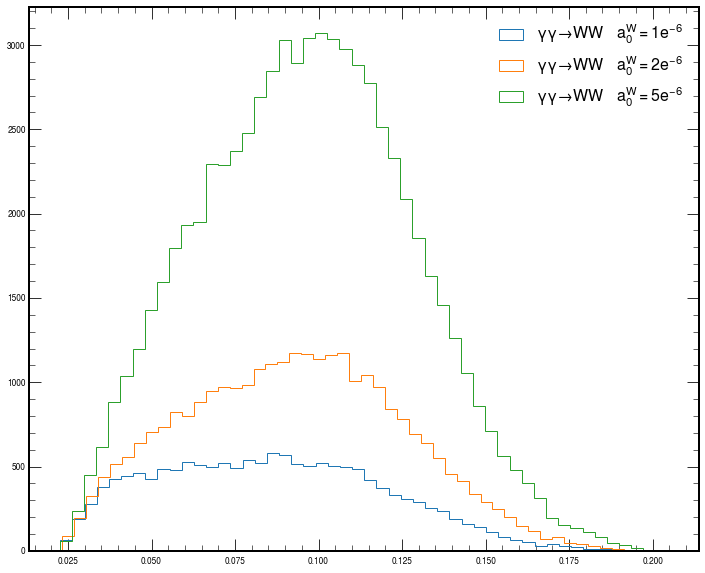

In [6]:
labels_samples = {
    "GGToWW-AQGC-A0W1e-6": r"$\gamma\gamma \to WW \quad a_0^W=1e^{-6}$",
    "GGToWW-AQGC-A0W2e-6": r"$\gamma\gamma \to WW \quad a_0^W=2e^{-6}$",
    "GGToWW-AQGC-A0W5e-6": r"$\gamma\gamma \to WW \quad a_0^W=5e^{-6}$"
}

fig = plt.figure( figsize=(12,10) )
for label_ in labels_signals: 
    plt.hist( df_signals_protons_multiRP_index[ label_ ][ 'xi' ], histtype='step', density=False, bins=50, label=labels_samples[ label_ ] )
plt.legend( loc='best', fontsize=16 )

### Ouf of acceptance protons

In [7]:
# df_signals_protons_multiRP_index_2protons = {}
# df_signals_protons_multiRP_index_1proton_Arm0 = {}
# df_signals_protons_multiRP_index_1proton_Arm1 = {}
# for label_ in labels_signals:
#     print ( label_ )
#     df_protons_multiRP_groupby_arm_ = df_signals_protons_multiRP_index[ label_ ][ [ "arm" ] ].groupby( ["run","lumiblock","event","slice"] )
#     msk_2protons_ = df_protons_multiRP_groupby_arm_[ "arm" ].transform( lambda s_: ( np.sum( s_ == 0 ) >= 1 ) & ( np.sum( s_ == 1 ) >= 1 ) )
#     msk_1proton_Arm0_ = df_protons_multiRP_groupby_arm_[ "arm" ].transform( lambda s_: ( np.sum( s_ == 0 ) >= 1 ) & ( np.sum( s_ == 1 ) == 0 ) )
#     msk_1proton_Arm1_ = df_protons_multiRP_groupby_arm_[ "arm" ].transform( lambda s_: ( np.sum( s_ == 0 ) == 0 ) & ( np.sum( s_ == 1 ) >= 1 ) )
#     print ( msk_2protons_ )
#     print ( msk_1proton_Arm0_ )
#     print ( msk_1proton_Arm1_ )
#     df_signals_protons_multiRP_index_2protons[ label_ ] = df_signals_protons_multiRP_index[ label_ ].loc[ msk_2protons_ ]
#     df_signals_protons_multiRP_index_1proton_Arm0[ label_ ] = df_signals_protons_multiRP_index[ label_ ].loc[ msk_1proton_Arm0_ ]
#     df_signals_protons_multiRP_index_1proton_Arm1[ label_ ] = df_signals_protons_multiRP_index[ label_ ].loc[ msk_1proton_Arm1_ ]

In [8]:
# label_ = "GGToWW-AQGC-A0W1e-6"
# df_signals_protons_multiRP_index_2protons[ label_ ]

In [9]:
# df_signals_protons_multiRP_index_1proton_Arm0[ label_ ]

In [10]:
# df_signals_protons_multiRP_index_1proton_Arm1[ label_ ]

In [11]:
# df_signals_protons_multiRP_index_ = df_signals_protons_multiRP_index_2protons
# # df_signals_protons_multiRP_index_ = df_signals_protons_multiRP_index_1proton_Arm0
# # df_signals_protons_multiRP_index_ = df_signals_protons_multiRP_index_1proton_Arm1
# fig = plt.figure( figsize=(12,10) )
# for label_ in labels_signals: 
#     plt.hist( df_signals_protons_multiRP_index_[ label_ ][ 'xi' ], histtype='step', density=False, bins=50, label=labels_samples[ label_ ] )
# plt.legend( loc='best', fontsize=16 )

### Signal with mixed protons

In [12]:
run_tables = False

# labels_signals_mix_protons = [ "GGToWW-AQGC-mix_protons-A0W1e-6" ]
labels_signals_mix_protons = [ "GGToWW-AQGC-mix_protons-A0W1e-6", "GGToWW-AQGC-mix_protons-A0W2e-6", "GGToWW-AQGC-mix_protons-A0W5e-6" ]

fileNames_signals = {
    "GGToWW-AQGC-mix_protons-A0W1e-6": [ "output-GGToWW-AQGC-mix_protons-A0W1e-6.h5" ],
    "GGToWW-AQGC-mix_protons-A0W2e-6": [ "output-GGToWW-AQGC-mix_protons-A0W2e-6.h5" ],
    "GGToWW-AQGC-mix_protons-A0W5e-6": [ "output-GGToWW-AQGC-mix_protons-A0W5e-6.h5" ]
    }

df_counts_signals_mix_protons = {}
df_signals_protons_multiRP_mix_protons_index = {}
df_signals_protons_multiRP_mix_protons_events = {}

for label_ in labels_signals_mix_protons:
    import time
    print( time.strftime("%Y/%m/%d %H:%M:%S", time.localtime() ) )
    time_s_ = time.time()

    #df_counts_signal, df_protons_multiRP_signal, df_protons_singleRP_signal, df_ppstracks_signal = 4 * [None]
    #df_protons_multiRP_signal_index, df_protons_multiRP_signal_events, df_ppstracks_signal_index = 3 * [None]

    if run_tables:
        with pd.HDFStore( "reduced-data-store-{}.h5".format( label_ ), complevel=5 ) as store_:

            df_counts_signal_, df_protons_multiRP_signal_, df_protons_singleRP_signal_, df_ppstracks_signal_ = get_data( fileNames_signals[ label_ ] )
            df_protons_multiRP_signal_index_, df_protons_multiRP_signal_events_, df_ppstracks_signal_index_ = process_data_protons_multiRP( df_protons_multiRP_signal_, df_ppstracks_signal_, apply_fiducial=True, within_aperture=True, mix_protons=True, select_2protons=False, runOnMC=True )

            store_[ "counts" ] = df_counts_signal_
            store_[ "protons_multiRP"] = df_protons_multiRP_signal_index_
            store_[ "events_multiRP" ] = df_protons_multiRP_signal_events_
    
    with pd.HDFStore( "reduced-data-store-{}.h5".format( label_ ), 'r' ) as store_:
        df_counts_signals_mix_protons[ label_ ] = store_[ "counts" ]
        df_signals_protons_multiRP_mix_protons_index[ label_ ] = store_[ "protons_multiRP" ]
        df_signals_protons_multiRP_mix_protons_events[ label_ ] = store_[ "events_multiRP" ]

    time_e_ = time.time()
    print ( "Total time elapsed: {:.0f}".format( time_e_ - time_s_ ) )

2021/05/14 22:48:07
Total time elapsed: 0
2021/05/14 22:48:07
Total time elapsed: 0
2021/05/14 22:48:07
Total time elapsed: 0


In [13]:
label_signal_to_mix_protons = {
     "GGToWW-AQGC-A0W1e-6" : "GGToWW-AQGC-mix_protons-A0W1e-6",
     "GGToWW-AQGC-A0W2e-6" : "GGToWW-AQGC-mix_protons-A0W2e-6",
     "GGToWW-AQGC-A0W5e-6" : "GGToWW-AQGC-mix_protons-A0W5e-6"
}

In [14]:
label_ = "GGToWW-AQGC-A0W1e-6"
df_signals_protons_multiRP_mix_protons_index[ label_signal_to_mix_protons[ label_ ] ]

crossingAngle        xi           thx  \
run lumiblock event  slice                                          
1   2281      228042 0              130.0  0.040710 -1.339373e-05   
                     0              130.0  0.111005 -5.641787e-05   
    2344      234363 0              130.0  0.079774  5.526187e-05   
    4028      402796 0              120.0  0.055434  2.889099e-05   
    4033      403213 0              130.0  0.078802  1.036883e-04   
                     0              130.0  0.105974  5.218447e-05   
    4054      405396 0              150.0  0.077543  6.661195e-05   
    3867      386602 0              140.0  0.076253  8.043599e-05   
    3869      386835 0              140.0  0.110243  5.802389e-06   
    9617      461657 0              150.0  0.058753 -6.249669e-05   
    9624      462379 0              150.0  0.102959 -6.224281e-05   
                     0              150.0  0.090283 -6.088307e-05   
    245       24452  0              150.0  0.060379 -1.941511e-05   
    262       26119  0              150.0  0.098973 -3.174151e-05   
    266       26542  0              120.0  0.053062  9.638428e-05   
    7753      275282 0              150.0  0.095906  9.467000e-06   
    696       69578  0              140.0  0.120754 -9.438089e-05   
                     0              140.0  0.087492 -4.261828e-05   
    1389      138834 0              150.0  0.105080 -8.977557e-05   
    1409      140855 0              130.0  0.075610  9.029261e-06   
    1411      141005 0              150.0  0.054790  5.034913e-06   
    1423      142299 0              150.0  0.118777  8.795727e-05   
    1197      119682 0              140.0  0.043646 -8.447393e-05   
    1237      123633 0              140.0  0.059685  3.656131e-05   
                     0              140.0  0.071542 -1.464423e-05   
    1252      125192 0              130.0  0.063007 -1.922706e-05   
                     0              130.0  0.054396 -8.753509e-05   
    1269      126841 0              120.0  0.086898 -1.266863e-05   
    3559      355893 0              150.0  0.108162 -2.248296e-05   
                     0              150.0  0.114230  4.034511e-05   
...                                   ...       ...           ...   
    6112      111189 0              140.0  0.073071 -3.144582e-05   
    2527      252637 0              150.0  0.076149  2.273445e-04   
    8994      399346 0              130.0  0.040112 -4.912430e-05   
    9078      407790 0              130.0  0.104992  2.666693e-05   
    6192      119191 0              120.0  0.195953 -1.256231e-04   
    6196      119548 0              120.0  0.041619  2.534363e-05   
    5754      75341  0              120.0  0.121904 -2.305167e-06   
    5792      79158  0              130.0  0.068797  3.119822e-05   
    2416      241573 0              120.0  0.042415  4.396395e-05   
                     0              120.0  0.105568 -5.351061e-05   
    2420      241921 0              120.0  0.110685  1.931770e-05   
    6524      152372 0              130.0  0.091100  1.185909e-04   
    6455      145454 0              150.0  0.128582  1.120558e-04   
    2472      247120 0              140.0  0.091241 -2.579187e-05   
    2474      247304 0              150.0  0.054778 -1.668333e-05   
    2511      251017 0              130.0  0.106020  5.678445e-05   
              251046 0              130.0  0.067406 -1.873872e-08   
    2521      252099 0              150.0  0.064491  4.320837e-05   
    6511      151095 0              150.0  0.070216  4.609366e-05   
    9044      404341 0              150.0  0.077421 -2.119775e-05   
    9061      406041 0              130.0  0.078630  4.252567e-05   
    6237      123624 0              130.0  0.059935  4.666689e-05   
    6239      123873 0              150.0  0.072152  4.951709e-05   
    6246      124590 0              140.0  0.107533  4.653825e-06   
    6254      125328 0              150.0  0.107334  6.260812e-05   
    6469      146827 0    

In [15]:
df_signals_protons_multiRP_mix_protons_events[ label_signal_to_mix_protons[ label_ ] ]

crossingAngle      jet0_pt  jet0_eta  jet0_phi  \
run lumiblock event  slice                                                   
1   2281      228042 0              130.0   764.408875 -0.631614  2.295349   
    4033      403213 0              130.0   250.947861  0.128243  1.978071   
    9624      462379 0              150.0   287.563263 -0.364587 -2.391431   
    696       69578  0              140.0   867.484314  0.548762 -1.836543   
    1237      123633 0              140.0   794.222534 -0.058519  2.119824   
    1252      125192 0              130.0   205.362976  2.249958 -0.550643   
    3559      355893 0              150.0   603.510376 -0.003504  1.562817   
    6893      189216 0              130.0   792.713318 -0.094334 -1.142382   
    6909      190881 0              130.0   496.519501  1.384274  2.032141   
    7884      288313 0              150.0   686.641846  1.105320 -0.941765   
    2218      221747 0              120.0   734.225098  0.576510 -2.743683   
    6764      176363 0              140.0   345.501678  0.051643  0.227905   
    7560      255990 0              150.0   294.695953 -0.822461 -0.470896   
    9915      491493 0              150.0   883.375549  0.379353 -0.653762   
    9205      420500 0              150.0   469.014801 -1.331586  1.603894   
    2904      290308 0              130.0   481.319824  1.428924 -1.153020   
    5616      61559  0              130.0   691.752563  0.562015  2.163461   
    9322      432105 0              120.0   775.633667  1.026948 -1.469439   
    3366      336501 0              150.0   471.119568  1.279562  0.450011   
    9274      427394 0              130.0   262.845398  0.342008  0.559739   
    8697      369606 0              120.0   903.218750  0.307521 -2.277524   
    9397      439642 0              150.0   731.139587 -0.628422  1.430390   
    9790      478921 0              150.0   405.940399 -1.151585  1.449093   
    9720      471972 0              150.0  1217.101074  0.305788  0.293835   
    2569      256886 0              130.0   358.107208 -1.833267  2.624173   
    2844      284339 0              130.0  1186.805786 -0.373864  3.033425   
    1887      188695 0              150.0  1165.342651  0.145286  2.806431   
    1930      192992 0              150.0   627.630676  0.039127  2.603187   
    7863      286259 0              140.0   599.875122  0.219530 -1.445671   
    8061      306007 0              150.0   323.733093 -0.478331  0.079209   
...                                   ...          ...       ...       ...   
    1878      187737 0              130.0   627.916565  0.935530  0.692937   
    8823      382289 0              150.0   337.843689 -0.643921  2.886295   
    4606      460512 0              150.0   861.500916 -0.426730 -1.472542   
    1045      104425 0              120.0   563.708313  0.448807 -2.602414   
    8061      306025 0              150.0   410.886292 -0.374302  0.257707   
    8063      306218 0              140.0   289.487183  0.602070 -0.963366   
    7625      262463 0              150.0  1136.506958  0.118987 -0.953175   
    6102      110121 0              130.0  1014.787903  0.226629 -1.340508   
    6991      199066 0              130.0   242.874924 -2.034731  2.765497   
    8486      348547 0              140.0   552.955994 -1.205045  2.125812   
    9657      465618 0              120.0   432.004181 -0.615611 -1.310336   
    1590      158921 0              130.0   705.177490 -0.054521  2.266436   
    7177      217664 0              130.0  1034.546997  0.574804 -0.723004   
    4098      409725 0              130.0   872.458923 -0.492178  0.755935   
    4141      414066 0              130.0   329.824860  1.113709  1.722496   
    2774      277344 0              140.0   646.650818  0.961325  1.764696   
    5947      94606  0              120.0  1009.084595  0.240877  2.275368   
    5949      94862  0              130.0   403.259491  0.728837 -0.761236   
    3074      307324 0              140.0   295.44

In [16]:
# label_ = "GGToWW-AQGC-A0W1e-6"
# label_mix_protons_ = "GGToWW-AQGC-mix_protons-A0W1e-6"

# df_sig_2protons_ = df_signals_protons_multiRP_index_2protons[ label_ ]
# msk_arm_ = ( df_sig_2protons_.loc[ :, "arm" ] == 0 )
# df_sig_2protons_arm0_ = df_sig_2protons_.loc[ msk_arm_ ]
# index_2protons_arm0_ = df_sig_2protons_arm0_.index
# msk_arm_ = ( df_sig_2protons_.loc[ :, "arm" ] == 1 )
# df_sig_2protons_arm1_ = df_sig_2protons_.loc[ msk_arm_ ]
# index_2protons_arm1_ = df_sig_2protons_arm1_.index

# df_sig_1proton_Arm0_ = df_signals_protons_multiRP_index_1proton_Arm0[ label_ ]
# index_1proton_Arm0_ = df_sig_1proton_Arm0_.index
# df_sig_1proton_Arm1_ = df_signals_protons_multiRP_index_1proton_Arm1[ label_ ]
# index_1proton_Arm1_ = df_sig_1proton_Arm1_.index

# df_mix_ = df_signals_protons_multiRP_mix_protons_index[ label_mix_protons_ ]
# msk_arm_ = ( df_mix_.loc[ :, "arm" ] == 0 )
# df_mix_arm0_ = df_mix_.loc[ msk_arm_ ]
# index_mix_arm0_ = df_mix_arm0_.index
# msk_arm_ = ( df_mix_.loc[ :, "arm" ] == 1 )
# df_mix_arm1_ = df_mix_.loc[ msk_arm_ ]
# index_mix_arm1_ = df_mix_arm1_.index

In [17]:
# msk_sig_1proton_Arm0_mix_arm1_ = index_1proton_Arm0_.isin( index_mix_arm1_ )
# msk_mix_arm1_sig_1proton_Arm0_ = index_mix_arm1_.isin( index_1proton_Arm0_ )
# print ( np.sum( msk_sig_1proton_Arm0_mix_arm1_ ) )
# print ( np.sum( msk_mix_arm1_sig_1proton_Arm0_)  )
# df_sig_1proton_Arm0_mix_arm1_ = df_sig_1proton_Arm0_.loc[ msk_sig_1proton_Arm0_mix_arm1_ ]
# df_mix_arm1_sig_1proton_Arm0_ = df_mix_arm1_.loc[ msk_mix_arm1_sig_1proton_Arm0_ ]
# df_1proton_Arm0_mix_Arm1_ = pd.concat( [ df_sig_1proton_Arm0_mix_arm1_, df_mix_arm1_sig_1proton_Arm0_ ] ).sort_index()

# msk_sig_1proton_Arm1_mix_arm0_ = index_1proton_Arm1_.isin( index_mix_arm0_ )
# msk_mix_arm0_sig_1proton_Arm1_ = index_mix_arm0_.isin( index_1proton_Arm1_ )
# print ( np.sum( msk_sig_1proton_Arm1_mix_arm0_ ) )
# print ( np.sum( msk_mix_arm0_sig_1proton_Arm1_)  )
# df_sig_1proton_Arm1_mix_arm0_ = df_sig_1proton_Arm1_.loc[ msk_sig_1proton_Arm1_mix_arm0_ ]
# df_mix_arm0_sig_1proton_Arm1_ = df_mix_arm0_.loc[ msk_mix_arm0_sig_1proton_Arm1_ ]
# df_1proton_Arm1_mix_Arm0_ = pd.concat( [ df_sig_1proton_Arm1_mix_arm0_, df_mix_arm0_sig_1proton_Arm1_ ] ).sort_index()

In [18]:
# msk_mix_arm0_sig_2protons_arm0_ = index_mix_arm0_.isin( index_2protons_arm0_ )
# msk_mix_arm0_sig_2protons_arm1_ = index_mix_arm0_.isin( index_2protons_arm1_ )
# msk_mix_arm1_sig_2protons_arm0_ = index_mix_arm1_.isin( index_2protons_arm0_ )
# msk_mix_arm1_sig_2protons_arm1_ = index_mix_arm1_.isin( index_2protons_arm1_ )
# print ( np.sum( msk_mix_arm0_sig_2protons_arm0_ ) )
# print ( np.sum( msk_mix_arm0_sig_2protons_arm1_ ) )
# print ( np.sum( msk_mix_arm1_sig_2protons_arm0_ ) )
# print ( np.sum( msk_mix_arm1_sig_2protons_arm1_ ) )
# msk_mix_arm0_sig_1proton_Arm0_ = index_mix_arm0_.isin( index_1proton_Arm0_ )
# msk_mix_arm1_sig_1proton_Arm1_ = index_mix_arm1_.isin( index_1proton_Arm1_ )
# print ( np.sum( msk_mix_arm0_sig_1proton_Arm0_ ) )
# print ( np.sum( msk_mix_arm0_sig_1proton_Arm1_)  )
# print ( np.sum( msk_mix_arm1_sig_1proton_Arm0_ ) )
# print ( np.sum( msk_mix_arm1_sig_1proton_Arm1_)  )
# msk_mix_arm0_sig_2protons_ = ( msk_mix_arm0_sig_2protons_arm0_ | msk_mix_arm0_sig_2protons_arm1_ )
# msk_mix_arm1_sig_2protons_ = ( msk_mix_arm1_sig_2protons_arm0_ | msk_mix_arm1_sig_2protons_arm1_)
# msk_mix_arm0_ = ( msk_mix_arm0_sig_2protons_ | msk_mix_arm0_sig_1proton_Arm0_ | msk_mix_arm0_sig_1proton_Arm1_ )
# msk_mix_arm1_ = ( msk_mix_arm1_sig_2protons_ | msk_mix_arm1_sig_1proton_Arm0_ | msk_mix_arm1_sig_1proton_Arm1_ )
# print ( np.sum( msk_mix_arm0_ ) )
# print ( np.sum( msk_mix_arm1_ ) )
# print ( np.sum( ~msk_mix_arm0_ ) )
# print ( np.sum( ~msk_mix_arm1_ ) )
# # df_mix_arm0_sig_0protons_ = df_mix_arm0_.loc[ ~msk_mix_arm0_ ]
# # df_mix_arm1_sig_0protons_ = df_mix_arm1_.loc[ ~msk_mix_arm1_ ]

In [19]:
# msk_sig_2protons_arm0_mix_arm1_ = index_2protons_arm0_.isin( index_mix_arm1_ )
# msk_sig_2protons_arm1_mix_arm1_ = index_2protons_arm1_.isin( index_mix_arm1_ )
# print ( np.sum( msk_sig_2protons_arm0_mix_arm1_ ) )
# print ( np.sum( msk_sig_2protons_arm1_mix_arm1_ ) )
# print ( np.sum( msk_mix_arm1_sig_2protons_arm0_ ) )
# msk_sig_2protons_arm1_mix_arm0_ = index_2protons_arm1_.isin( index_mix_arm0_ )
# msk_sig_2protons_arm0_mix_arm0_ = index_2protons_arm0_.isin( index_mix_arm0_ )
# print ( np.sum( msk_sig_2protons_arm1_mix_arm0_ ) )
# print ( np.sum( msk_sig_2protons_arm0_mix_arm0_ ) )
# print ( np.sum( msk_mix_arm0_sig_2protons_arm1_ ) )
# df_sig_2protons_arm0_mix_arm1_ = df_sig_2protons_arm0_.loc[ msk_sig_2protons_arm0_mix_arm1_ ]
# df_sig_2protons_arm1_mix_arm1_ = df_sig_2protons_arm1_.loc[ msk_sig_2protons_arm1_mix_arm1_ ]
# df_mix_arm1_sig_2protons_arm0_ = df_mix_arm1_.loc[ msk_mix_arm1_sig_2protons_ ]
# # df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm1_.loc[ df_sig_2protons_arm0_mix_arm1_.index ].loc[ :, "eff_proton_all_weighted" ] )
# # df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_all_weighted" ] = df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_proton_all_weighted" ]
# df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm1_mix_arm1_.loc[ :, "eff_proton_all_weighted" ] )
# df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_all_weighted" ] = df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_proton_all_weighted" ]
# df_2protons_Arm0_mix_Arm1_ = pd.concat( [ df_sig_2protons_arm0_mix_arm1_, df_mix_arm1_sig_2protons_arm0_ ] ).sort_index()
# df_sig_2protons_arm1_mix_arm0_ = df_sig_2protons_arm1_.loc[ msk_sig_2protons_arm1_mix_arm0_ ]
# df_sig_2protons_arm0_mix_arm0_ = df_sig_2protons_arm0_.loc[ msk_sig_2protons_arm0_mix_arm0_ ]
# df_mix_arm0_sig_2protons_arm1_ = df_mix_arm0_.loc[ msk_mix_arm0_sig_2protons_arm1_ ]
# # df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm0_.loc[ df_sig_2protons_arm1_mix_arm0_.index ].loc[ :, "eff_proton_all_weighted" ] )
# # df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_all_weighted" ] = df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_proton_all_weighted" ]
# df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm0_mix_arm0_.loc[ :, "eff_proton_all_weighted" ] )
# df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_all_weighted" ] = df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_proton_all_weighted" ]
# df_2protons_Arm1_mix_Arm0_ = pd.concat( [ df_sig_2protons_arm1_mix_arm0_, df_mix_arm0_sig_2protons_arm1_ ] ).sort_index()

In [20]:
# msk_mix_arm0_arm1_ = index_mix_arm0_.isin( index_mix_arm1_ )
# msk_mix_arm1_arm0_ = index_mix_arm1_.isin( index_mix_arm0_ )
# msk_sig_1proton_Arm0_mix_arm0_ = index_1proton_Arm0_.isin( index_mix_arm0_ )
# print ( np.sum( msk_mix_arm0_arm1_ ) )
# print ( np.sum( msk_mix_arm1_arm0_ ) )
# print ( np.sum( msk_sig_1proton_Arm0_mix_arm0_ ) )
# print ( np.sum( msk_sig_1proton_Arm0_mix_arm0_ & msk_sig_1proton_Arm0_mix_arm1_ ) )
# print ( np.sum( msk_mix_arm0_sig_1proton_Arm0_ ) )
# print ( np.sum( msk_mix_arm0_sig_1proton_Arm0_ & msk_mix_arm0_arm1_ ) )
# print ( np.sum( msk_mix_arm1_sig_1proton_Arm0_ ) )
# print ( np.sum( msk_mix_arm1_sig_1proton_Arm0_ & msk_mix_arm1_arm0_ ) )
# df_sig_1proton_Arm0_mix_arm0_arm1_ = df_sig_1proton_Arm0_.loc[ msk_sig_1proton_Arm0_mix_arm0_ & msk_sig_1proton_Arm0_mix_arm1_ ]
# df_mix_arm0_sig_1proton_Arm0_mix_arm1_ = df_mix_arm0_.loc[ msk_mix_arm0_sig_1proton_Arm0_ & msk_mix_arm0_arm1_ ]
# df_mix_arm0_sig_1proton_Arm0_mix_arm1_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_1proton_Arm0_mix_arm0_arm1_.loc[ :, "eff_proton_all_weighted" ] )
# df_mix_arm0_sig_1proton_Arm0_mix_arm1_.loc[ :, "eff_all_weighted" ] = df_mix_arm0_sig_1proton_Arm0_mix_arm1_.loc[ :, "eff_proton_all_weighted" ]
# df_mix_arm1_sig_1proton_Arm0_mix_arm0_ = df_mix_arm1_.loc[ msk_mix_arm1_sig_1proton_Arm0_ & msk_mix_arm1_arm0_ ]
# df_mix_arm1_sig_1proton_Arm0_mix_arm0_.loc[ :, "eff_proton_all_weighted" ] = 1.0
# df_mix_arm1_sig_1proton_Arm0_mix_arm0_.loc[ :, "eff_all_weighted" ] = 1.0
# df_1proton_Arm0_mix_Arm0_Arm1_ = pd.concat( [ df_mix_arm0_sig_1proton_Arm0_mix_arm1_, df_mix_arm1_sig_1proton_Arm0_mix_arm0_ ] ).sort_index()

In [21]:
# msk_sig_1proton_Arm1_mix_arm1_ = index_1proton_Arm1_.isin( index_mix_arm1_ )
# print ( np.sum( msk_sig_1proton_Arm1_mix_arm1_ ) )
# print ( np.sum( msk_sig_1proton_Arm1_mix_arm1_ & msk_sig_1proton_Arm1_mix_arm0_ ) )
# print ( np.sum( msk_mix_arm0_sig_1proton_Arm1_ ) )
# print ( np.sum( msk_mix_arm0_sig_1proton_Arm1_ & msk_mix_arm0_arm1_ ) )
# print ( np.sum( msk_mix_arm1_sig_1proton_Arm1_ ) )
# print ( np.sum( msk_mix_arm1_sig_1proton_Arm1_ & msk_mix_arm1_arm0_ ) )
# df_sig_1proton_Arm1_mix_arm1_arm0_ = df_sig_1proton_Arm1_.loc[ msk_sig_1proton_Arm1_mix_arm1_ & msk_sig_1proton_Arm1_mix_arm0_ ]
# df_mix_arm0_sig_1proton_Arm1_mix_arm1_ = df_mix_arm0_.loc[ msk_mix_arm0_sig_1proton_Arm1_ & msk_mix_arm0_arm1_ ]
# df_mix_arm0_sig_1proton_Arm1_mix_arm1_.loc[ :, "eff_proton_all_weighted" ] = 1.0
# df_mix_arm0_sig_1proton_Arm1_mix_arm1_.loc[ :, "eff_all_weighted" ] = 1.0
# df_mix_arm1_sig_1proton_Arm1_mix_arm0_ = df_mix_arm1_.loc[ msk_mix_arm1_sig_1proton_Arm1_ & msk_mix_arm1_arm0_ ]
# df_mix_arm1_sig_1proton_Arm1_mix_arm0_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_1proton_Arm1_mix_arm1_arm0_.loc[ :, "eff_proton_all_weighted" ] )
# df_mix_arm1_sig_1proton_Arm1_mix_arm0_.loc[ :, "eff_all_weighted" ] = df_mix_arm1_sig_1proton_Arm1_mix_arm0_.loc[ :, "eff_proton_all_weighted" ]
# df_1proton_Arm1_mix_Arm1_Arm0_ = pd.concat( [ df_mix_arm0_sig_1proton_Arm1_mix_arm1_, df_mix_arm1_sig_1proton_Arm1_mix_arm0_ ] ).sort_index()

In [22]:
# print ( np.sum( msk_sig_2protons_arm0_mix_arm0_ ) )
# print ( np.sum( msk_sig_2protons_arm0_mix_arm0_ & msk_sig_2protons_arm0_mix_arm1_ ) )
# print ( np.sum( msk_sig_2protons_arm1_mix_arm1_ ) )
# print ( np.sum( msk_sig_2protons_arm1_mix_arm1_ & msk_sig_2protons_arm1_mix_arm0_ ) )
# print ( np.sum( msk_mix_arm0_sig_2protons_ ) )
# print ( np.sum( msk_mix_arm0_sig_2protons_ & msk_mix_arm0_arm1_ ) )
# print ( np.sum( msk_mix_arm1_sig_2protons_ ) )
# print ( np.sum( msk_mix_arm1_sig_2protons_ & msk_mix_arm1_arm0_ ) )
# df_sig_2protons_arm0_mix_arm0_arm1_ = df_sig_2protons_arm0_.loc[ msk_sig_2protons_arm0_mix_arm0_ & msk_sig_2protons_arm0_mix_arm1_ ]
# df_sig_2protons_arm1_mix_arm1_arm0_ = df_sig_2protons_arm1_.loc[ msk_sig_2protons_arm1_mix_arm1_ & msk_sig_2protons_arm1_mix_arm0_ ]
# df_mix_arm0_sig_2protons_mix_arm1_ = df_mix_arm0_.loc[ msk_mix_arm0_sig_2protons_ & msk_mix_arm0_arm1_ ]
# df_mix_arm0_sig_2protons_mix_arm1_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm0_mix_arm0_arm1_.loc[ :, "eff_proton_all_weighted" ] )
# df_mix_arm0_sig_2protons_mix_arm1_.loc[ :, "eff_all_weighted" ] = df_mix_arm0_sig_2protons_mix_arm1_.loc[ :, "eff_proton_all_weighted" ]
# df_mix_arm1_sig_2protons_mix_arm0_ = df_mix_arm1_.loc[ msk_mix_arm1_sig_2protons_ & msk_mix_arm1_arm0_ ]
# df_mix_arm1_sig_2protons_mix_arm0_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm1_mix_arm1_arm0_.loc[ :, "eff_proton_all_weighted" ] )
# df_mix_arm1_sig_2protons_mix_arm0_.loc[ :, "eff_all_weighted" ] = df_mix_arm1_sig_2protons_mix_arm0_.loc[ :, "eff_proton_all_weighted" ]
# df_2protons_mix_Arm0_Arm1 = pd.concat( [ df_mix_arm0_sig_2protons_mix_arm1_, df_mix_arm1_sig_2protons_mix_arm0_ ] ).sort_index()

In [23]:
# def concatenate_sig_mix( label_, label_mix_protons_ ):
#     df_sig_2protons_ = df_signals_protons_multiRP_index_2protons[ label_ ]
#     msk_arm_ = ( df_sig_2protons_.loc[ :, "arm" ] == 0 )
#     df_sig_2protons_arm0_ = df_sig_2protons_.loc[ msk_arm_ ]
#     index_2protons_arm0_ = df_sig_2protons_arm0_.index
#     msk_arm_ = ( df_sig_2protons_.loc[ :, "arm" ] == 1 )
#     df_sig_2protons_arm1_ = df_sig_2protons_.loc[ msk_arm_ ]
#     index_2protons_arm1_ = df_sig_2protons_arm1_.index

#     df_sig_1proton_Arm0_ = df_signals_protons_multiRP_index_1proton_Arm0[ label_ ]
#     index_1proton_Arm0_ = df_sig_1proton_Arm0_.index
#     df_sig_1proton_Arm1_ = df_signals_protons_multiRP_index_1proton_Arm1[ label_ ]
#     index_1proton_Arm1_ = df_sig_1proton_Arm1_.index

#     df_mix_ = df_signals_protons_multiRP_mix_protons_index[ label_mix_protons_ ]
#     msk_arm_ = ( df_mix_.loc[ :, "arm" ] == 0 )
#     df_mix_arm0_ = df_mix_.loc[ msk_arm_ ]
#     index_mix_arm0_ = df_mix_arm0_.index
#     msk_arm_ = ( df_mix_.loc[ :, "arm" ] == 1 )
#     df_mix_arm1_ = df_mix_.loc[ msk_arm_ ]
#     index_mix_arm1_ = df_mix_arm1_.index
    
#     # 1 proton in Arm 0, mix in Arm 1
#     msk_sig_1proton_Arm0_mix_arm1_ = index_1proton_Arm0_.isin( index_mix_arm1_ )
#     msk_mix_arm1_sig_1proton_Arm0_ = index_mix_arm1_.isin( index_1proton_Arm0_ )
#     print ( np.sum( msk_sig_1proton_Arm0_mix_arm1_ ) )
#     print ( np.sum( msk_mix_arm1_sig_1proton_Arm0_)  )
#     df_sig_1proton_Arm0_mix_arm1_ = df_sig_1proton_Arm0_.loc[ msk_sig_1proton_Arm0_mix_arm1_ ]
#     df_mix_arm1_sig_1proton_Arm0_ = df_mix_arm1_.loc[ msk_mix_arm1_sig_1proton_Arm0_ ]
#     df_mix_arm1_sig_1proton_Arm0_.loc[ :, "eff_proton_all" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm0_.loc[ :, "eff_multitrack" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm0_.loc[ :, "eff_strictzero" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm0_.loc[ :, "eff_proton_all_weighted" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm0_.loc[ :, "eff_multitrack_weighted" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm0_.loc[ :, "eff_strictzero_weighted" ] = 1.0
#     df_1proton_Arm0_mix_Arm1_ = pd.concat( [ df_sig_1proton_Arm0_mix_arm1_, df_mix_arm1_sig_1proton_Arm0_ ] ).sort_index()
    
#     # 1 proton in Arm 1, mix in Arm 0
#     msk_sig_1proton_Arm1_mix_arm0_ = index_1proton_Arm1_.isin( index_mix_arm0_ )
#     msk_mix_arm0_sig_1proton_Arm1_ = index_mix_arm0_.isin( index_1proton_Arm1_ )
#     print ( np.sum( msk_sig_1proton_Arm1_mix_arm0_ ) )
#     print ( np.sum( msk_mix_arm0_sig_1proton_Arm1_)  )
#     df_sig_1proton_Arm1_mix_arm0_ = df_sig_1proton_Arm1_.loc[ msk_sig_1proton_Arm1_mix_arm0_ ]
#     df_mix_arm0_sig_1proton_Arm1_ = df_mix_arm0_.loc[ msk_mix_arm0_sig_1proton_Arm1_ ]
#     df_mix_arm0_sig_1proton_Arm1_.loc[ :, "eff_proton_all" ] = 1.0
#     df_mix_arm0_sig_1proton_Arm1_.loc[ :, "eff_multitrack" ] = 1.0
#     df_mix_arm0_sig_1proton_Arm1_.loc[ :, "eff_strictzero" ] = 1.0
#     df_mix_arm0_sig_1proton_Arm1_.loc[ :, "eff_proton_all_weighted" ] = 1.0
#     df_mix_arm0_sig_1proton_Arm1_.loc[ :, "eff_multitrack_weighted" ] = 1.0
#     df_mix_arm0_sig_1proton_Arm1_.loc[ :, "eff_strictzero_weighted" ] = 1.0
#     df_1proton_Arm1_mix_Arm0_ = pd.concat( [ df_sig_1proton_Arm1_mix_arm0_, df_mix_arm0_sig_1proton_Arm1_ ] ).sort_index()
    
#     # 0 protons
#     msk_mix_arm0_sig_2protons_arm0_ = index_mix_arm0_.isin( index_2protons_arm0_ )
#     msk_mix_arm0_sig_2protons_arm1_ = index_mix_arm0_.isin( index_2protons_arm1_ )
#     msk_mix_arm1_sig_2protons_arm0_ = index_mix_arm1_.isin( index_2protons_arm0_ )
#     msk_mix_arm1_sig_2protons_arm1_ = index_mix_arm1_.isin( index_2protons_arm1_ )
#     print ( np.sum( msk_mix_arm0_sig_2protons_arm0_ ) )
#     print ( np.sum( msk_mix_arm0_sig_2protons_arm1_ ) )
#     print ( np.sum( msk_mix_arm1_sig_2protons_arm0_ ) )
#     print ( np.sum( msk_mix_arm1_sig_2protons_arm1_ ) )
#     msk_mix_arm0_sig_1proton_Arm0_ = index_mix_arm0_.isin( index_1proton_Arm0_ )
#     msk_mix_arm1_sig_1proton_Arm1_ = index_mix_arm1_.isin( index_1proton_Arm1_ )
#     print ( np.sum( msk_mix_arm0_sig_1proton_Arm0_ ) )
#     print ( np.sum( msk_mix_arm0_sig_1proton_Arm1_)  )
#     print ( np.sum( msk_mix_arm1_sig_1proton_Arm0_ ) )
#     print ( np.sum( msk_mix_arm1_sig_1proton_Arm1_)  )
#     msk_mix_arm0_sig_2protons_ = ( msk_mix_arm0_sig_2protons_arm0_ | msk_mix_arm0_sig_2protons_arm1_ )
#     msk_mix_arm1_sig_2protons_ = ( msk_mix_arm1_sig_2protons_arm0_ | msk_mix_arm1_sig_2protons_arm1_)
#     msk_mix_arm0_ = ( msk_mix_arm0_sig_2protons_ | msk_mix_arm0_sig_1proton_Arm0_ | msk_mix_arm0_sig_1proton_Arm1_ )
#     msk_mix_arm1_ = ( msk_mix_arm1_sig_2protons_ | msk_mix_arm1_sig_1proton_Arm0_ | msk_mix_arm1_sig_1proton_Arm1_ )
#     print ( np.sum( msk_mix_arm0_ ) )
#     print ( np.sum( msk_mix_arm1_ ) )
#     print ( np.sum( ~msk_mix_arm0_ ) )
#     print ( np.sum( ~msk_mix_arm1_ ) )
#     df_mix_arm0_sig_0protons_ = df_mix_arm0_.loc[ ~msk_mix_arm0_ ]
#     df_mix_arm1_sig_0protons_ = df_mix_arm1_.loc[ ~msk_mix_arm1_ ]   
#     df_0protons_mix_Arm0_Arm1_ = pd.concat( [ df_mix_arm0_sig_0protons_, df_mix_arm1_sig_0protons_ ] ).sort_index()
#     df_0protons_mix_Arm0_Arm1_.loc[ :, "eff_proton_all" ] = 1.0
#     df_0protons_mix_Arm0_Arm1_.loc[ :, "eff_multitrack" ] = 1.0
#     df_0protons_mix_Arm0_Arm1_.loc[ :, "eff_strictzero" ] = 1.0
#     df_0protons_mix_Arm0_Arm1_.loc[ :, "eff_proton_all_weighted" ] = 1.0
#     df_0protons_mix_Arm0_Arm1_.loc[ :, "eff_multitrack_weighted" ] = 1.0
#     df_0protons_mix_Arm0_Arm1_.loc[ :, "eff_strictzero_weighted" ] = 1.0

#     # 2 protons, 1 misreconstructed
#     msk_sig_2protons_arm0_mix_arm1_ = index_2protons_arm0_.isin( index_mix_arm1_ )
#     msk_sig_2protons_arm1_mix_arm1_ = index_2protons_arm1_.isin( index_mix_arm1_ )
#     print ( np.sum( msk_sig_2protons_arm0_mix_arm1_ ) )
#     print ( np.sum( msk_sig_2protons_arm1_mix_arm1_ ) )
#     print ( np.sum( msk_mix_arm1_sig_2protons_arm0_ ) )
#     msk_sig_2protons_arm1_mix_arm0_ = index_2protons_arm1_.isin( index_mix_arm0_ )
#     msk_sig_2protons_arm0_mix_arm0_ = index_2protons_arm0_.isin( index_mix_arm0_ )
#     print ( np.sum( msk_sig_2protons_arm1_mix_arm0_ ) )
#     print ( np.sum( msk_sig_2protons_arm0_mix_arm0_ ) )
#     print ( np.sum( msk_mix_arm0_sig_2protons_arm1_ ) )
#     df_sig_2protons_arm0_mix_arm1_ = df_sig_2protons_arm0_.loc[ msk_sig_2protons_arm0_mix_arm1_ ]
#     df_sig_2protons_arm1_mix_arm1_ = df_sig_2protons_arm1_.loc[ msk_sig_2protons_arm1_mix_arm1_ ]
#     df_mix_arm1_sig_2protons_arm0_ = df_mix_arm1_.loc[ msk_mix_arm1_sig_2protons_ ]
# #     df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm1_.loc[ df_sig_2protons_arm0_mix_arm1_.index ].loc[ :, "eff_proton_all_weighted" ] )
# #     df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_all_weighted" ] = df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_proton_all_weighted" ]
# #     df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm1_mix_arm1_.loc[ :, "eff_proton_all_weighted" ] )
# #     df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_all_weighted" ] = df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_proton_all_weighted" ]
#     df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_proton_all" ] = ( 1. - df_sig_2protons_arm1_mix_arm1_.loc[ :, "eff_proton_all" ] )
#     df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_multitrack" ] = 1.0
#     df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_strictzero" ] = 1.0
#     df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm1_mix_arm1_.loc[ :, "eff_proton_all_weighted" ] )
#     df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_multitrack_weighted" ] = 1.0
#     df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_strictzero_weighted" ] = 1.0
#     df_2protons_Arm0_mix_Arm1_ = pd.concat( [ df_sig_2protons_arm0_mix_arm1_, df_mix_arm1_sig_2protons_arm0_ ] ).sort_index()
#     df_sig_2protons_arm1_mix_arm0_ = df_sig_2protons_arm1_.loc[ msk_sig_2protons_arm1_mix_arm0_ ]
#     df_sig_2protons_arm0_mix_arm0_ = df_sig_2protons_arm0_.loc[ msk_sig_2protons_arm0_mix_arm0_ ]
#     df_mix_arm0_sig_2protons_arm1_ = df_mix_arm0_.loc[ msk_mix_arm0_sig_2protons_arm1_ ]
# #     df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm0_.loc[ df_sig_2protons_arm1_mix_arm0_.index ].loc[ :, "eff_proton_all_weighted" ] )
# #     df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_all_weighted" ] = df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_proton_all_weighted" ]
# #     df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm0_mix_arm0_.loc[ :, "eff_proton_all_weighted" ] )
# #     df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_all_weighted" ] = df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_proton_all_weighted" ]
#     df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_proton_all" ] = ( 1. - df_sig_2protons_arm0_mix_arm0_.loc[ :, "eff_proton_all" ] )
#     df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_multitrack" ] = 1.0
#     df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_strictzero" ] = 1.0
#     df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm0_mix_arm0_.loc[ :, "eff_proton_all_weighted" ] )
#     df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_multitrack_weighted" ] = 1.0
#     df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_strictzero_weighted" ] = 1.0
#     df_2protons_Arm1_mix_Arm0_ = pd.concat( [ df_sig_2protons_arm1_mix_arm0_, df_mix_arm0_sig_2protons_arm1_ ] ).sort_index()

#     # 1 proton in Arm 0 misreconstructed, mix in Arm 1
#     msk_mix_arm0_arm1_ = index_mix_arm0_.isin( index_mix_arm1_ )
#     msk_mix_arm1_arm0_ = index_mix_arm1_.isin( index_mix_arm0_ )
#     msk_sig_1proton_Arm0_mix_arm0_ = index_1proton_Arm0_.isin( index_mix_arm0_ )
#     print ( np.sum( msk_mix_arm0_arm1_ ) )
#     print ( np.sum( msk_mix_arm1_arm0_ ) )
#     print ( np.sum( msk_sig_1proton_Arm0_mix_arm0_ ) )
#     print ( np.sum( msk_sig_1proton_Arm0_mix_arm0_ & msk_sig_1proton_Arm0_mix_arm1_ ) )
#     print ( np.sum( msk_mix_arm0_sig_1proton_Arm0_ ) )
#     print ( np.sum( msk_mix_arm0_sig_1proton_Arm0_ & msk_mix_arm0_arm1_ ) )
#     print ( np.sum( msk_mix_arm1_sig_1proton_Arm0_ ) )
#     print ( np.sum( msk_mix_arm1_sig_1proton_Arm0_ & msk_mix_arm1_arm0_ ) )
#     df_sig_1proton_Arm0_mix_arm0_arm1_ = df_sig_1proton_Arm0_.loc[ msk_sig_1proton_Arm0_mix_arm0_ & msk_sig_1proton_Arm0_mix_arm1_ ]
#     df_mix_arm0_sig_1proton_Arm0_mix_arm1_ = df_mix_arm0_.loc[ msk_mix_arm0_sig_1proton_Arm0_ & msk_mix_arm0_arm1_ ]
# #     df_mix_arm0_sig_1proton_Arm0_mix_arm1_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_1proton_Arm0_mix_arm0_arm1_.loc[ :, "eff_proton_all_weighted" ] )
# #     df_mix_arm0_sig_1proton_Arm0_mix_arm1_.loc[ :, "eff_all_weighted" ] = df_mix_arm0_sig_1proton_Arm0_mix_arm1_.loc[ :, "eff_proton_all_weighted" ]
#     df_mix_arm0_sig_1proton_Arm0_mix_arm1_.loc[ :, "eff_proton_all" ] = ( 1. - df_sig_1proton_Arm0_mix_arm0_arm1_.loc[ :, "eff_proton_all" ] )
#     df_mix_arm0_sig_1proton_Arm0_mix_arm1_.loc[ :, "eff_multitrack" ] = 1.0
#     df_mix_arm0_sig_1proton_Arm0_mix_arm1_.loc[ :, "eff_strictzero" ] = 1.0
#     df_mix_arm0_sig_1proton_Arm0_mix_arm1_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_1proton_Arm0_mix_arm0_arm1_.loc[ :, "eff_proton_all_weighted" ] )
#     df_mix_arm0_sig_1proton_Arm0_mix_arm1_.loc[ :, "eff_multitrack_weighted" ] = 1.0
#     df_mix_arm0_sig_1proton_Arm0_mix_arm1_.loc[ :, "eff_strictzero_weighted" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm0_mix_arm0_ = df_mix_arm1_.loc[ msk_mix_arm1_sig_1proton_Arm0_ & msk_mix_arm1_arm0_ ]
# #     df_mix_arm1_sig_1proton_Arm0_mix_arm0_.loc[ :, "eff_proton_all_weighted" ] = 1.0
# #     df_mix_arm1_sig_1proton_Arm0_mix_arm0_.loc[ :, "eff_all_weighted" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm0_mix_arm0_.loc[ :, "eff_proton_all" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm0_mix_arm0_.loc[ :, "eff_multitrack" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm0_mix_arm0_.loc[ :, "eff_strictzero" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm0_mix_arm0_.loc[ :, "eff_proton_all_weighted" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm0_mix_arm0_.loc[ :, "eff_multitrack_weighted" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm0_mix_arm0_.loc[ :, "eff_strictzero_weighted" ] = 1.0
#     df_1proton_Arm0_mix_Arm0_Arm1_ = pd.concat( [ df_mix_arm0_sig_1proton_Arm0_mix_arm1_, df_mix_arm1_sig_1proton_Arm0_mix_arm0_ ] ).sort_index()
    
#     # 1 proton in Arm 1 misreconstructed, mix in Arm 0
#     msk_sig_1proton_Arm1_mix_arm1_ = index_1proton_Arm1_.isin( index_mix_arm1_ )
#     print ( np.sum( msk_sig_1proton_Arm1_mix_arm1_ ) )
#     print ( np.sum( msk_sig_1proton_Arm1_mix_arm1_ & msk_sig_1proton_Arm1_mix_arm0_ ) )
#     print ( np.sum( msk_mix_arm0_sig_1proton_Arm1_ ) )
#     print ( np.sum( msk_mix_arm0_sig_1proton_Arm1_ & msk_mix_arm0_arm1_ ) )
#     print ( np.sum( msk_mix_arm1_sig_1proton_Arm1_ ) )
#     print ( np.sum( msk_mix_arm1_sig_1proton_Arm1_ & msk_mix_arm1_arm0_ ) )
#     df_sig_1proton_Arm1_mix_arm1_arm0_ = df_sig_1proton_Arm1_.loc[ msk_sig_1proton_Arm1_mix_arm1_ & msk_sig_1proton_Arm1_mix_arm0_ ]
#     df_mix_arm0_sig_1proton_Arm1_mix_arm1_ = df_mix_arm0_.loc[ msk_mix_arm0_sig_1proton_Arm1_ & msk_mix_arm0_arm1_ ]
# #     df_mix_arm0_sig_1proton_Arm1_mix_arm1_.loc[ :, "eff_proton_all_weighted" ] = 1.0
# #     df_mix_arm0_sig_1proton_Arm1_mix_arm1_.loc[ :, "eff_all_weighted" ] = 1.0
#     df_mix_arm0_sig_1proton_Arm1_mix_arm1_.loc[ :, "eff_proton_all" ] = 1.0
#     df_mix_arm0_sig_1proton_Arm1_mix_arm1_.loc[ :, "eff_multitrack" ] = 1.0
#     df_mix_arm0_sig_1proton_Arm1_mix_arm1_.loc[ :, "eff_strictzero" ] = 1.0
#     df_mix_arm0_sig_1proton_Arm1_mix_arm1_.loc[ :, "eff_proton_all_weighted" ] = 1.0
#     df_mix_arm0_sig_1proton_Arm1_mix_arm1_.loc[ :, "eff_multitrack_weighted" ] = 1.0
#     df_mix_arm0_sig_1proton_Arm1_mix_arm1_.loc[ :, "eff_strictzero_weighted" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm1_mix_arm0_ = df_mix_arm1_.loc[ msk_mix_arm1_sig_1proton_Arm1_ & msk_mix_arm1_arm0_ ]
# #     df_mix_arm1_sig_1proton_Arm1_mix_arm0_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_1proton_Arm1_mix_arm1_arm0_.loc[ :, "eff_proton_all_weighted" ] )
# #     df_mix_arm1_sig_1proton_Arm1_mix_arm0_.loc[ :, "eff_all_weighted" ] = df_mix_arm1_sig_1proton_Arm1_mix_arm0_.loc[ :, "eff_proton_all_weighted" ]
#     df_mix_arm1_sig_1proton_Arm1_mix_arm0_.loc[ :, "eff_proton_all" ] = ( 1. - df_sig_1proton_Arm1_mix_arm1_arm0_.loc[ :, "eff_proton_all" ] )
#     df_mix_arm1_sig_1proton_Arm1_mix_arm0_.loc[ :, "eff_multitrack" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm1_mix_arm0_.loc[ :, "eff_strictzero" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm1_mix_arm0_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_1proton_Arm1_mix_arm1_arm0_.loc[ :, "eff_proton_all_weighted" ] )
#     df_mix_arm1_sig_1proton_Arm1_mix_arm0_.loc[ :, "eff_multitrack_weighted" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm1_mix_arm0_.loc[ :, "eff_strictzero_weighted" ] = 1.0
#     df_1proton_Arm1_mix_Arm1_Arm0_ = pd.concat( [ df_mix_arm0_sig_1proton_Arm1_mix_arm1_, df_mix_arm1_sig_1proton_Arm1_mix_arm0_ ] ).sort_index()    
    
#     # 2 protons, both misreconstructed
#     print ( np.sum( msk_sig_2protons_arm0_mix_arm0_ ) )
#     print ( np.sum( msk_sig_2protons_arm0_mix_arm0_ & msk_sig_2protons_arm0_mix_arm1_ ) )
#     print ( np.sum( msk_sig_2protons_arm1_mix_arm1_ ) )
#     print ( np.sum( msk_sig_2protons_arm1_mix_arm1_ & msk_sig_2protons_arm1_mix_arm0_ ) )
#     print ( np.sum( msk_mix_arm0_sig_2protons_ ) )
#     print ( np.sum( msk_mix_arm0_sig_2protons_ & msk_mix_arm0_arm1_ ) )
#     print ( np.sum( msk_mix_arm1_sig_2protons_ ) )
#     print ( np.sum( msk_mix_arm1_sig_2protons_ & msk_mix_arm1_arm0_ ) )
#     df_sig_2protons_arm0_mix_arm0_arm1_ = df_sig_2protons_arm0_.loc[ msk_sig_2protons_arm0_mix_arm0_ & msk_sig_2protons_arm0_mix_arm1_ ]
#     df_sig_2protons_arm1_mix_arm1_arm0_ = df_sig_2protons_arm1_.loc[ msk_sig_2protons_arm1_mix_arm1_ & msk_sig_2protons_arm1_mix_arm0_ ]
#     df_mix_arm0_sig_2protons_mix_arm1_ = df_mix_arm0_.loc[ msk_mix_arm0_sig_2protons_ & msk_mix_arm0_arm1_ ]
# #     df_mix_arm0_sig_2protons_mix_arm1_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm0_mix_arm0_arm1_.loc[ :, "eff_proton_all_weighted" ] )
# #     df_mix_arm0_sig_2protons_mix_arm1_.loc[ :, "eff_all_weighted" ] = df_mix_arm0_sig_2protons_mix_arm1_.loc[ :, "eff_proton_all_weighted" ]
#     df_mix_arm0_sig_2protons_mix_arm1_.loc[ :, "eff_proton_all" ] = ( 1. - df_sig_2protons_arm0_mix_arm0_arm1_.loc[ :, "eff_proton_all" ] )
#     df_mix_arm0_sig_2protons_mix_arm1_.loc[ :, "eff_multitrack" ] = 1.0
#     df_mix_arm0_sig_2protons_mix_arm1_.loc[ :, "eff_strictzero" ] = 1.0
#     df_mix_arm0_sig_2protons_mix_arm1_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm0_mix_arm0_arm1_.loc[ :, "eff_proton_all_weighted" ] )
#     df_mix_arm0_sig_2protons_mix_arm1_.loc[ :, "eff_multitrack_weighted" ] = 1.0
#     df_mix_arm0_sig_2protons_mix_arm1_.loc[ :, "eff_strictzero_weighted" ] = 1.0
#     df_mix_arm1_sig_2protons_mix_arm0_ = df_mix_arm1_.loc[ msk_mix_arm1_sig_2protons_ & msk_mix_arm1_arm0_ ]
# #     df_mix_arm1_sig_2protons_mix_arm0_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm1_mix_arm1_arm0_.loc[ :, "eff_proton_all_weighted" ] )
# #     df_mix_arm1_sig_2protons_mix_arm0_.loc[ :, "eff_all_weighted" ] = df_mix_arm1_sig_2protons_mix_arm0_.loc[ :, "eff_proton_all_weighted" ]
#     df_mix_arm1_sig_2protons_mix_arm0_.loc[ :, "eff_proton_all" ] = ( 1. - df_sig_2protons_arm1_mix_arm1_arm0_.loc[ :, "eff_proton_all" ] )
#     df_mix_arm1_sig_2protons_mix_arm0_.loc[ :, "eff_multitrack" ] = 1.0
#     df_mix_arm1_sig_2protons_mix_arm0_.loc[ :, "eff_strictzero" ] = 1.0
#     df_mix_arm1_sig_2protons_mix_arm0_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm1_mix_arm1_arm0_.loc[ :, "eff_proton_all_weighted" ] )
#     df_mix_arm1_sig_2protons_mix_arm0_.loc[ :, "eff_multitrack_weighted" ] = 1.0
#     df_mix_arm1_sig_2protons_mix_arm0_.loc[ :, "eff_strictzero_weighted" ] = 1.0
#     df_2protons_mix_Arm0_Arm1_ = pd.concat( [ df_mix_arm0_sig_2protons_mix_arm1_, df_mix_arm1_sig_2protons_mix_arm0_ ] ).sort_index()
    
#     return ( df_1proton_Arm0_mix_Arm1_,
#              df_1proton_Arm1_mix_Arm0_,
#              df_0protons_mix_Arm0_Arm1_,
#              df_2protons_Arm0_mix_Arm1_,
#              df_2protons_Arm1_mix_Arm0_,
#              df_1proton_Arm0_mix_Arm0_Arm1_,
#              df_1proton_Arm1_mix_Arm1_Arm0_,
#              df_2protons_mix_Arm0_Arm1_
#            )

In [24]:
# label_ = "GGToWW-AQGC-A0W1e-6"
# label_mix_protons_ = label_signal_to_mix_protons[ label_ ]
# df_1proton_Arm0_mix_Arm1_, df_1proton_Arm1_mix_Arm0_, df_0protons_mix_Arm0_Arm1_, df_2protons_Arm0_mix_Arm1_, df_2protons_Arm1_mix_Arm0_, df_1proton_Arm0_mix_Arm0_Arm1_, df_1proton_Arm1_mix_Arm1_Arm0_, df_2protons_mix_Arm0_Arm1_ = concatenate_sig_mix( label_, label_mix_protons_ )

In [25]:
# df_1proton_Arm0_mix_Arm1_
# # df_1proton_Arm0_mix_Arm1_[ [ "eff_proton_all", "eff_multitrack" ] ]

In [26]:
# df_1proton_Arm1_mix_Arm0_
# # df_1proton_Arm1_mix_Arm0_[ [ "eff_proton_all_weighted", "eff_all_weighted" ] ]

In [27]:
# df_0protons_mix_Arm0_Arm1_
# # df_0protons_mix_Arm0_Arm1_[ [ "eff_proton_all_weighted", "eff_all_weighted" ] ]

In [28]:
# df_2protons_Arm0_mix_Arm1_
# # df_2protons_Arm0_mix_Arm1_[ [ "eff_proton_all_weighted", "eff_all_weighted" ] ]

In [29]:
# df_2protons_Arm1_mix_Arm0_
# # df_2protons_Arm1_mix_Arm0_[ [ "eff_proton_all_weighted", "eff_all_weighted" ] ]

In [30]:
# df_1proton_Arm0_mix_Arm0_Arm1_

In [31]:
# df_1proton_Arm1_mix_Arm1_Arm0_

In [32]:
# df_2protons_mix_Arm0_Arm1_[ ['crossingAngle', 'crossingAngle_rnd'] ]

In [33]:
# labels_out_acceptance_misreconstructed_ = ( "1proton_Arm0_mix_Arm1", "1proton_Arm1_mix_Arm0", "0protons_mix_Arm0_Arm1",
#                                             "2protons_Arm0_mix_Arm1", "2protons_Arm1_mix_Arm0",
#                                             "1proton_Arm0_mix_Arm0_Arm1", "1proton_Arm1_mix_Arm1_Arm0", "2protons_mix_Arm0_Arm1" )

# df_signals_protons_multiRP_out_acceptance_misreconstructed = {}

# for label_ in labels_signals:
#     print ( label_ )
#     label_mix_protons_ = label_signal_to_mix_protons[ label_ ]
#     df_signals_protons_multiRP_out_acceptance_misreconstructed__ = concatenate_sig_mix( label_, label_mix_protons_ )
#     df_signals_protons_multiRP_out_acceptance_misreconstructed[ label_ ] = {}
#     for idx_, df__ in enumerate( df_signals_protons_multiRP_out_acceptance_misreconstructed__ ):
#         print ( labels_out_acceptance_misreconstructed_[ idx_ ] )
#         df_signals_protons_multiRP_out_acceptance_misreconstructed[ label_ ][ labels_out_acceptance_misreconstructed_[ idx_ ] ] = df__

In [34]:
# label_ = "GGToWW-AQGC-A0W1e-6"
# fig = plt.figure( figsize=(12,10) )
# for key_ in df_signals_protons_multiRP_out_acceptance_misreconstructed[ label_ ]:
#     print ( key_ )
#     df__ = df_signals_protons_multiRP_out_acceptance_misreconstructed[ label_ ][ key_ ]
#     plt.hist( df__[ 'xi' ], histtype='step', bins=50, label=key_ )
# plt.legend( loc='best', fontsize=16 )

In [35]:
# label_ = "GGToWW-AQGC-A0W1e-6"
# columns_ = df_signals_protons_multiRP_index[ label_ ].columns
# columns_eff_ = columns_[ [ key_[ : len('eff') ] == 'eff' for key_ in columns_ ] ]

# columns_drop_ = [ "xi", "thx", "thy", "t", "ismultirp", "rpid", "arm", "random",
#                   "trackx1", "tracky1", "trackpixshift1", "rpid1",
#                   "trackx2", "tracky2", "trackpixshift2", "rpid2" ]
# columns_drop_eff_ = columns_drop_.copy()
# columns_drop_eff_.extend( columns_eff_ )

# df_signals_protons_multiRP_out_acceptance_misreconstructed_events = {}
# for label_ in labels_signals:
#     print ( label_ )
#     df_signals_protons_multiRP_out_acceptance_misreconstructed_events[ label_ ] = {}
#     for key_ in df_signals_protons_multiRP_out_acceptance_misreconstructed[ label_ ]: 
#         print ( key_ )
#         columns_drop__ = columns_drop_ if key_ in ( '0protons_mix_Arm0_Arm1', '1proton_Arm0_mix_Arm0_Arm1', '1proton_Arm1_mix_Arm1_Arm0', '2protons_mix_Arm0_Arm1' ) else columns_drop_eff_
#         df__ = df_signals_protons_multiRP_out_acceptance_misreconstructed[ label_ ][ key_ ]
#         df_protons_multiRP_events__, df_protons_multiRP_index_2protons__ = process_events( df__, runOnMC=True, mix_protons=False, columns_drop=columns_drop__ )
#         df_signals_protons_multiRP_out_acceptance_misreconstructed_events[ label_ ][ key_ ] = df_protons_multiRP_events__

### Signal with event mixing

In [36]:
df_signals_protons_multiRP_eff_sel_index = {}
df_signals_protons_multiRP_sig_plus_mix_index = {}

np.random.seed( 12345 )

for label_ in labels_signals:
    print ( label_ )
    df_signals_protons_multiRP_mix_protons_index[ label_signal_to_mix_protons[ label_ ] ].loc[ :, "eff_proton_all" ] = 1.0
    df_signals_protons_multiRP_mix_protons_index[ label_signal_to_mix_protons[ label_ ] ].loc[ :, "eff_multitrack" ] = 1.0
    df_signals_protons_multiRP_mix_protons_index[ label_signal_to_mix_protons[ label_ ] ].loc[ :, "eff_strictzero" ] = 1.0
    df_signals_protons_multiRP_mix_protons_index[ label_signal_to_mix_protons[ label_ ] ].loc[ :, "eff_proton_all_weighted" ] = 1.0
    df_signals_protons_multiRP_mix_protons_index[ label_signal_to_mix_protons[ label_ ] ].loc[ :, "eff_multitrack_weighted" ] = 1.0
    df_signals_protons_multiRP_mix_protons_index[ label_signal_to_mix_protons[ label_ ] ].loc[ :, "eff_strictzero_weighted" ] = 1.0
    
    msk_eff_proton_ = np.random.rand( df_signals_protons_multiRP_index[ label_ ].shape[0] ) < df_signals_protons_multiRP_index[ label_ ].loc[ :, "eff_proton_all" ]
    print ( msk_eff_proton_ )
    df_signals_protons_multiRP_eff_sel_index[ label_ ] = df_signals_protons_multiRP_index[ label_ ].loc[ msk_eff_proton_ ]

#     df_signals_protons_multiRP_sig_plus_mix_index[ label_ ] = pd.concat(
#         [ df_signals_protons_multiRP_index[ label_ ],
#           df_signals_protons_multiRP_mix_protons_index[ label_signal_to_mix_protons[ label_ ] ] ] ).sort_index()
    df_signals_protons_multiRP_sig_plus_mix_index[ label_ ] = pd.concat(
        [ df_signals_protons_multiRP_eff_sel_index[ label_ ],
          df_signals_protons_multiRP_mix_protons_index[ label_signal_to_mix_protons[ label_ ] ] ] ).sort_index()

GGToWW-AQGC-A0W1e-6
run  lumiblock  event   slice
1    2266       226549  0        False
                226551  0         True
                        0         True
     2267       226605  0         True
                226690  0        False
     2268       226716  0         True
                226773  0        False
     2270       226932  0        False
                        0        False
     2273       227227  0         True
                        0         True
     2274       227321  0        False
                227328  0         True
                227324  0         True
     2275       227457  0        False
                        0         True
     2276       227546  0        False
                        0        False
                227579  0        False
                        0         True
     2277       227611  0         True
                227610  0        False
                227661  0         True
     2278       227745  0        False
     2279     

<ipython-input-36-6595e51fab37>:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  df_signals_protons_multiRP_sig_plus_mix_index[ label_ ] = pd.concat(


GGToWW-AQGC-A0W2e-6
run  lumiblock  event   slice
1    1729       172817  0         True
                172837  0         True
                172844  0         True
     1730       172907  0        False
                        0        False
                172923  0        False
                172921  0         True
                        0        False
                172940  0         True
                        0         True
                172948  0         True
                173000  0        False
     1731       173003  0        False
                173072  0         True
                173091  0        False
                        0         True
     1732       173113  0         True
                        0         True
                173135  0         True
                173156  0         True
                173187  0        False
                        0         True
                173198  0        False
                        0        False
     1733     

In [37]:
label_ = "GGToWW-AQGC-A0W2e-6"
df_signals_protons_multiRP_index[ label_ ]

crossingAngle        xi           thx  \
run lumiblock event  slice                                          
1   1729      172817 0              150.0  0.114796 -7.638707e-05   
              172837 0              150.0  0.145513 -8.656490e-05   
              172844 0              150.0  0.050831  9.730974e-06   
    1730      172907 0              120.0  0.068345  1.786132e-05   
                     0              120.0  0.107166 -9.255734e-05   
              172923 0              120.0  0.048594 -2.886265e-06   
              172921 0              120.0  0.097209 -6.330358e-05   
                     0              120.0  0.159342 -8.324505e-05   
              172940 0              120.0  0.115011 -6.278470e-05   
                     0              120.0  0.127867 -8.392861e-05   
              172948 0              120.0  0.103197  6.422592e-06   
              173000 0              120.0  0.131961 -1.043450e-04   
    1731      173003 0              120.0  0.095244 -4.217695e-05   
              173072 0              120.0  0.046458 -1.259563e-05   
              173091 0              120.0  0.065241 -7.902261e-05   
                     0              120.0  0.070632  3.886172e-05   
    1732      173113 0              150.0  0.070380  8.356431e-05   
                     0              150.0  0.108719  4.669475e-05   
              173135 0              150.0  0.081515  7.915641e-05   
              173156 0              150.0  0.108069  2.676826e-05   
              173187 0              150.0  0.057045  1.960685e-05   
                     0              150.0  0.095996 -3.579804e-05   
              173198 0              150.0  0.053528  5.097026e-05   
                     0              150.0  0.092228 -4.073997e-05   
    1733      173239 0              120.0  0.130924 -3.191704e-05   
              173264 0              120.0  0.061844  8.561422e-05   
    1735      173435 0              150.0  0.165220 -5.665167e-05   
              173482 0              150.0  0.063866 -7.903613e-05   
                     0              150.0  0.049790  3.454405e-06   
    1736      173511 0              150.0  0.101154  1.398142e-04   
...                                   ...       ...           ...   
    8723      372228 0              150.0  0.149486 -7.294313e-05   
              372288 0              150.0  0.144839 -1.692602e-05   
    8724      372312 0              150.0  0.076712  9.058450e-06   
                     0              150.0  0.147564  5.808530e-05   
              372326 0              150.0  0.127460 -7.756626e-05   
              372380 0              150.0  0.088228 -3.509785e-05   
    8725      372442 0              140.0  0.052857  3.994241e-05   
              372454 0              140.0  0.058530  1.586646e-05   
                     0              140.0  0.133426  9.413299e-05   
    8726      372513 0              130.0  0.122819  5.182022e-05   
              372532 0              130.0  0.112957 -9.013563e-05   
              372537 0              130.0  0.032254  6.750362e-05   
    8727      372695 0              140.0  0.107313  3.158107e-05   
              372678 0              140.0  0.133038 -1.386137e-04   
                     0              140.0  0.106509 -3.376051e-05   
    8728      372714 0              130.0  0.088239 -6.372264e-05   
                     0              130.0  0.112940  3.885226e-05   
              372769 0              130.0  0.055464 -1.323347e-04   
                     0              130.0  0.045369 -2.644771e-05   
              372798 0              130.0  0.139369 -1.382692e-04   
    8729      372805 0              130.0  0.093167 -9.277351e-06   
                     0              130.0  0.143116 -1.073232e-04   
              372823 0              130.0  0.080447  4.584020e-05   
              372850 0              130.0  0.086837  8.821327e-05   
    8730      372941 0              130.0  0.061622 -6.300008e-07   
              372962 0    

In [38]:
df_signals_protons_multiRP_eff_sel_index[ label_ ]

crossingAngle        xi           thx       thy  \
run lumiblock event  slice                                                    
1   1729      172817 0              150.0  0.114796 -7.638707e-05  0.000054   
              172837 0              150.0  0.145513 -8.656490e-05 -0.000004   
              172844 0              150.0  0.050831  9.730974e-06 -0.000006   
    1730      172921 0              120.0  0.097209 -6.330358e-05  0.000061   
              172940 0              120.0  0.115011 -6.278470e-05 -0.000050   
                     0              120.0  0.127867 -8.392861e-05 -0.000019   
              172948 0              120.0  0.103197  6.422592e-06  0.000055   
    1731      173072 0              120.0  0.046458 -1.259563e-05 -0.000029   
              173091 0              120.0  0.070632  3.886172e-05  0.000082   
    1732      173113 0              150.0  0.070380  8.356431e-05 -0.000022   
                     0              150.0  0.108719  4.669475e-05  0.000060   
              173135 0              150.0  0.081515  7.915641e-05 -0.000020   
              173156 0              150.0  0.108069  2.676826e-05  0.000033   
              173187 0              150.0  0.095996 -3.579804e-05 -0.000030   
    1733      173239 0              120.0  0.130924 -3.191704e-05  0.000145   
              173264 0              120.0  0.061844  8.561422e-05  0.000014   
    1735      173435 0              150.0  0.165220 -5.665167e-05 -0.000014   
              173482 0              150.0  0.063866 -7.903613e-05  0.000089   
                     0              150.0  0.049790  3.454405e-06  0.000059   
    1736      173511 0              150.0  0.101154  1.398142e-04  0.000043   
              173535 0              150.0  0.061040 -4.566125e-05 -0.000071   
              173582 0              150.0  0.086598 -4.286498e-05 -0.000051   
                     0              150.0  0.062853 -1.776898e-05  0.000010   
    1737      173610 0              130.0  0.064029  4.996515e-05 -0.000049   
              173629 0              130.0  0.072432  6.039642e-05  0.000019   
    1739      173839 0              150.0  0.093100 -5.518185e-05  0.000067   
              173874 0              150.0  0.042387 -5.445022e-06 -0.000064   
              173871 0              150.0  0.087619  3.363306e-05  0.000049   
              173880 0              150.0  0.047339 -6.997278e-06  0.000108   
              173894 0              150.0  0.134571 -4.240224e-05  0.000003   
...                                   ...       ...           ...       ...   
    8717      371629 0              140.0  0.063699  1.551447e-05 -0.000056   
    8718      371724 0              150.0  0.043252 -1.274641e-05 -0.000083   
                     0              150.0  0.080754 -6.864154e-06 -0.000071   
              371740 0              150.0  0.128868 -1.567067e-04 -0.000030   
                     0              150.0  0.195310 -1.237657e-04  0.000082   
              371769 0              150.0  0.132212  4.320837e-05  0.000062   
    8719      371819 0              130.0  0.109454 -3.307317e-05 -0.000029   
              371900 0              130.0  0.127888  5.948223e-05  0.000047   
    8720      371904 0              150.0  0.051543  3.085633e-05  0.000030   
              371929 0              150.0  0.090897  5.072588e-05  0.000047   
    8721      372066 0              120.0  0.038425 -2.380874e-05 -0.000073   
              372061 0              120.0  0.115276 -4.821346e-05  0.000218   
    8722      372115 0              145.0  0.082296 -1.338613e-05 -0.000036   
              372138 0              145.0  0.159804 -1.338806e-04  0.000052   
    8723      372228 0              150.0  0.149486 -7.294313e-05 -0.000020   
              372288 0              150.0  0.144839 -1.692602e-05 -0.000015   
    8724      372312 0              150.0  0.076712  9.058450e-06  0.000092   
              372326 0              150.0  0.127460 -7.756626e-05  0.000002   

In [39]:
df_signals_protons_multiRP_mix_protons_index[ label_signal_to_mix_protons[ label_ ] ]

crossingAngle        xi           thx  \
run lumiblock event  slice                                          
1   1733      173283 0              120.0  0.070054 -1.363648e-04   
    1745      174407 0              130.0  0.117464  7.725096e-05   
    1763      176222 0              150.0  0.106438 -5.192935e-05   
    4291      429058 0              120.0  0.067792 -5.623975e-05   
    4310      430969 0              130.0  0.107925  4.726114e-05   
    4315      431485 0              120.0  0.110530 -9.890836e-05   
    4321      432072 0              120.0  0.048232  1.267853e-05   
    4327      432606 0              150.0  0.105629  1.729042e-05   
    4339      433842 0              140.0  0.056136 -1.398584e-05   
    7352      235129 0              130.0  0.105707 -5.911481e-05   
    7355      235495 0              140.0  0.074373 -2.873424e-06   
    7363      236253 0              120.0  0.081706  2.612300e-05   
    7371      237032 0              120.0  0.059809 -2.952847e-05   
    5251      25057  0              150.0  0.058407 -4.354274e-05   
    5267      26639  0              150.0  0.051219 -7.376370e-05   
    5301      30009  0              120.0  0.036668  8.085003e-05   
    5304      30366  0              130.0  0.077346  1.170408e-05   
    5305      30468  0              130.0  0.088138  2.586120e-05   
    7177      217617 0              120.0  0.084162  3.815021e-05   
                     0              120.0  0.083368  1.275838e-04   
    7178      217711 0              120.0  0.028555  8.829039e-05   
    7185      218475 0              120.0  0.138594 -1.224198e-06   
    7195      219406 0              150.0  0.106043  2.381838e-08   
    1966      196514 0              120.0  0.058192 -1.248768e-06   
    1967      196674 0              140.0  0.076457 -3.095626e-05   
    1983      198295 0              130.0  0.071408  7.734999e-05   
    1985      198473 0              150.0  0.106418 -4.847401e-05   
    2054      205334 0              120.0  0.045914 -4.689734e-05   
    2057      205652 0              130.0  0.113134  7.441784e-05   
    2065      206459 0              140.0  0.061378 -7.981328e-05   
...                                   ...       ...           ...   
    3084      308356 0              150.0  0.055758 -4.285880e-05   
    3086      308550 0              130.0  0.100710  7.997092e-05   
    3122      312160 0              140.0  0.065463 -4.911214e-05   
              312172 0              140.0  0.077002  5.403602e-05   
    3125      312425 0              150.0  0.038338 -9.423956e-05   
    3129      312836 0              120.0  0.143390  1.513690e-05   
    3131      313089 0              120.0  0.069211 -6.757703e-05   
    3140      313996 0              150.0  0.143458  5.637883e-05   
    3144      314390 0              150.0  0.095116 -1.185390e-04   
    4760      475933 0              120.0  0.055221 -1.815164e-05   
              475999 0              120.0  0.098689 -3.538551e-05   
    4761      476001 0              130.0  0.079274  6.865930e-06   
    4762      476128 0              120.0  0.066391  3.175132e-05   
                     0              120.0  0.060801  2.108263e-05   
    4774      477303 0              150.0  0.139202 -6.489062e-05   
    4788      478760 0              120.0  0.045923  1.466327e-04   
    4096      409562 0              150.0  0.081479 -7.230648e-05   
    4109      410892 0              150.0  0.120322 -6.653077e-05   
    4115      411459 0              130.0  0.056888 -1.550646e-05   
    4120      411920 0              130.0  0.076853 -2.530941e-05   
                     0              130.0  0.032856  3.122362e-05   
    4149      414866 0              130.0  0.109978  8.839730e-06   
                     0              130.0  0.113318  8.047973e-05   
    7900      289911 0              130.0  0.090168 -3.861645e-05   
    7909      290834 0              150.0  0.060192  7.833210e-05   
    8713      371240 0    

In [40]:
# df_signals_protons_multiRP_sig_plus_mix_index[ label_ ]
df_signals_protons_multiRP_sig_plus_mix_index[ label_ ][ [ 'run_mc', 'run_rnd', 'period', 'crossingAngle', 'crossingAngle_rnd', 'eff_proton_all' ] ]

run_mc   run_rnd  period  crossingAngle  \
run lumiblock event  slice                                            
1   1         42     0      303435       NaN   2017E          150.0   
              56     0      304911       NaN  2017F1          150.0   
              85     0      297020       NaN   2017B          150.0   
    2         116    0      304911       NaN  2017F1          150.0   
              175    0      305178       NaN  2017F2          150.0   
                     0      305178  305814.0  2017F2          150.0   
    3         204    0      305965       NaN  2017F3          140.0   
                     0      305965       NaN  2017F3          140.0   
              245    0      300806       NaN  2017C2          140.0   
              264    0      303435       NaN   2017E          140.0   
                     0      303435  304738.0   2017E          140.0   
              273    0      303435       NaN   2017E          140.0   
    4         372    0      305178       NaN  2017F2          120.0   
                     0      305178  305204.0  2017F2          120.0   
                     0      305178  305204.0  2017F2          120.0   
              395    0      305965       NaN  2017F3          120.0   
    5         401    0      303435       NaN   2017E          130.0   
                     0      303435  304797.0   2017E          130.0   
              417    0      300806  301476.0  2017C2          130.0   
              434    0      299337  300235.0  2017C1          130.0   
              457    0      302030  302043.0   2017D          130.0   
              493    0      304911       NaN  2017F1          130.0   
                     0      304911  305045.0  2017F1          130.0   
    6         510    0      297020       NaN   2017B          150.0   
              552    0      305965       NaN  2017F3          150.0   
              560    0      303435       NaN   2017E          150.0   
                     0      303435  304738.0   2017E          150.0   
    7         632    0      303435       NaN   2017E          140.0   
              649    0      305178       NaN  2017F2          140.0   
              685    0      305178  305862.0  2017F2          140.0   
...                            ...       ...     ...            ...   
    9995      499407 0      299337       NaN  2017C1          150.0   
              499451 0      297020       NaN   2017B          150.0   
                     0      297020  297411.0   2017B          150.0   
                     0      297020  297411.0   2017B          150.0   
              499479 0      305965       NaN  2017F3          150.0   
                     0      305965       NaN  2017F3          150.0   
    9996      499508 0      303435       NaN   2017E          140.0   
              499564 0      297020  297219.0   2017B          140.0   
                     0      297020  297219.0   2017B          140.0   
              499589 0      305178       NaN  2017F2          140.0   
                     0      305178       NaN  2017F2          140.0   
                     0      305178  305518.0  2017F2          140.0   
    9997      499619 0      300806       NaN  2017C2          130.0   
                     0      300806  301298.0  2017C2          130.0   
              499634 0      302030       NaN   2017D          130.0   
                     0      302030  302240.0   2017D          130.0   
              499644 0      302030  302344.0   2017D          130.0   
              499667 0      305178       NaN  2017F2          130.0   
              499697 0      303435  304797.0   2017E          130.0   
    9998      499741 0      305178       NaN  2017F2          130.0   
                     0      305178       NaN  2017F2          130.0   
                     0      305178  305590.0  2017F2          130.0   
              499772 0      297020       NaN   2017B          130.0   
              499798 0      297020       NaN   2017B

In [41]:
df_signals_protons_multiRP_sig_plus_mix_2protons = {}
for label_ in labels_signals:
    print ( label_ )
    df_protons_multiRP_groupby_arm_ = df_signals_protons_multiRP_sig_plus_mix_index[ label_ ][ [ "arm" ] ].groupby( ["run","lumiblock","event","slice"] )
    msk_2protons_single_proton_ = df_protons_multiRP_groupby_arm_[ "arm" ].transform( lambda s_: ( np.sum( s_ == 0 ) == 1 ) & ( np.sum( s_ == 1 ) == 1 ) )
    print ( msk_2protons_single_proton_, np.sum( msk_2protons_single_proton_ ) )
    df_signals_protons_multiRP_sig_plus_mix_2protons[ label_ ] = df_signals_protons_multiRP_sig_plus_mix_index[ label_ ].loc[ msk_2protons_single_proton_ ]

GGToWW-AQGC-A0W1e-6
run  lumiblock  event   slice
1    2          190     0        False
     3          256     0        False
                292     0        False
                        0        False
     4          330     0        False
     5          475     0        False
                        0        False
     6          548     0        False
                555     0        False
                576     0        False
     7          661     0         True
                        0         True
                700     0        False
                        0        False
     8          719     0        False
     10         909     0        False
                973     0        False
     12         1121    0        False
                1141    0        False
     13         1220    0         True
                        0         True
     15         1413    0         True
                        0         True
                1467    0        False
     16       

In [42]:
label_ = "GGToWW-AQGC-A0W2e-6"
# df_signals_protons_multiRP_sig_plus_mix_2protons[ label_ ]
df_signals_protons_multiRP_sig_plus_mix_2protons[ label_ ][ [ 'run_mc', 'run_rnd', 'period', 'crossingAngle', 'crossingAngle_rnd', 'eff_proton_all' ] ]

run_mc   run_rnd  period  crossingAngle  \
run lumiblock event  slice                                            
1   3         204    0      305965       NaN  2017F3          140.0   
                     0      305965       NaN  2017F3          140.0   
    9         835    0      299337  299481.0  2017C1          150.0   
                     0      299337  299481.0  2017C1          150.0   
              862    0      305965       NaN  2017F3          150.0   
                     0      305965       NaN  2017F3          150.0   
    13        1269   0      302030       NaN   2017D          130.0   
                     0      302030       NaN   2017D          130.0   
    15        1470   0      300806       NaN  2017C2          120.0   
                     0      300806  300817.0  2017C2          120.0   
    18        1767   0      297020  297219.0   2017B          150.0   
                     0      297020  297219.0   2017B          150.0   
              1779   0      302030       NaN   2017D          150.0   
                     0      302030  302634.0   2017D          150.0   
    20        2000   0      305178       NaN  2017F2          130.0   
                     0      305178  305366.0  2017F2          130.0   
    22        2108   0      303435       NaN   2017E          150.0   
                     0      303435  304508.0   2017E          150.0   
    23        2259   0      303435       NaN   2017E          130.0   
                     0      303435  304778.0   2017E          130.0   
    25        2403   0      305178       NaN  2017F2          120.0   
                     0      305178  305202.0  2017F2          120.0   
              2423   0      305178       NaN  2017F2          120.0   
                     0      305178       NaN  2017F2          120.0   
    27        2643   0      304911       NaN  2017F1          150.0   
                     0      304911       NaN  2017F1          150.0   
    33        3233   0      297020       NaN   2017B          150.0   
                     0      297020  297429.0   2017B          150.0   
              3242   0      299337       NaN  2017C1          150.0   
                     0      299337       NaN  2017C1          150.0   
...                            ...       ...     ...            ...   
    9975      497412 0      299337       NaN  2017C1          140.0   
                     0      299337  300466.0  2017C1          140.0   
    9977      497660 0      305178       NaN  2017F2          120.0   
                     0      305178  305862.0  2017F2          120.0   
              497661 0      300806       NaN  2017C2          120.0   
                     0      300806       NaN  2017C2          120.0   
    9978      497774 0      304911       NaN  2017F1          130.0   
                     0      304911  305114.0  2017F1          130.0   
    9984      498323 0      302030       NaN   2017D          150.0   
                     0      302030       NaN   2017D          150.0   
    9985      498499 0      305965  306138.0  2017F3          130.0   
                     0      305965  306138.0  2017F3          130.0   
    9986      498555 0      299337       NaN  2017C1          150.0   
                     0      299337       NaN  2017C1          150.0   
              498582 0      303435       NaN   2017E          150.0   
                     0      303435  304778.0   2017E          150.0   
    9988      498748 0      305178       NaN  2017F2          130.0   
                     0      305178  305589.0  2017F2          130.0   
    9990      498951 0      302030       NaN   2017D          120.0   
                     0      302030  302472.0   2017D          120.0   
              498989 0      305178  305636.0  2017F2          120.0   
                     0      305178  305636.0  2017F2          120.0   
    9991      499044 0      305178       NaN  2017F2          130.0   
                     0      305178  305862.0  2017F2

In [43]:
df_signals_protons_multiRP_sig_plus_mix_2protons_sig = {}
df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm0 = {}
df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm1 = {}
df_signals_protons_multiRP_sig_plus_mix_2protons_mix = {}
for label_ in labels_signals:
    print ( label_ )
#     df_protons_multiRP_groupby_random_ = df_signals_protons_multiRP_sig_plus_mix_2protons[ label_ ][ [ "random" ] ].groupby( ["run","lumiblock","event","slice"] )
#     msk_2protons_ = df_protons_multiRP_groupby_random_[ "random" ].transform( lambda s_: ( np.sum( s_ == 0 ) == 2 ) )
#     msk_1proton_sig_ = df_protons_multiRP_groupby_random_[ "random" ].transform( lambda s_: ( np.sum( s_ == 0 ) == 1 ) )
#     msk_2protons_mix_ = df_protons_multiRP_groupby_random_[ "random" ].transform( lambda s_: ( np.sum( s_ == 0 ) == 0 ) )
#     print ( msk_2protons_, np.sum( msk_2protons_ ) )
#     print ( msk_1proton_sig_, np.sum( msk_1proton_sig_ ) )
#     print ( msk_2protons_mix_, np.sum( msk_2protons_mix_ ) )
    
    df__ = df_signals_protons_multiRP_sig_plus_mix_2protons[ label_ ]
    df_protons_multiRP_groupby__ = df__[ [ "arm", "random" ] ].groupby( ["run","lumiblock","event","slice"] )
    msk_sig_Arm0_ = df_protons_multiRP_groupby__.apply( lambda __df: np.sum( ( __df[ 'arm' ] == 0 ) & ( __df[ 'random' ] == 0 ) ) == 1 )
    msk_sig_Arm1_ = df_protons_multiRP_groupby__.apply( lambda __df: np.sum( ( __df[ 'arm' ] == 1 ) & ( __df[ 'random' ] == 0 ) ) == 1 )
    msk_2protons_ = ( msk_sig_Arm0_ & msk_sig_Arm1_ )
    msk_1proton_sig_Arm0_ = ( msk_sig_Arm0_ & ~msk_sig_Arm1_ )
    msk_1proton_sig_Arm1_ = ( ~msk_sig_Arm0_ & msk_sig_Arm1_ )
    msk_2protons_mix_ = ( ~msk_sig_Arm0_ & ~msk_sig_Arm1_ )
    print ( msk_2protons_, np.sum( msk_2protons_ ) )
    print ( msk_1proton_sig_Arm0_, np.sum( msk_1proton_sig_Arm0_ ) )
    print ( msk_1proton_sig_Arm1_, np.sum( msk_1proton_sig_Arm1_ ) )
    print ( msk_2protons_mix_, np.sum( msk_2protons_mix_ ) )
    
    df_signals_protons_multiRP_sig_plus_mix_2protons_sig[ label_ ] = df__.loc[ msk_2protons_ ]
    df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm0[ label_ ] = df__.loc[ msk_1proton_sig_Arm0_ ]
    df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm1[ label_ ] = df__.loc[ msk_1proton_sig_Arm1_ ]
    df_signals_protons_multiRP_sig_plus_mix_2protons_mix[ label_ ] = df__.loc[ msk_2protons_mix_ ]

GGToWW-AQGC-A0W1e-6
run  lumiblock  event   slice
1    7          661     0         True
     13         1220    0        False
     15         1413    0         True
     29         2846    0        False
     34         3364    0        False
     39         3832    0        False
     45         4462    0         True
     47         4636    0        False
     50         4970    0        False
     52         5147    0        False
     54         5302    0         True
     72         7117    0        False
     78         7721    0        False
     81         8018    0         True
     93         9298    0        False
     98         9713    0        False
                9730    0         True
     103        10231   0        False
     105        10427   0        False
     109        10818   0         True
     113        11246   0        False
     114        11390   0        False
     118        11748   0         True
     121        12011   0         True
     129      

run  lumiblock  event   slice
1    3          204     0         True
     9          835     0        False
                862     0         True
     13         1269    0         True
     15         1470    0        False
     18         1767    0        False
                1779    0        False
     20         2000    0        False
     22         2108    0        False
     23         2259    0        False
     25         2403    0        False
                2423    0         True
     27         2643    0         True
     33         3233    0        False
                3242    0         True
     35         3425    0        False
                3492    0        False
     38         3720    0         True
     44         4363    0         True
     49         4896    0         True
     51         5047    0         True
     52         5151    0        False
     53         5300    0         True
     54         5400    0         True
     56         5587    0        F

run  lumiblock  event   slice
1    1          20      0         True
                24      0         True
     2          146     0         True
                149     0        False
     4          315     0        False
                336     0         True
     5          420     0        False
                427     0        False
     6          571     0        False
                581     0        False
                582     0        False
     7          624     0        False
                695     0        False
     9          847     0        False
     12         1109    0        False
     13         1209    0        False
                1253    0        False
     15         1413    0        False
     17         1610    0        False
     19         1823    0        False
     21         2008    0        False
                2077    0        False
     22         2161    0        False
     23         2261    0        False
     24         2346    0        F

In [44]:
label_ = "GGToWW-AQGC-A0W2e-6"
# df_signals_protons_multiRP_sig_plus_mix_2protons_sig[ label_ ]
df_signals_protons_multiRP_sig_plus_mix_2protons_sig[ label_ ][ [ 'run_mc', 'period', 'arm', 'random', 'crossingAngle', 'crossingAngle_rnd', 'eff_proton_all' ] ]

run_mc  period  arm  random  crossingAngle  \
run lumiblock event  slice                                               
1   3         204    0      305965  2017F3    0       0          140.0   
                     0      305965  2017F3    1       0          140.0   
    9         862    0      305965  2017F3    0       0          150.0   
                     0      305965  2017F3    1       0          150.0   
    13        1269   0      302030   2017D    0       0          130.0   
                     0      302030   2017D    1       0          130.0   
    25        2423   0      305178  2017F2    0       0          120.0   
                     0      305178  2017F2    1       0          120.0   
    27        2643   0      304911  2017F1    0       0          150.0   
                     0      304911  2017F1    1       0          150.0   
    33        3242   0      299337  2017C1    0       0          150.0   
                     0      299337  2017C1    1       0          150.0   
    38        3720   0      299337  2017C1    0       0          130.0   
                     0      299337  2017C1    1       0          130.0   
    44        4363   0      299337  2017C1    0       0          120.0   
                     0      299337  2017C1    1       0          120.0   
    49        4896   0      299337  2017C1    0       0          130.0   
                     0      299337  2017C1    1       0          130.0   
    51        5047   0      303435   2017E    0       0          130.0   
                     0      303435   2017E    1       0          130.0   
    53        5300   0      305178  2017F2    0       0          120.0   
                     0      305178  2017F2    1       0          120.0   
    54        5400   0      304911  2017F1    0       0          130.0   
                     0      304911  2017F1    1       0          130.0   
    68        6733   0      305965  2017F3    0       0          130.0   
                     0      305965  2017F3    1       0          130.0   
    72        7167   0      300806  2017C2    0       0          150.0   
                     0      300806  2017C2    1       0          150.0   
    80        7965   0      305178  2017F2    0       0          150.0   
                     0      305178  2017F2    1       0          150.0   
...                            ...     ...  ...     ...            ...   
    9934      493310 0      305178  2017F2    0       0          140.0   
                     0      305178  2017F2    1       0          140.0   
    9942      494165 0      305178  2017F2    0       0          120.0   
                     0      305178  2017F2    1       0          120.0   
    9945      494471 0      299337  2017C1    0       0          150.0   
                     0      299337  2017C1    1       0          150.0   
    9947      494626 0      305178  2017F2    0       0          130.0   
                     0      305178  2017F2    1       0          130.0   
    9948      494702 0      299337  2017C1    0       0          150.0   
                     0      299337  2017C1    1       0          150.0   
    9950      494936 0      305178  2017F2    0       0          130.0   
                     0      305178  2017F2    1       0          130.0   
    9951      495080 0      299337  2017C1    0       0          130.0   
                     0      299337  2017C1    1       0          130.0   
    9955      495437 0      300806  2017C2    0       0          150.0   
                     0      300806  2017C2    1       0          150.0   
    9960      495955 0      302030   2017D    0       0          150.0   
                     0      302030   2017D    1       0          150.0   
    9970      496966 0      297020   2017B    0       0          120.0   
                     0      297020   2017B    1       0          120.0   
    9972      497184 0      305178  2017F2    0       0          150.0   
                     0      3051

In [45]:
# df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm0[ label_ ]
df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm0[ label_ ][ [ 'run_mc', 'period', 'arm', 'random', 'crossingAngle', 'crossingAngle_rnd', 'eff_proton_all' ] ]

run_mc  period  arm  random  crossingAngle  \
run lumiblock event  slice                                               
1   15        1470   0      300806  2017C2    0       0          120.0   
                     0      300806  2017C2    1       1          120.0   
    18        1779   0      302030   2017D    0       0          150.0   
                     0      302030   2017D    1       1          150.0   
    22        2108   0      303435   2017E    0       0          150.0   
                     0      303435   2017E    1       1          150.0   
    33        3233   0      297020   2017B    0       0          150.0   
                     0      297020   2017B    1       1          150.0   
    35        3425   0      305965  2017F3    0       0          130.0   
                     0      305965  2017F3    1       1          130.0   
              3492   0      305178  2017F2    0       0          130.0   
                     0      305178  2017F2    1       1          130.0   
    64        6320   0      303435   2017E    0       0          120.0   
                     0      303435   2017E    1       1          120.0   
    67        6606   0      302030   2017D    0       0          140.0   
                     0      302030   2017D    1       1          140.0   
    77        7612   0      304911  2017F1    0       0          120.0   
                     0      304911  2017F1    1       1          120.0   
    78        7721   0      302030   2017D    0       0          150.0   
                     0      302030   2017D    1       1          150.0   
    80        7999   0      302030   2017D    0       0          150.0   
                     0      302030   2017D    1       1          150.0   
    83        8217   0      300806  2017C2    0       0          130.0   
                     0      300806  2017C2    1       1          130.0   
    94        9382   0      303435   2017E    0       0          120.0   
                     0      303435   2017E    1       1          120.0   
    98        9751   0      300806  2017C2    0       0          130.0   
                     0      300806  2017C2    1       1          130.0   
    121       12059  0      305965  2017F3    0       0          120.0   
                     0      305965  2017F3    1       1          120.0   
...                            ...     ...  ...     ...            ...   
    9733      473215 0      299337  2017C1    0       0          140.0   
                     0      299337  2017C1    1       1          140.0   
    9757      475699 0      303435   2017E    0       0          140.0   
                     0      303435   2017E    1       1          140.0   
    9759      475822 0      303435   2017E    0       0          140.0   
                     0      303435   2017E    1       1          140.0   
    9781      478016 0      300806  2017C2    0       0          130.0   
                     0      300806  2017C2    1       1          130.0   
    9791      479059 0      299337  2017C1    0       0          120.0   
                     0      299337  2017C1    1       1          120.0   
    9810      480994 0      299337  2017C1    0       0          120.0   
                     0      299337  2017C1    1       1          120.0   
    9830      482907 0      305965  2017F3    0       0          150.0   
                     0      305965  2017F3    1       1          150.0   
    9859      485812 0      300806  2017C2    0       0          150.0   
                     0      300806  2017C2    1       1          150.0   
    9864      486308 0      305965  2017F3    0       0          140.0   
                     0      305965  2017F3    1       1          140.0   
    9896      489586 0      305965  2017F3    0       0          150.0   
                     0      305965  2017F3    1       1          150.0   
    9902      490112 0      302030   2017D    0       0          150.0   
                     0      3020

In [46]:
# df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm1[ label_ ]
df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm1[ label_ ][ [ 'run_mc', 'period', 'arm', 'random', 'crossingAngle', 'crossingAngle_rnd', 'eff_proton_all' ] ]

run_mc  period  arm  random  crossingAngle  \
run lumiblock event  slice                                               
1   20        2000   0      305178  2017F2    1       0          130.0   
                     0      305178  2017F2    0       1          130.0   
    23        2259   0      303435   2017E    1       0          130.0   
                     0      303435   2017E    0       1          130.0   
    25        2403   0      305178  2017F2    1       0          120.0   
                     0      305178  2017F2    0       1          120.0   
    52        5151   0      299337  2017C1    1       0          140.0   
                     0      299337  2017C1    0       1          140.0   
    63        6249   0      305178  2017F2    1       0          130.0   
                     0      305178  2017F2    0       1          130.0   
    85        8403   0      305965  2017F3    1       0          150.0   
                     0      305965  2017F3    0       1          150.0   
    90        8981   0      305178  2017F2    1       0          150.0   
                     0      305178  2017F2    0       1          150.0   
    91        9031   0      304911  2017F1    1       0          120.0   
                     0      304911  2017F1    0       1          120.0   
    103       10269  0      305178  2017F2    1       0          150.0   
                     0      305178  2017F2    0       1          150.0   
    107       10611  0      302030   2017D    1       0          130.0   
                     0      302030   2017D    0       1          130.0   
    114       11399  0      305178  2017F2    1       0          140.0   
                     0      305178  2017F2    0       1          140.0   
    119       11880  0      297020   2017B    1       0          120.0   
                     0      297020   2017B    0       1          120.0   
    125       12462  0      305178  2017F2    1       0          140.0   
                     0      305178  2017F2    0       1          140.0   
    129       12831  0      304911  2017F1    1       0          120.0   
                     0      304911  2017F1    0       1          120.0   
    140       13962  0      302030   2017D    1       0          120.0   
                     0      302030   2017D    0       1          120.0   
...                            ...     ...  ...     ...            ...   
    9941      494012 0      303435   2017E    1       0          140.0   
                     0      303435   2017E    0       1          140.0   
    9942      494134 0      305178  2017F2    1       0          120.0   
                     0      305178  2017F2    0       1          120.0   
    9943      494296 0      305178  2017F2    1       0          140.0   
                     0      305178  2017F2    0       1          140.0   
    9954      495392 0      305178  2017F2    1       0          150.0   
                     0      305178  2017F2    0       1          150.0   
    9961      496082 0      305178  2017F2    1       0          140.0   
                     0      305178  2017F2    0       1          140.0   
    9965      496416 0      302030   2017D    1       0          130.0   
                     0      302030   2017D    0       1          130.0   
              496461 0      305965  2017F3    1       0          130.0   
                     0      305965  2017F3    0       1          130.0   
    9974      497356 0      303435   2017E    1       0          130.0   
                     0      303435   2017E    0       1          130.0   
    9975      497412 0      299337  2017C1    1       0          140.0   
                     0      299337  2017C1    0       1          140.0   
    9977      497660 0      305178  2017F2    1       0          120.0   
                     0      305178  2017F2    0       1          120.0   
    9978      497774 0      304911  2017F1    1       0          130.0   
                     0      3049

In [47]:
# df_signals_protons_multiRP_sig_plus_mix_2protons_mix[ label_ ]
df_signals_protons_multiRP_sig_plus_mix_2protons_mix[ label_ ][ [ 'run_mc', 'period', 'arm', 'random', 'crossingAngle', 'crossingAngle_rnd', 'eff_proton_all' ] ]

run_mc  period  arm  random  crossingAngle  \
run lumiblock event  slice                                               
1   9         835    0      299337  2017C1    0       1          150.0   
                     0      299337  2017C1    1       1          150.0   
    18        1767   0      297020   2017B    0       1          150.0   
                     0      297020   2017B    1       1          150.0   
    56        5587   0      305965  2017F3    0       1          120.0   
                     0      305965  2017F3    1       1          120.0   
    67        6614   0      302030   2017D    0       1          140.0   
                     0      302030   2017D    1       1          140.0   
              6650   0      299337  2017C1    0       1          140.0   
                     0      299337  2017C1    1       1          140.0   
    73        7216   0      305178  2017F2    0       1          120.0   
                     0      305178  2017F2    1       1          120.0   
              7220   0      299337  2017C1    0       1          120.0   
                     0      299337  2017C1    1       1          120.0   
    95        9468   0      300806  2017C2    0       1          130.0   
                     0      300806  2017C2    1       1          130.0   
    109       10813  0      299337  2017C1    0       1          120.0   
                     0      299337  2017C1    1       1          120.0   
    122       12101  0      303435   2017E    0       1          120.0   
                     0      303435   2017E    1       1          120.0   
    133       13237  0      305965  2017F3    0       1          121.0   
                     0      305965  2017F3    1       1          121.0   
    158       15727  0      304911  2017F1    0       1          130.0   
                     0      304911  2017F1    1       1          130.0   
    192       19178  0      305178  2017F2    0       1          150.0   
                     0      305178  2017F2    1       1          150.0   
    203       20203  0      305965  2017F3    0       1          140.0   
                     0      305965  2017F3    1       1          140.0   
    219       21855  0      304911  2017F1    0       1          130.0   
                     0      304911  2017F1    1       1          130.0   
...                            ...     ...  ...     ...            ...   
    9862      486169 0      300806  2017C2    0       1          130.0   
                     0      300806  2017C2    1       1          130.0   
    9870      486945 0      305178  2017F2    0       1          140.0   
                     0      305178  2017F2    1       1          140.0   
    9881      488022 0      300806  2017C2    0       1          150.0   
                     0      300806  2017C2    1       1          150.0   
    9886      488589 0      305965  2017F3    0       1          130.0   
                     0      305965  2017F3    1       1          130.0   
    9905      490470 0      304911  2017F1    0       1          120.0   
                     0      304911  2017F1    1       1          120.0   
    9919      491863 0      302030   2017D    0       1          150.0   
                     0      302030   2017D    1       1          150.0   
    9927      492646 0      300806  2017C2    0       1          120.0   
                     0      300806  2017C2    1       1          120.0   
    9943      494258 0      299337  2017C1    0       1          140.0   
                     0      299337  2017C1    1       1          140.0   
    9958      495733 0      297020   2017B    0       1          120.0   
                     0      297020   2017B    1       1          120.0   
    9962      496182 0      305178  2017F2    0       1          130.0   
                     0      305178  2017F2    1       1          130.0   
    9964      496387 0      299337  2017C1    0       1          140.0   
                     0      2993

In [48]:
run_tables = False

# label_ = "GGToWW-AQGC-A0W1e-6"
# columns_ = df_signals_protons_multiRP_sig_plus_mix_index[ label_ ].columns
columns_ = columns_protons_multiRP
columns_eff_ = columns_[ [ key_[ : len('eff') ] == 'eff' for key_ in columns_ ] ]
columns_xi_  = columns_[ [ key_[ : len('xi_') ] == 'xi_' for key_ in columns_ ] ]

columns_drop_ = [ "xi", "thx", "thy", "t", "ismultirp", "rpid", "arm", "random",
                  "trackx1", "tracky1", "trackpixshift1", "rpid1",
                  "trackx2", "tracky2", "trackpixshift2", "rpid2" ]
columns_drop_eff_xi_ = columns_drop_.copy()
columns_drop_eff_xi_.extend( columns_eff_ )
columns_drop_eff_xi_.extend( columns_xi_ )

df_signals_protons_multiRP_sig_plus_mix_2protons_events = {}
# df_signals_protons_multiRP_sig_plus_mix_2protons_sig_events = {}
# df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm0_events = {}
# df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm1_events = {}
# df_signals_protons_multiRP_sig_plus_mix_2protons_mix_events = {}
df_signals_protons_multiRP_sig_plus_mix_events_categories = {}

for label_ in labels_signals:
    print ( label_ )
    if run_tables:
        with pd.HDFStore( "data-store-signal-plus-mix-events-{}.h5".format( label_ ), complevel=5 ) as store_:
            df__ = df_signals_protons_multiRP_sig_plus_mix_2protons[ label_ ]
            df_protons_multiRP_events__, df_protons_multiRP_index_2protons__ = process_events( df__, runOnMC=True, mix_protons=False, columns_drop=columns_drop_eff_xi_ )
            df_signals_protons_multiRP_sig_plus_mix_2protons_events[ label_ ] = df_protons_multiRP_events__

            df_signals_protons_multiRP_sig_plus_mix_events_categories[ label_ ] = {}
            print ( "2protons_sig" )
            df__ = df_signals_protons_multiRP_sig_plus_mix_2protons_sig[ label_ ]
            df_protons_multiRP_events__, df_protons_multiRP_index_2protons__ = process_events( df__, runOnMC=True, mix_protons=False, columns_drop=columns_drop_eff_xi_ )
        #     df_signals_protons_multiRP_sig_plus_mix_2protons_sig_events[ label_ ] = df_protons_multiRP_events__
            df_signals_protons_multiRP_sig_plus_mix_events_categories[ label_ ][ '2protons_sig' ] = df_protons_multiRP_events__
            print ( "1proton_sig_Arm0" )
            df__ = df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm0[ label_ ]
            df_protons_multiRP_events__, df_protons_multiRP_index_2protons__ = process_events( df__, runOnMC=True, mix_protons=False, columns_drop=columns_drop_eff_xi_ )
        #     df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm0_events[ label_ ] = df_protons_multiRP_events__
            df_signals_protons_multiRP_sig_plus_mix_events_categories[ label_ ][ '1proton_sig_Arm0' ] = df_protons_multiRP_events__
            print ( "1proton_sig_Arm1" )
            df__ = df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm1[ label_ ]
            df_protons_multiRP_events__, df_protons_multiRP_index_2protons__ = process_events( df__, runOnMC=True, mix_protons=False, columns_drop=columns_drop_eff_xi_ )
        #     df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm1_events[ label_ ] = df_protons_multiRP_events__
            df_signals_protons_multiRP_sig_plus_mix_events_categories[ label_ ][ '1proton_sig_Arm1' ] = df_protons_multiRP_events__
            print ( "2protons_mix" )
            df__ = df_signals_protons_multiRP_sig_plus_mix_2protons_mix[ label_ ]
            df_protons_multiRP_events__, df_protons_multiRP_index_2protons__ = process_events( df__, runOnMC=True, mix_protons=False, columns_drop=columns_drop_eff_xi_ )
        #     df_signals_protons_multiRP_sig_plus_mix_2protons_mix_events[ label_ ] = df_protons_multiRP_events__
            df_signals_protons_multiRP_sig_plus_mix_events_categories[ label_ ][ '2protons_mix' ] = df_protons_multiRP_events__
            
            store_[ "events_multiRP/all" ] = df_signals_protons_multiRP_sig_plus_mix_2protons_events[ label_ ]
            for key_ in df_signals_protons_multiRP_sig_plus_mix_events_categories[ label_ ]:
                store_[ "events_multiRP/{}".format( key_ ) ] = df_signals_protons_multiRP_sig_plus_mix_events_categories[ label_ ][ key_ ]
    else:
        with pd.HDFStore( "data-store-signal-plus-mix-events-{}.h5".format( label_ ), 'r' ) as store_:
            df_signals_protons_multiRP_sig_plus_mix_2protons_events[ label_ ] = store_[ "/events_multiRP/all" ]
            df_signals_protons_multiRP_sig_plus_mix_events_categories[ label_ ] = {}
            for key_ in [ '2protons_sig', '1proton_sig_Arm0', '1proton_sig_Arm1', '2protons_mix' ]:
                print ( key_ )
                df_protons_multiRP_events__ = store_[ "events_multiRP/{}".format( key_ ) ]
                df_signals_protons_multiRP_sig_plus_mix_events_categories[ label_ ][ key_ ] = df_protons_multiRP_events__

GGToWW-AQGC-A0W1e-6
2protons_sig
1proton_sig_Arm0
1proton_sig_Arm1
2protons_mix
GGToWW-AQGC-A0W2e-6
2protons_sig
1proton_sig_Arm0
1proton_sig_Arm1
2protons_mix
GGToWW-AQGC-A0W5e-6
2protons_sig
1proton_sig_Arm0
1proton_sig_Arm1
2protons_mix


In [49]:
# # Save data frames
# if save_tables:
#     for label_ in labels_signals:
#         with pd.HDFStore( "data-store-signal-plus-mix-events-{}.h5".format( label_ ), complevel=5 ) as store_:
#             store_[ "events_multiRP/all" ] = df_signals_protons_multiRP_sig_plus_mix_2protons_events[ label_ ]
#             for key_ in df_signals_protons_multiRP_sig_plus_mix_events_categories[ label_ ]:
#                 store_[ "events_multiRP/{}".format( key_ ) ] = df_signals_protons_multiRP_sig_plus_mix_events_categories[ label_ ][ key_ ]

In [50]:
if run_tables:
    for label_ in labels_signals:
        with pd.HDFStore( "data-store-signal-plus-mix-events-{}.h5".format( label_ ), 'r' ) as store_:
            print ( list( store_ ) )

In [51]:
label_ = "GGToWW-AQGC-A0W2e-6"
df_signals_protons_multiRP_sig_plus_mix_2protons_events[ label_ ]

MWW_jes_dw   MWW_jes_up      MWW_nom  \
run lumiblock event  slice                                          
1   3         204    0       987.891650   987.496455   987.697632   
    9         835    0      2370.322872  2370.157626  2370.258301   
              862    0      1456.051955  1456.127114  1456.094604   
    13        1269   0       766.032966   765.989312   766.013611   
    15        1470   0      1719.973358  1719.960994  1719.974243   
    18        1767   0      1487.994820  1487.867325  1487.933105   
              1779   0      1986.298298  1986.467496  1986.391479   
    20        2000   0      1634.234404  1634.289668  1634.266113   
    22        2108   0      1447.450454  1447.473818  1447.465942   
    23        2259   0      1741.267765  1741.300203  1741.289062   
    25        2403   0      1591.974257  1592.015734  1591.999268   
              2423   0       811.793086   811.724667   811.760193   
    27        2643   0      1458.797736  1457.763755  1458.286377   
    33        3233   0      1157.871772  1157.790418  1157.833618   
              3242   0      1071.223397  1071.149121  1071.188721   
    35        3425   0      2170.272103  2170.208161  2170.250732   
              3492   0       502.488873   502.484751   502.488739   
    38        3720   0      1169.982142  1169.617057  1169.801025   
    44        4363   0      1114.340731  1114.322629  1114.335205   
    49        4896   0       821.856451   821.580926   821.721558   
    51        5047   0       771.181620   771.065821   771.126221   
    52        5151   0      1455.663832  1455.625839  1455.649414   
    53        5300   0      1023.799225  1023.741108  1023.773376   
    54        5400   0       813.443295   813.371623   813.408813   
    56        5587   0       643.088101   642.946230   643.019226   
    63        6249   0      1857.373277  1857.413604  1857.402954   
    64        6320   0       560.026903   559.854090   559.942749   
    67        6606   0      1439.388255  1439.272871  1439.335938   
              6614   0      1984.344458  1984.133200  1984.243774   
              6650   0      1755.888938  1755.861292  1755.883179   
...                                 ...          ...          ...   
    9951      495080 0       886.785343   886.619658   886.705261   
    9954      495392 0      2354.037519  2353.695661  2353.878174   
    9955      495437 0       897.747922   897.676327   897.713928   
    9958      495733 0      2324.474586  2324.261209  2324.379150   
              495767 0      1450.444407  1450.370143  1450.408569   
    9960      495955 0      1504.696453  1504.743353  1504.724121   
    9961      496082 0      1696.853526  1696.802139  1696.830688   
    9962      496171 0      1318.891535  1318.291320  1318.597168   
              496182 0      1112.735806  1112.325854  1112.533936   
    9964      496387 0      1752.751587  1751.319441  1752.041626   
    9965      496416 0      1584.267102  1584.071517  1584.173706   
              496461 0      1876.011747  1875.726341  1875.879883   
    9970      496966 0       554.280492   554.416124   554.349976   
    9972      497184 0      1352.022411  1352.057579  1352.042969   
    9974      497356 0      1779.237670  1779.188844  1779.214722   
    9975      497412 0      1728.064418  1727.947751  1728.014160   
    9977      497660 0       756.052179   755.997609   756.026978   
              497661 0       727.726751   727.680263   727.705994   
    9978      497774 0      1192.201421  1192.206467  1192.206543   
    9984      498323 0      1760.221678  1760.113334  1760.171387   
    9985      498499 0      1880.935868  1880.596897  1880.772705   
    9986      498555 0       917.685215   917.817126   917.753113   
              498582 0      1464.912495  1464.953561  1464.934937   
    9988      498748 0      1834.972543  1834.674794  1834.829346   
    9990      498951 0      1551.253207  1551.174831  1551.217163   
              498989 0     

In [52]:
df_signals_protons_multiRP_sig_plus_mix_events_categories[ label_ ][ '2protons_sig' ]

MWW_jes_dw   MWW_jes_up      MWW_nom  \
run lumiblock event  slice                                          
1   3         204    0       987.891650   987.496455   987.697632   
    9         862    0      1456.051955  1456.127114  1456.094604   
    13        1269   0       766.032966   765.989312   766.013611   
    25        2423   0       811.793086   811.724667   811.760193   
    27        2643   0      1458.797736  1457.763755  1458.286377   
    33        3242   0      1071.223397  1071.149121  1071.188721   
    38        3720   0      1169.982142  1169.617057  1169.801025   
    44        4363   0      1114.340731  1114.322629  1114.335205   
    49        4896   0       821.856451   821.580926   821.721558   
    51        5047   0       771.181620   771.065821   771.126221   
    53        5300   0      1023.799225  1023.741108  1023.773376   
    54        5400   0       813.443295   813.371623   813.408813   
    68        6733   0      1309.550624  1309.455858  1309.506836   
    72        7167   0       745.285766   745.146442   745.217773   
    80        7965   0      1481.283762  1481.145642  1481.218628   
    81        8088   0       872.282695   872.213210   872.250122   
    82        8132   0       501.452221   501.342792   501.399597   
    86        8600   0      1293.515730  1293.469634  1293.496216   
    91        9090   0       588.178265   588.207048   588.194641   
    92        9196   0       874.827837   874.840969   874.836670   
    95        9422   0      1091.808273  1091.850049  1091.830933   
    98        9740   0      1407.052422  1406.966210  1407.011963   
    99        9865   0      1238.203802  1238.227397  1238.219727   
    113       11268  0      1310.056899  1310.041350  1310.051758   
    116       11574  0      1269.043244  1268.519660  1268.786621   
    124       12374  0      1021.043375  1021.043766  1021.044739   
    126       12595  0      1205.744603  1205.665564  1205.708496   
    128       12742  0      1096.831782  1096.819928  1096.827637   
    135       13457  0       840.699995   840.687823   840.695190   
    136       13502  0      1374.104588  1374.074119  1374.093262   
...                                 ...          ...          ...   
    9826      482560 0      1599.758663  1599.697573  1599.731323   
    9838      483743 0      1967.766628  1967.729426  1967.755859   
    9848      484765 0      1330.333624  1330.264013  1330.303589   
    9849      484812 0       897.516021   897.544660   897.531738   
    9861      486025 0      1378.117602  1377.717919  1377.922485   
    9868      486797 0      1277.751736  1277.792341  1277.773682   
    9869      486867 0       727.101384   727.062674   727.083496   
    9872      487105 0       740.142253   740.038659   740.092529   
    9873      487225 0       831.946094   831.937875   831.944153   
    9884      488305 0       850.670857   850.606621   850.639954   
    9886      488568 0      1198.856751  1198.696104  1198.779053   
    9887      488680 0       771.519224   771.547856   771.535645   
    9893      489287 0      1461.458363  1461.531739  1461.497559   
    9914      491390 0      1577.110582  1577.121682  1577.118164   
    9933      493228 0      1517.128154  1516.848307  1516.994995   
    9934      493310 0      1608.547086  1607.836381  1608.200439   
    9942      494165 0       651.676174   651.792393   651.736267   
    9945      494471 0       777.277548   777.135145   777.208801   
    9947      494626 0      1195.481222  1195.526621  1195.505859   
    9948      494702 0      1450.039149  1449.986386  1450.015381   
    9950      494936 0      1619.270672  1619.221795  1619.253418   
    9951      495080 0       886.785343   886.619658   886.705261   
    9955      495437 0       897.747922   897.676327   897.713928   
    9960      495955 0      1504.696453  1504.743353  1504.724121   
    9970      496966 0       554.280492   554.416124   554.349976   
    9972      497184 0     

In [53]:
df_signals_protons_multiRP_sig_plus_mix_events_categories[ label_ ][ '1proton_sig_Arm0' ]

MWW_jes_dw   MWW_jes_up      MWW_nom  \
run lumiblock event  slice                                          
1   15        1470   0      1719.973358  1719.960994  1719.974243   
    18        1779   0      1986.298298  1986.467496  1986.391479   
    22        2108   0      1447.450454  1447.473818  1447.465942   
    33        3233   0      1157.871772  1157.790418  1157.833618   
    35        3425   0      2170.272103  2170.208161  2170.250732   
              3492   0       502.488873   502.484751   502.488739   
    64        6320   0       560.026903   559.854090   559.942749   
    67        6606   0      1439.388255  1439.272871  1439.335938   
    77        7612   0      1520.102399  1520.134701  1520.119751   
    78        7721   0      1751.510044  1751.291659  1751.404175   
    80        7999   0      1379.902936  1379.920820  1379.914551   
    83        8217   0      1811.283443  1811.440384  1811.363525   
    94        9382   0      1443.387781  1443.298140  1443.345825   
    98        9751   0      1379.899633  1378.671978  1379.292603   
    121       12059  0      2124.605462  2124.546302  2124.588623   
    122       12137  0       906.726189   906.760791   906.745667   
    153       15270  0      1577.864564  1577.796813  1577.837402   
    161       16046  0      1753.190809  1753.223948  1753.213013   
    163       16237  0      1090.545281  1090.298884  1090.425171   
    193       19218  0      1478.518222  1478.593869  1478.559082   
    211       21066  0      1651.458710  1651.502322  1651.485352   
    222       22147  0       583.300691   583.283604   583.294006   
    226       22522  0      1485.684394  1485.725221  1485.710571   
    228       22778  0      1613.886703  1613.873513  1613.881348   
    234       23307  0       828.527070   828.282546   828.407959   
              23322  0      1691.405084  1691.526111  1691.467041   
    240       23908  0       853.825189   853.748646   853.789062   
    242       24117  0      1384.738740  1384.699172  1384.720459   
    243       24243  0       931.184539   931.151103   931.169067   
    254       25358  0      1624.396368  1624.466636  1624.438477   
...                                 ...          ...          ...   
    9560      455910 0      1673.276257  1673.187239  1673.237305   
    9568      456739 0      1371.977444  1371.619349  1371.803589   
    9575      457497 0      1660.498775  1660.198520  1660.353760   
    9593      459247 0      1030.272008  1030.393417  1030.334717   
    9601      460046 0       979.898372   979.830980   979.867004   
              460076 0      1439.111697  1439.053765  1439.088379   
    9607      460682 0      1743.439723  1743.109051  1743.281250   
    9629      462822 0       734.564905   734.394117   734.481384   
    9650      464973 0      1696.708603  1696.178892  1696.449951   
    9665      466475 0      1759.469346  1759.357966  1759.422241   
    9681      468018 0      1524.292223  1524.160979  1524.230347   
    9682      468124 0       683.295084   683.318354   683.308716   
    9692      469138 0      1201.022731  1200.929545  1200.979370   
    9696      469553 0      1387.896599  1387.426191  1387.665527   
    9718      471717 0      1924.037707  1923.988215  1924.015991   
    9733      473215 0      1542.016707  1541.903961  1541.964355   
    9757      475699 0      1776.071335  1776.062557  1776.072754   
    9759      475822 0      1069.676658  1069.598248  1069.643066   
    9781      478016 0      1420.912886  1421.069093  1420.994385   
    9791      479059 0      1284.466078  1284.580445  1284.524170   
    9810      480994 0      1705.752274  1705.711433  1705.733765   
    9830      482907 0       565.572410   565.434157   565.504822   
    9859      485812 0      1653.590319  1653.784793  1653.694580   
    9864      486308 0      1873.910349  1873.906552  1873.916138   
    9896      489586 0      1244.525966  1244.481373  1244.507690   
    9902      490112 0     

In [54]:
df_signals_protons_multiRP_sig_plus_mix_events_categories[ label_ ][ '1proton_sig_Arm1' ]

MWW_jes_dw   MWW_jes_up      MWW_nom  \
run lumiblock event  slice                                          
1   20        2000   0      1634.234404  1634.289668  1634.266113   
    23        2259   0      1741.267765  1741.300203  1741.289062   
    25        2403   0      1591.974257  1592.015734  1591.999268   
    52        5151   0      1455.663832  1455.625839  1455.649414   
    63        6249   0      1857.373277  1857.413604  1857.402954   
    85        8403   0      1936.363573  1936.332476  1936.355957   
    90        8981   0      2168.404848  2168.446606  2168.427490   
    91        9031   0      1655.819110  1655.817826  1655.821411   
    103       10269  0      2007.565783  2006.819853  2007.206909   
    107       10611  0       707.622481   707.739768   707.682495   
    114       11399  0      1071.187012  1071.221169  1071.205200   
    119       11880  0       828.288076   828.091280   828.192444   
    125       12462  0      1600.980977  1600.885108  1600.939941   
    129       12831  0       875.056444   874.991864   875.025391   
    140       13962  0      1684.787858  1684.720128  1684.759521   
    141       14064  0      1181.460582  1181.435686  1181.451172   
    150       14990  0      1203.794847  1203.881065  1203.841064   
    168       16704  0      1004.145419  1004.379175  1004.264160   
    176       17594  0      1493.050042  1492.834745  1492.944946   
    179       17885  0       573.204279   573.334468   573.271545   
    195       19496  0      1473.821510  1473.708523  1473.770508   
    204       20308  0      1943.185744  1941.973907  1942.590454   
    209       20868  0      1742.314651  1742.348230  1742.336914   
    232       23187  0      1213.231307  1213.222468  1213.229004   
    240       23963  0      2217.611694  2217.454715  2217.537109   
    245       24423  0      1832.896855  1831.725037  1832.323853   
              24489  0      1649.740372  1649.348683  1649.552124   
    256       25506  0      1554.482929  1554.244914  1554.368042   
    266       26599  0       581.005530   581.013545   581.011841   
    269       26836  0      1836.335232  1836.201152  1836.275024   
...                                 ...          ...          ...   
    9779      477802 0      1523.930905  1523.909167  1523.924072   
    9790      478995 0      1902.312664  1902.248293  1902.286621   
    9818      481713 0      1803.236246  1803.283561  1803.261963   
              481773 0       969.813456   969.531561   969.675293   
    9849      484824 0       440.592181   440.710040   440.653229   
    9853      485201 0      1644.982527  1645.016193  1645.004272   
    9862      486155 0      1308.258216  1307.919423  1308.091431   
    9867      486660 0      1606.911641  1606.980179  1606.948486   
    9876      487573 0       682.554063   682.639196   682.602905   
    9888      488776 0      1355.134905  1355.271983  1355.206177   
    9908      490773 0      1177.680088  1177.663596  1177.673828   
    9920      491912 0      1844.493387  1844.319452  1844.414551   
    9921      492015 0       904.003230   903.938808   903.973816   
    9929      492876 0      2138.618164  2138.714830  2138.678955   
    9940      493928 0      1428.786804  1428.567311  1428.682007   
    9941      494012 0      1284.696387  1284.680720  1284.691528   
    9942      494134 0      1580.401150  1580.278417  1580.343994   
    9943      494296 0       421.198355   421.208171   421.205414   
    9954      495392 0      2354.037519  2353.695661  2353.878174   
    9961      496082 0      1696.853526  1696.802139  1696.830688   
    9965      496416 0      1584.267102  1584.071517  1584.173706   
              496461 0      1876.011747  1875.726341  1875.879883   
    9974      497356 0      1779.237670  1779.188844  1779.214722   
    9975      497412 0      1728.064418  1727.947751  1728.014160   
    9977      497660 0       756.052179   755.997609   756.026978   
    9978      497774 0     

In [55]:
df_signals_protons_multiRP_sig_plus_mix_events_categories[ label_ ][ '2protons_mix' ]

MWW_jes_dw   MWW_jes_up      MWW_nom  \
run lumiblock event  slice                                          
1   9         835    0      2370.322872  2370.157626  2370.258301   
    18        1767   0      1487.994820  1487.867325  1487.933105   
    56        5587   0       643.088101   642.946230   643.019226   
    67        6614   0      1984.344458  1984.133200  1984.243774   
              6650   0      1755.888938  1755.861292  1755.883179   
    73        7216   0      1581.831942  1581.852414  1581.845703   
              7220   0      1436.537261  1436.477126  1436.512695   
    95        9468   0      2091.789927  2091.846549  2091.824463   
    109       10813  0      2081.628813  2081.579166  2081.606445   
    122       12101  0      1402.265615  1402.164466  1402.217896   
    133       13237  0      1624.191626  1624.091112  1624.145264   
    158       15727  0      1230.262964  1229.947600  1230.108398   
    192       19178  0      1370.140795  1369.988149  1370.066895   
    203       20203  0      1465.889114  1465.917324  1465.907104   
    219       21855  0      1973.737202  1973.381160  1973.566528   
    222       22165  0      1897.543465  1897.342423  1897.445923   
    228       22709  0      1512.291290  1512.119132  1512.207886   
    230       22945  0      1468.416334  1468.385593  1468.403076   
    232       23190  0      1936.289744  1936.224998  1936.268066   
    235       23486  0      1943.156821  1943.170195  1943.174072   
    242       24167  0      1486.411635  1486.507428  1486.462891   
    243       24201  0      2309.912927  2309.969299  2309.944824   
    245       24482  0      2153.765442  2153.429709  2153.604248   
    247       24650  0      1344.402446  1344.416361  1344.413696   
    288       28768  0      2306.162072  2305.005217  2305.603760   
    300       29989  0      1802.139161  1802.127685  1802.135742   
    452       45175  0       598.574376   598.736167   598.656982   
    455       45467  0      1765.142750  1765.170473  1765.161011   
    494       49330  0      2053.644524  2053.437568  2053.543213   
    502       50170  0      1277.566071  1277.361207  1277.467041   
...                                 ...          ...          ...   
    9750      474951 0      2430.564160  2430.520752  2430.544678   
              474995 0      1958.695227  1958.833661  1958.766479   
    9756      475513 0      2140.113393  2139.787701  2139.964600   
    9772      477182 0      2216.276153  2216.317330  2216.311523   
    9777      477669 0      2085.140770  2085.045852  2085.097656   
    9799      479882 0      2304.480774  2304.398265  2304.449951   
    9805      480419 0      2307.010152  2307.096473  2307.061768   
    9807      480672 0      1707.969211  1707.944291  1707.957275   
    9824      482368 0      1638.511365  1638.179738  1638.351196   
              482399 0       930.539220   930.455468   930.499268   
    9831      483055 0      1331.621761  1331.387135  1331.505615   
    9836      483550 0      2041.897862  2042.082496  2041.998535   
    9843      484221 0      1275.879387  1275.114255  1275.500977   
    9846      484532 0      1367.408917  1367.395623  1367.403687   
    9847      484696 0      1681.020015  1681.172689  1681.100708   
    9862      486169 0      2297.114250  2296.864452  2296.991455   
    9870      486945 0      2480.428404  2479.949296  2480.203125   
    9881      488022 0      1974.736182  1974.889495  1974.818848   
    9886      488589 0      1788.798527  1789.073046  1788.939819   
    9905      490470 0      1571.184275  1571.205390  1571.197388   
    9919      491863 0      2517.501966  2517.245299  2517.387207   
    9927      492646 0      1740.363043  1739.318098  1739.846558   
    9943      494258 0      2079.152825  2078.579104  2078.880859   
    9958      495733 0      2324.474586  2324.261209  2324.379150   
    9962      496182 0      1112.735806  1112.325854  1112.533936   
    9964      496387 0     

### Select events

In [56]:
selection_keys_signals = {}
selections_signals = {}
for label_ in labels_signals:
    print ( df_signals_protons_multiRP_events[ label_ ].shape[0] )
    df_signals_protons_multiRP_events[ label_ ], selection_keys_signals[ label_ ], selections_signals[ label_ ] = select_events( df_signals_protons_multiRP_events[ label_ ] )
    print ( df_signals_protons_multiRP_events[ label_ ].shape[0] )

3294
1324
5555
2464
12550
5896


In [57]:
print ( selection_keys_signals )
print ( selections_signals )

{'GGToWW-AQGC-A0W1e-6': ['All', 'Muon', 'Jet', 'Jet_Muon', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks'], 'GGToWW-AQGC-A0W2e-6': ['All', 'Muon', 'Jet', 'Jet_Muon', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks'], 'GGToWW-AQGC-A0W5e-6': ['All', 'Muon', 'Jet', 'Jet_Muon', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']}
{'GGToWW-AQGC-A0W1e-6': {'All': 3294, 'Muon': 3294, 'Jet': 2972, 'Jet_Muon': 2970, 'MET': 2647, 'Jet_MET': 2565, 'PrunedMass': 1918, 'Tau21': 1787, 'BJet_Veto': 1787, 'Xi_CMS': 1784, 'WLeptonic': 1766, 'Jet_WLeptonic': 1766, 'MWW': 1754, 'ExtraTracks': 1324}, 'GGToWW-AQGC-A0W2e-6': {'All': 5555, 'Muon': 5555, 'Jet': 5269, 'Jet_Muon': 5269, 'MET': 4810, 'Jet_MET': 4622, 'PrunedMass': 3511, 'Tau21': 3251, 'BJet_Veto': 3251, 'Xi_CMS': 3249, 'WLeptonic': 3225, 'Jet_WLeptoni

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 23., 38., 32., 60.,
        50., 40., 47., 49., 41., 54., 49., 37., 50., 53., 41., 45., 65.,
        43., 62., 54., 60., 58., 65., 61., 51., 49., 44., 49., 42., 46.,
        58., 34., 48., 63., 48., 35., 33., 37., 40., 45., 45., 40., 35.,
        42., 26., 33., 32., 28., 25., 21., 20., 22., 16., 21., 21., 12.,
        19., 15.,  8., 12., 11.,  7.,  6.,  7.,  9.,  7.,  5.,  4.,  1.,
         2.,  1.,  4.,  3.,  1.,  1.,  0.,  0.,  0.]),
 array([   0.,   10.,   20.,   30.,   40.,   50.,   60.,   70.,   80.,
          90.,  100.,  110.,  120.,  130.,  140.,  150.,  160.,  170.,
         180.,  190.,  200.,  210.,  220.,  230.,  240.,  250.,  260.,
         270.,  280.,  290.,  300.,  310.,  320.,  330.,  340.,  350.,
         360.,  370.,  380.,  390.,  400.,  410.,  420.,  430.,  440.,
         450.,  460.,  470.,  480.,  490.,  500.,  510.,  520.,  530.,
        

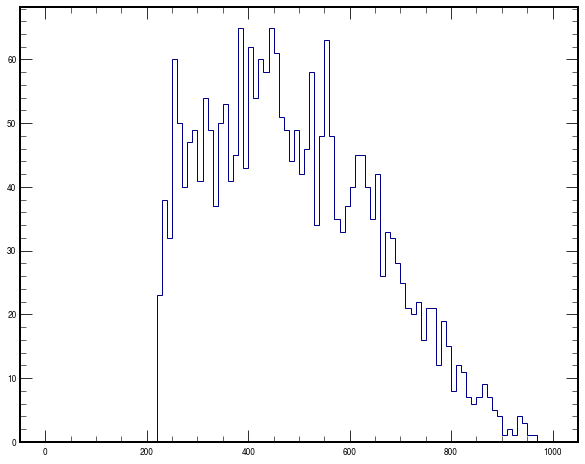

In [58]:
label_ = "GGToWW-AQGC-A0W2e-6"

fig = plt.figure( figsize=(10,8) )

plt.hist( df_signals_protons_multiRP_events[ label_ ].loc[ :, "jet0_pt_nom" ], histtype='step', color="darkblue", linestyle="-", bins=100, range=( 0., 1000. ) )

In [59]:
# df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events = {}
# for label_ in labels_signals:
#     df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events[ label_ ] = {}
#     for key_ in df_signals_protons_multiRP_out_acceptance_misreconstructed_events[ label_ ]: 
#         print ( key_ )
#         df_events__ = df_signals_protons_multiRP_out_acceptance_misreconstructed_events[ label_ ][ key_ ]
#         print ( df_events__.shape[0] )
#         df_selected_events__, selection_keys__, selections__ = select_events( df_events__ )
#         print ( df_selected_events__.shape[0] )
#         print ( selection_keys__ )
#         print ( selections__ )
#         df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events[ label_ ][ key_ ] = df_selected_events__

In [60]:
df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events = {}
# df_signals_protons_multiRP_sig_plus_mix_2protons_sig_selected_events = {}
# df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm0_selected_events = {}
# df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm1_selected_events = {}
# df_signals_protons_multiRP_sig_plus_mix_2protons_mix_selected_events = {}
df_signals_protons_multiRP_sig_plus_mix_selected_events_categories = {}

variations_ = { "jet": [ "_jes_up", "_jes_dw" ] }
for label_ in labels_signals:
    print ( label_ )
    df_events__ = df_signals_protons_multiRP_sig_plus_mix_2protons_events[ label_ ]
    print ( df_events__.shape[0] )
    df_selected_events__, selection_keys__, selections__  = select_events( df_events__ )
    print ( df_selected_events__.shape[0] )
    print ( selection_keys__ )
    print ( selections__ )
    df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ] = {}
    df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ][ "_nom" ] = df_selected_events__
    for var_label__ in variations_:
        print ( var_label__ )
        for variation__ in variations_[ var_label__ ]:
            opt__ = { "label_" + var_label__ : variation__ }
            print ( opt__ )
            df_selected_events__, selection_keys__, selections__  = select_events( df_events__, **opt__ )
            print ( df_selected_events__.shape[0] )
            print ( selection_keys__ )
            print ( selections__ )
            df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ][ variation__ ] = df_selected_events__
            
    df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ] = {}
    for cat__ in df_signals_protons_multiRP_sig_plus_mix_events_categories[ label_ ]:
        print ( cat__ )
        df_events__ = df_signals_protons_multiRP_sig_plus_mix_events_categories[ label_ ][ cat__ ]
        print ( df_events__.shape[0] )
        df_selected_events__, selection_keys__, selections__  = select_events( df_events__ )
        print ( df_selected_events__.shape[0] )
        print ( selection_keys__ )
        print ( selections__ )
        df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ][ cat__ ] = {}
        df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ][ cat__ ][ "_nom" ] = df_selected_events__
        for var_label__ in variations_:
            print ( var_label__ )
            for variation__ in variations_[ var_label__ ]:
                opt__ = { "label_" + var_label__ : variation__ }
                print ( opt__ )
                df_selected_events__, selection_keys__, selections__  = select_events( df_events__, **opt__ )
                print ( df_selected_events__.shape[0] )
                print ( selection_keys__ )
                print ( selections__ )
                df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ][ cat__ ][ variation__ ] = df_selected_events__

GGToWW-AQGC-A0W1e-6
2076
852
['All', 'Muon', 'Jet', 'Jet_Muon', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']
{'All': 2076, 'Muon': 2076, 'Jet': 1925, 'Jet_Muon': 1925, 'MET': 1757, 'Jet_MET': 1689, 'PrunedMass': 1275, 'Tau21': 1173, 'BJet_Veto': 1173, 'Xi_CMS': 1118, 'WLeptonic': 1108, 'Jet_WLeptonic': 1108, 'MWW': 1098, 'ExtraTracks': 852}
jet
{'label_jet': '_jes_up'}
849
['All', 'Muon', 'Jet', 'Jet_Muon', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']
{'All': 2076, 'Muon': 2076, 'Jet': 1932, 'Jet_Muon': 1932, 'MET': 1762, 'Jet_MET': 1694, 'PrunedMass': 1276, 'Tau21': 1173, 'BJet_Veto': 1173, 'Xi_CMS': 1116, 'WLeptonic': 1107, 'Jet_WLeptonic': 1107, 'MWW': 1096, 'ExtraTracks': 849}
{'label_jet': '_jes_dw'}
855
['All', 'Muon', 'Jet', 'Jet_Muon', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'Ex

368
['All', 'Muon', 'Jet', 'Jet_Muon', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']
{'All': 795, 'Muon': 795, 'Jet': 772, 'Jet_Muon': 772, 'MET': 713, 'Jet_MET': 676, 'PrunedMass': 552, 'Tau21': 498, 'BJet_Veto': 498, 'Xi_CMS': 464, 'WLeptonic': 464, 'Jet_WLeptonic': 464, 'MWW': 462, 'ExtraTracks': 368}
jet
{'label_jet': '_jes_up'}
367
['All', 'Muon', 'Jet', 'Jet_Muon', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']
{'All': 795, 'Muon': 795, 'Jet': 772, 'Jet_Muon': 772, 'MET': 713, 'Jet_MET': 676, 'PrunedMass': 552, 'Tau21': 498, 'BJet_Veto': 498, 'Xi_CMS': 463, 'WLeptonic': 463, 'Jet_WLeptonic': 463, 'MWW': 461, 'ExtraTracks': 367}
{'label_jet': '_jes_dw'}
371
['All', 'Muon', 'Jet', 'Jet_Muon', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']
{'All': 795, 'Muon': 795, 'Jet': 772, '

1444
['All', 'Muon', 'Jet', 'Jet_Muon', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']
{'All': 3230, 'Muon': 3230, 'Jet': 3189, 'Jet_Muon': 3189, 'MET': 2971, 'Jet_MET': 2810, 'PrunedMass': 2157, 'Tau21': 1994, 'BJet_Veto': 1994, 'Xi_CMS': 1875, 'WLeptonic': 1870, 'Jet_WLeptonic': 1870, 'MWW': 1867, 'ExtraTracks': 1444}
2protons_mix
2203
920
['All', 'Muon', 'Jet', 'Jet_Muon', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']
{'All': 2203, 'Muon': 2203, 'Jet': 2180, 'Jet_Muon': 2180, 'MET': 2057, 'Jet_MET': 1927, 'PrunedMass': 1502, 'Tau21': 1354, 'BJet_Veto': 1354, 'Xi_CMS': 1184, 'WLeptonic': 1180, 'Jet_WLeptonic': 1180, 'MWW': 1180, 'ExtraTracks': 920}
jet
{'label_jet': '_jes_up'}
909
['All', 'Muon', 'Jet', 'Jet_Muon', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']
{'All': 2203, 'Muo

In [61]:
import json
samples_info = json.load( open( 'samples_info.json' ) )
samples_info

{'QCD_Pt_170to300_TuneCP5_13TeV_pythia8': [29829920.0, 103500, 2],
 'ExclusiveWW_a0w1e-6-SingleLepton-2017': [15000.0, 0.062086, 6],
 'GGToWW_bSM-A0W5e-6_13TeV-fpmc-herwig6': [993000.0, 0.148132, 6],
 'GGToWWToJJENu_PtL-15_13TeV-fpmc-herwig6': [295401.0, 0.0049534, 1],
 'QCD_Pt_1800to2400_TuneCP5_13TeV_pythia8': [2923941.0, 0.08743, 2],
 'DYJetsToLL_1J_TuneCP5_13TeV-amcatnloFXFX-pythia8': [95629091.0, 859.59, 12],
 'GGToWW_bSM-ACW5e-6_13TeV-fpmc-herwig6': [99500.0, 0.0487, 6],
 'QCD_Pt-300to470_MuEnrichedPt5_TuneCP5_13TeV_pythia8': [15679722.0,
  797.3526899999999,
  2],
 'ZZ_TuneCP5_13TeV-pythia8': [1949768.0, 16.523, 3],
 'QCD_Pt-170to300_MuEnrichedPt5_TuneCP5_13TeV_pythia8': [46438676.0,
  8654.49315,
  2],
 'WJetsToLNu_HT-1200To2500_TuneCP5_13TeV-madgraphMLM-pythia8': [20258624.0,
  1.02333,
  862],
 'W1JetsToLNu_LHEWpT_100-150_TuneCP5_13TeV-amcnloFXFX-pythia8': [73508344.0,
  286.1,
  862],
 'ST_t-channel_antitop_4f_inclusiveDecays_TuneCP5_13TeV-powhegV2-madspin-pythia8': [3939990

In [62]:
lumi = np.sum( list( lumi_periods.values() ) )
print ( lumi )

#labels_signals = [ "GGToWW-AQGC-test-A0W1e-6", "GGToWW-AQGC-test-A0W2e-6", "GGToWW-AQGC-test-A0W5e-6" ]
sample_names = {}
sample_names[ "GGToWW-AQGC-A0W1e-6" ] = "GGToWW_bSM-A0W1e-6_13TeV-fpmc-herwig6"
sample_names[ "GGToWW-AQGC-A0W2e-6" ] = "GGToWW_bSM-A0W2e-6_13TeV-fpmc-herwig6"
sample_names[ "GGToWW-AQGC-A0W5e-6" ] = "GGToWW_bSM-A0W5e-6_13TeV-fpmc-herwig6"

norm_factors = {}
for label_ in labels_signals:
    print ( label_ )
    sample_nevents_, sample_cross_section_, _ = samples_info[ sample_names[ label_ ] ]
    norm_factors[ label_ ] = np.array( [ lumi / ( sample_nevents_ ), sample_cross_section_*1000, 1.0 ] )
    print ( samples_info[ sample_names[ label_] ] )
    print ( norm_factors[ label_ ] )
    norm_factors_product_ = np.product( norm_factors[ label_ ] )
    df_signals_protons_multiRP_events[ label_ ].loc[ :, "norm" ] = norm_factors_product_
    df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ][ "_nom" ].loc[ :, "norm" ] = norm_factors_product_
    for variation__ in df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ]:
        print ( variation__ )
        df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ][ variation__ ].loc[ :, "norm" ] = norm_factors_product_
    for cat__ in df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ]:
        print ( cat__ )
#     for cat__ in df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events[ label_ ]:
#         print ( cat__ )
#         df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events[ label_ ][ cat__ ].loc[ :, "norm" ] = norm_factors_product_
        for variation__ in df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ][ cat__ ]:
            print ( variation__ )
            df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ][ cat__ ][ variation__ ].loc[ :, "norm" ] = norm_factors_product_

37.190432966
GGToWW-AQGC-A0W1e-6
[993700.0, 0.0453974, 6]
[3.74262181e-05 4.53974000e+01 1.00000000e+00]


/cvmfs/sft.cern.ch/lcg/views/LCG_99/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


_nom
_jes_up


/cvmfs/sft.cern.ch/lcg/views/LCG_99/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


_jes_dw
2protons_sig
_nom
_jes_up
_jes_dw
1proton_sig_Arm0
_nom
_jes_up
_jes_dw
1proton_sig_Arm1
_nom
_jes_up
_jes_dw
2protons_mix
_nom
_jes_up
_jes_dw
GGToWW-AQGC-A0W2e-6
[880000.0, 0.0583158, 6]
[4.22618556e-05 5.83158000e+01 1.00000000e+00]
_nom
_jes_up
_jes_dw
2protons_sig
_nom
_jes_up
_jes_dw
1proton_sig_Arm0
_nom
_jes_up
_jes_dw
1proton_sig_Arm1
_nom
_jes_up
_jes_dw
2protons_mix
_nom
_jes_up
_jes_dw
GGToWW-AQGC-A0W5e-6
[993000.0, 0.148132, 6]
[3.74526012e-05 1.48132000e+02 1.00000000e+00]
_nom
_jes_up
_jes_dw
2protons_sig
_nom
_jes_up
_jes_dw
1proton_sig_Arm0
_nom
_jes_up
_jes_dw
1proton_sig_Arm1
_nom
_jes_up
_jes_dw
2protons_mix
_nom
_jes_up
_jes_dw


In [63]:
label_ = "GGToWW-AQGC-A0W1e-6"

print ( df_signals_protons_multiRP_events[ label_ ].columns )
df_signals_protons_multiRP_events[ label_ ]

Index(['crossingAngle', 'jet0_pt', 'jet0_eta', 'jet0_phi', 'jet0_energy',
       'jet0_mass', 'jet0_corrmass', 'jet0_tau1', 'jet0_tau2', 'jet0_vertexz',
       ...
       'YX_m100_m100', 'R_MWW_MX_m100_m100', 'Diff_YWW_YX_m100_m100',
       'eff_proton_all_weighted', 'eff_multitrack_weighted',
       'eff_strictzero_weighted', 'eff_proton_all', 'eff_multitrack',
       'eff_strictzero', 'norm'],
      dtype='object', length=163)


crossingAngle     jet0_pt  jet0_eta  jet0_phi  \
run lumiblock event  slice                                                  
1   2275      227457 0              150.0  345.850189 -1.458291  3.099098   
    2276      227579 0              140.0  819.906433  0.347934  1.723913   
    2282      228117 0              130.0  321.463196  0.091370 -2.196248   
    2286      228503 0              130.0  649.005920 -0.110481  1.066668   
              228565 0              130.0  360.785767  0.943119 -1.373860   
    2297      229605 0              120.0  314.089844 -0.833665  2.804024   
    2298      229715 0              140.0  303.292603 -0.605599  1.378168   
    2305      230479 0              120.0  711.671204 -0.083028 -2.544181   
    2316      231571 0              130.0  304.978241 -1.147173  1.442453   
    4034      403369 0              140.0  271.863373 -0.377092  2.046722   
    4054      405349 0              150.0  557.424194 -0.760342  0.956181   
    3850      384981 0              120.0  252.268082 -1.713197  2.468808   
    3852      385168 0              120.0  491.048767  0.647862  0.466178   
    3862      386166 0              150.0  635.511841  0.297460  1.661229   
              386194 0              150.0  434.129974 -0.537267 -1.875507   
    3865      386403 0              120.0  253.235092  0.857444 -1.256152   
              386463 0              120.0  735.412415 -0.658536  1.340903   
    3870      386996 0              120.0  647.854858  0.063386 -1.009207   
    4255      425453 0              130.0  307.973694 -1.193913  0.364675   
    4264      426339 0              130.0  308.640625 -0.778031 -3.126354   
              426393 0              130.0  281.545044 -1.154744  0.944827   
    4271      427010 0              130.0  675.825195 -0.473871 -0.401099   
    4273      427206 0              120.0  660.517334 -0.069177 -2.677781   
    9601      460019 0              150.0  532.998779  0.894459 -0.545929   
    9607      460669 0              150.0  287.972534 -0.907298  2.777492   
              460696 0              150.0  652.113708  0.084567 -2.959348   
    9612      461137 0              150.0  400.678864 -0.966325  2.217957   
    9579      457851 0              150.0  391.394226  1.252353  3.121012   
    9583      458238 0              150.0  293.645050 -0.989693 -2.854835   
    9616      461531 0              130.0  346.565308 -1.741414 -2.957556   
...                                   ...         ...       ...       ...   
    2440      243914 0              120.0  326.068268 -1.146933  0.240412   
    2447      244679 0              140.0  527.778687 -0.288657  1.168062   
    2480      247941 0              120.0  243.022858  0.018078  1.887087   
    2485      248478 0              130.0  478.567688  0.954942  1.670953   
    2489      248887 0              120.0  287.306885 -0.163211 -1.934245   
    2497      249670 0              150.0  367.433075 -0.681065  0.836650   
    2504      250354 0              130.0  235.296387 -0.688626  1.736146   
    2506      250534 0              150.0  348.601715 -0.520259  2.048185   
    2511      251083 0              130.0  439.048553  0.920148  0.663145   
    2522      252199 0              130.0  816.885559 -0.410688 -2.349145   
    9084      408308 0              120.0  222.487900  0.828301 -3.049489   
    9061      406041 0              130.0  303.140472 -0.741241 -2.557097   
    5664      66344  0              130.0  357.589813  0.837167  1.796901   
    5670      66951  0              120.0  539.069214  0.935207 -2.119600   
    5683      68294  0              120.0  647.558777  0.011456  0.183460   
    5685      68410  0              130.0  270.916138 -0.779387 -2.761405   
    5691      69049  0              140.0  363.316864 -0.673153  0.781148   
    5693      69229  0              130.0  240.823746 -1.861926 -1.990464   
    6229      122879 0              130.0  532.137878  0.928207  1.712423   
    6235      123449 0  

In [64]:
df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ][ "_jes_up" ]

MWW_jes_dw   MWW_jes_up      MWW_nom  \
run lumiblock event  slice                                          
1   7         661    0      1600.519721  1600.345418  1600.434448   
    29        2846   0       676.290448   676.285556   676.292053   
    52        5147   0      2208.462721  2208.497132  2208.482666   
    72        7117   0      1612.446924  1612.356049  1612.408691   
    78        7721   0      1477.316202  1476.124052  1476.726074   
    81        8018   0      1109.412219  1109.482850  1109.449951   
    98        9730   0      1018.503338  1018.488729  1018.498352   
    105       10427  0      1083.842459  1083.908289  1083.877075   
    118       11748  0       928.685807   928.528880   928.608948   
    129       12850  0       632.720872   632.788313   632.756775   
    171       17026  0      1232.146803  1232.093117  1232.122681   
    184       18330  0      1380.604934  1380.492519  1380.553833   
    200       19968  0      1864.063449  1863.976897  1864.022827   
    209       20845  0       872.834025   872.735775   872.787231   
    215       21403  0      1847.912272  1846.494972  1847.217529   
    217       21614  0      1018.136650  1018.056210  1018.098083   
    268       26800  0      1783.024997  1782.996784  1783.015259   
    281       28069  0      1054.803704  1054.776851  1054.792114   
    294       29320  0      1457.400263  1457.022252  1457.217773   
    296       29577  0      1474.149694  1473.966315  1474.063721   
    306       30593  0      1357.744337  1357.702864  1357.725098   
    308       30735  0      1254.340357  1254.353130  1254.349121   
    325       32497  0      1017.378355  1017.376621  1017.379456   
    329       32851  0      1083.618836  1083.529208  1083.576172   
    330       32926  0      1231.255259  1231.173931  1231.216064   
    336       33510  0       921.393033   921.254909   921.327454   
    341       34013  0      1240.403401  1240.265684  1240.337402   
    377       37602  0      1698.029995  1698.101264  1698.069824   
    392       39115  0      1786.340075  1785.934867  1786.143066   
    396       39544  0      1531.688330  1531.599236  1531.650269   
...                                 ...          ...          ...   
    9657      465618 0      1184.004786  1183.854777  1183.932007   
    9660      465920 0      1068.583517  1068.420063  1068.504272   
    9666      466587 0      1713.705595  1713.661418  1713.688965   
    9680      467935 0      1061.169607  1061.226514  1061.199829   
    9685      468481 0      1593.942674  1593.090922  1593.522339   
    9697      469634 0      1332.019164  1332.025524  1332.024902   
    9720      471972 0      2512.218700  2512.051314  2512.147949   
    9725      472465 0       542.738706   542.420883   542.582275   
    9741      474029 0       910.211364   910.164323   910.190002   
    9752      475123 0      1674.567995  1674.424856  1674.501099   
    9756      475599 0       797.326903   797.357980   797.344543   
    9778      477721 0      1325.751837  1325.777498  1325.766846   
    9789      478817 0       714.041927   713.876638   713.961853   
    9802      480127 0      1338.199005  1338.226819  1338.216309   
    9835      483494 0       947.816400   947.774747   947.797852   
    9846      484524 0       629.956540   629.908122   629.934692   
    9849      484842 0       526.370995   526.108889   526.242310   
    9859      485812 0      1401.318978  1401.186936  1401.256714   
    9861      486093 0      1007.390436  1007.147104  1007.271912   
    9862      486154 0      1081.124240  1080.911183  1081.019409   
    9881      488006 0      1451.060520  1450.900609  1450.986206   
    9887      488668 0      1192.621614  1192.331154  1192.479614   
    9890      488945 0      1615.660849  1615.506307  1615.585815   
    9896      489544 0      1845.393980  1845.463345  1845.432983   
    9898      489788 0      1446.688784  1446.695413  1446.694580   
    9907      490626 0     

In [65]:
df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ][ '2protons_sig' ][ "_nom" ][ [ "sf_muon_id", "sf_muon_id_up", "sf_muon_id_dw" ] ]

sf_muon_id  sf_muon_id_up  sf_muon_id_dw
run lumiblock event  slice                                          
1   7         661    0        0.992046       0.994182       0.989911
    81        8018   0        0.989806       0.991426       0.988185
    98        9730   0        0.989806       0.991426       0.988185
    118       11748  0        0.984060       0.996188       0.971933
    171       17026  0        0.989806       0.991426       0.988185
    200       19968  0        0.984060       0.996188       0.971933
    296       29577  0        0.989806       0.991426       0.988185
    306       30593  0        0.992046       0.994182       0.989911
    308       30735  0        0.989806       0.991426       0.988185
    325       32497  0        0.989806       0.991426       0.988185
    330       32926  0        0.992046       0.994182       0.989911
    341       34013  0        0.989806       0.991426       0.988185
    429       42811  0        0.989806       0.991426       0.988185
    455       45434  0        0.989806       0.991426       0.988185
    556       55569  0        0.989806       0.991426       0.988185
    561       56057  0        0.989806       0.991426       0.988185
    592       59140  0        0.992046       0.994182       0.989911
    600       59991  0        0.984060       0.996188       0.971933
    630       62975  0        0.989806       0.991426       0.988185
    642       64168  0        0.984060       0.996188       0.971933
    652       65152  0        0.985555       0.986415       0.984694
    656       65553  0        0.989806       0.991426       0.988185
    686       68594  0        0.989806       0.991426       0.988185
    729       72889  0        0.985555       0.986415       0.984694
    737       73653  0        0.976631       0.985258       0.968005
    758       75731  0        0.989806       0.991426       0.988185
    778       77755  0        0.989806       0.991426       0.988185
    822       82195  0        0.989806       0.991426       0.988185
    903       90233  0        0.989806       0.991426       0.988185
    908       90755  0        0.992046       0.994182       0.989911
...                                ...            ...            ...
    9264      426389 0        0.985555       0.986415       0.984694
    9274      427301 0        0.984060       0.996188       0.971933
    9276      427590 0        0.989806       0.991426       0.988185
    9281      428061 0        0.989806       0.991426       0.988185
    9291      429098 0        0.989806       0.991426       0.988185
    9320      431957 0        0.992046       0.994182       0.989911
    9358      435715 0        0.984060       0.996188       0.971933
    9368      436753 0        0.989806       0.991426       0.988185
    9432      443111 0        0.984060       0.996188       0.971933
    9477      447662 0        0.989806       0.991426       0.988185
    9481      448009 0        0.989806       0.991426       0.988185
    9522      452172 0        0.985555       0.986415       0.984694
    9531      453065 0        0.984060       0.996188       0.971933
    9607      460696 0        0.989806       0.991426       0.988185
    9680      467935 0        0.984060       0.996188       0.971933
    9697      469634 0        0.989806       0.991426       0.988185
    9725      472465 0        0.989806       0.991426       0.988185
    9741      474029 0        0.984060       0.996188       0.971933
    9756      475599 0        0.989806       0.991426       0.988185
    9778      477721 0        0.992046       0.994182       0.989911
    9835      483494 0        0.989806       0.991426       0.988185
    9846      484524 0        0.989806       0.991426       0.988185
    9859      485812 0        0.989806       0.991426       0.988185
    9861      486093 0        0.984060       0.996188       0.971933
    9862      486154 0        0.992046       0.994182       0.989911
    9881      488006 0    

In [66]:
labels_samples = {
    "GGToWW-AQGC-A0W1e-6": r"$\gamma\gamma \to WW \quad a_0^W=1e^{-6}$",
    "GGToWW-AQGC-A0W2e-6": r"$\gamma\gamma \to WW \quad a_0^W=2e^{-6}$",
    "GGToWW-AQGC-A0W5e-6": r"$\gamma\gamma \to WW \quad a_0^W=5e^{-6}$"
}

variations_weights_ = [ "nom", "sf_muon_id_up", "sf_muon_id_dw" ]
var_names_sf_muon_id__ = { "nom": "sf_muon_id", "sf_muon_id_up": "sf_muon_id_up", "sf_muon_id_dw": "sf_muon_id_dw" }

weights_mc = {}
weights_sig_plus_mix_2protons = {}
weights_sig_plus_mix_categories = {}
# weights_out_acceptance_misreconstructed = {}
for label_ in labels_signals:
    print ( label_ )
    weights_mc[ label_ ] = {}
    weights_sig_plus_mix_2protons[ label_ ] = {}
    weights_sig_plus_mix_categories[ label_ ] = {}
    for var_weights_ in variations_weights_:
        weights_mc[ label_ ][ var_weights_ ] = ( df_signals_protons_multiRP_events[ label_ ][ "norm" ] * 
                                                 df_signals_protons_multiRP_events[ label_ ][ "pileupWeight" ] *
                                                 df_signals_protons_multiRP_events[ label_ ][ var_names_sf_muon_id__[ var_weights_ ] ] *
                                                 df_signals_protons_multiRP_events[ label_ ][ "eff_proton_all" ] *
                                                 df_signals_protons_multiRP_events[ label_ ][ "eff_multitrack" ] )

    #     weights_sig_plus_mix_2protons[ label_ ] = ( df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ][ "norm" ] * 
    #                                                 df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ][ "pileupWeight" ] *
    #                                                 df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ][ "sf_muon_id" ] *
    #                                                 df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ][ "eff_proton_all" ] *
    #                                                 df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ][ "eff_strictzero" ] )
        weights_sig_plus_mix_2protons[ label_ ][ var_weights_ ] = {}
        for variation__ in df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ]:
            weights_sig_plus_mix_2protons[ label_ ][ var_weights_ ][ variation__ ] = ( df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ][ variation__ ][ "norm" ] * 
                                                                                       df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ][ variation__ ][ "pileupWeight" ] *
                                                                                       df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ][ variation__ ][ var_names_sf_muon_id__[ var_weights_ ] ] *
                                                                                       df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ][ variation__ ][ "eff_strictzero" ] )

        weights_sig_plus_mix_categories[ label_ ][ var_weights_ ] = {}
        for cat__ in df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ]:
            print ( cat__ )
    #         weights_sig_plus_mix_categories[ label_ ][ cat__ ] = ( df_selected_events__[ "norm" ] * 
    #                                                               df_selected_events__[ "pileupWeight" ] *
    #                                                               df_selected_events__[ "sf_muon_id" ] *
    #                                                               df_selected_events__[ "eff_proton_all" ] *
    #                                                               df_selected_events__[ "eff_strictzero" ] )
            weights_sig_plus_mix_categories[ label_ ][ var_weights_ ][ cat__ ] = {}
            for variation__ in df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ][ cat__ ]:
                df_selected_events__ = df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ][ cat__ ][ variation__ ]
                weights_sig_plus_mix_categories[ label_ ][ var_weights_ ][ cat__ ][ variation__ ] = ( df_selected_events__[ "norm" ] * 
                                                                                                      df_selected_events__[ "pileupWeight" ] *
                                                                                                      df_selected_events__[ var_names_sf_muon_id__[ var_weights_ ] ] *
                                                                                                      df_selected_events__[ "eff_strictzero" ] )

    #     weights_out_acceptance_misreconstructed[ label_ ] = {}
    #     for cat__ in df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events[ label_ ]:
    #         print ( cat__ )
    #         df_selected_events__ = df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events[ label_ ][ cat__ ]
    #         weights_out_acceptance_misreconstructed[ label_ ][ cat__ ] = ( df_selected_events__[ "norm" ] * 
    #                                                                       df_selected_events__[ "pileupWeight" ] *
    #                                                                       df_selected_events__[ "sf_muon_id" ] *
    #                                                                       df_selected_events__[ "eff_proton_all" ] *
    #                                                                       df_selected_events__[ "eff_multitrack" ] )
        
print ( weights_mc )
print ( weights_sig_plus_mix_2protons )
print ( weights_sig_plus_mix_categories )
# print ( weights_out_acceptance_misreconstructed )

GGToWW-AQGC-A0W1e-6
2protons_sig
1proton_sig_Arm0
1proton_sig_Arm1
2protons_mix
2protons_sig
1proton_sig_Arm0
1proton_sig_Arm1
2protons_mix
2protons_sig
1proton_sig_Arm0
1proton_sig_Arm1
2protons_mix
GGToWW-AQGC-A0W2e-6
2protons_sig
1proton_sig_Arm0
1proton_sig_Arm1
2protons_mix
2protons_sig
1proton_sig_Arm0
1proton_sig_Arm1
2protons_mix
2protons_sig
1proton_sig_Arm0
1proton_sig_Arm1
2protons_mix
GGToWW-AQGC-A0W5e-6
2protons_sig
1proton_sig_Arm0
1proton_sig_Arm1
2protons_mix
2protons_sig
1proton_sig_Arm0
1proton_sig_Arm1
2protons_mix
2protons_sig
1proton_sig_Arm0
1proton_sig_Arm1
2protons_mix
{'GGToWW-AQGC-A0W1e-6': {'nom': run  lumiblock  event   slice
1    2275       227457  0        3.805316e-05
     2276       227579  0        5.700850e-05
     2282       228117  0        5.536872e-04
     2286       228503  0        7.487326e-04
                228565  0        2.603201e-05
     2297       229605  0        6.252340e-06
     2298       229715  0        5.505029e-05
     2305       

{'GGToWW-AQGC-A0W1e-6': {'nom': {'_nom': run  lumiblock  event   slice
1    7          661     0        0.001114
     29         2846    0        0.000577
     52         5147    0        0.002107
     72         7117    0        0.001344
     78         7721    0        0.002110
     81         8018    0        0.000821
     98         9730    0        0.000180
     105        10427   0        0.001118
     118        11748   0        0.000687
     129        12850   0        0.001671
     171        17026   0        0.000210
     184        18330   0        0.000026
     200        19968   0        0.000161
     209        20845   0        0.001841
     215        21403   0        0.000460
     217        21614   0        0.001362
     268        26800   0        0.000749
     281        28069   0        0.001579
     294        29320   0        0.000947
     296        29577   0        0.001020
     306        30593   0        0.001240
     308        30735   0        0.000245
     

{'GGToWW-AQGC-A0W1e-6': {'nom': {'2protons_sig': {'_nom': run  lumiblock  event   slice
1    7          661     0        0.001114
     81         8018    0        0.000821
     98         9730    0        0.000180
     118        11748   0        0.000687
     171        17026   0        0.000210
     200        19968   0        0.000161
     296        29577   0        0.001020
     306        30593   0        0.001240
     308        30735   0        0.000245
     325        32497   0        0.000379
     330        32926   0        0.001107
     341        34013   0        0.000790
     429        42811   0        0.000002
     455        45434   0        0.000341
     556        55569   0        0.001001
     561        56057   0        0.000973
     592        59140   0        0.001536
     600        59991   0        0.000158
     630        62975   0        0.000360
     642        64168   0        0.000168
     652        65152   0        0.001427
     656        65553   0     

In [67]:
df_signals_protons_multiRP_sig_plus_mix_selected_events_categories_concat = {}
weights_sig_plus_mix_categories_concat = {}
df_signals_protons_multiRP_sig_plus_mix_selected_events_categories_concat_skip_sig = {}
weights_sig_plus_mix_categories_concat_skip_sig = {}
for label_ in labels_signals:
    print ( label_ )
    df_signals_protons_multiRP_sig_plus_mix_selected_events_categories_concat[ label_ ] = {}
    df_signals_protons_multiRP_sig_plus_mix_selected_events_categories_concat_skip_sig[ label_ ] = {}
    weights_sig_plus_mix_categories_concat[ label_ ] = {}
    weights_sig_plus_mix_categories_concat_skip_sig[ label_ ] = {}
    for var_weights_ in variations_weights_:
        weights_sig_plus_mix_categories_concat[ label_ ][ var_weights_ ] = {}
        weights_sig_plus_mix_categories_concat_skip_sig[ label_ ][ var_weights_ ] = {}
        
    df_signals_protons_multiRP_sig_plus_mix_selected_events_categories__ = {}
    df_signals_protons_multiRP_sig_plus_mix_selected_events_categories_skip_sig__ = {}
    weights_sig_plus_mix_categories__ = {}
    weights_sig_plus_mix_categories_skip_sig__ = {}
    for var_weights_ in variations_weights_:
        weights_sig_plus_mix_categories__[ var_weights_ ] = {}
        weights_sig_plus_mix_categories_skip_sig__[ var_weights_ ] = {}
    idx_cat__ = 0
    for cat__ in df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ]:
        for variation__ in df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ][ cat__ ]:
            if idx_cat__ == 0:
                df_signals_protons_multiRP_sig_plus_mix_selected_events_categories__[ variation__ ] = {}
                df_signals_protons_multiRP_sig_plus_mix_selected_events_categories_skip_sig__[ variation__ ] = {}
                for var_weights_ in variations_weights_:
                    weights_sig_plus_mix_categories__[ var_weights_ ][ variation__ ] = {}
                    weights_sig_plus_mix_categories_skip_sig__[ var_weights_ ][ variation__ ] = {}
            df_signals_protons_multiRP_sig_plus_mix_selected_events_categories__[ variation__ ][ cat__ ] = df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ][ cat__ ][ variation__ ]
            for var_weights_ in variations_weights_:
                weights_sig_plus_mix_categories__[ var_weights_ ][ variation__ ][ cat__ ] = weights_sig_plus_mix_categories[ label_ ][ var_weights_ ][ cat__ ][ variation__ ]
            if cat__ != '2protons_sig':
                df_signals_protons_multiRP_sig_plus_mix_selected_events_categories_skip_sig__[ variation__ ][ cat__ ] = df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ][ cat__ ][ variation__ ]
                for var_weights_ in variations_weights_:
                    weights_sig_plus_mix_categories_skip_sig__[ var_weights_ ][ variation__ ][ cat__ ] = weights_sig_plus_mix_categories[ label_ ][ var_weights_ ][ cat__ ][ variation__ ]
        idx_cat__ += 1

    for variation__ in df_signals_protons_multiRP_sig_plus_mix_selected_events_categories__:
        df_signals_protons_multiRP_sig_plus_mix_selected_events_categories_concat[ label_ ][ variation__ ] = pd.concat( df_signals_protons_multiRP_sig_plus_mix_selected_events_categories__[ variation__ ] )
        df_signals_protons_multiRP_sig_plus_mix_selected_events_categories_concat_skip_sig[ label_ ][ variation__ ] = pd.concat( df_signals_protons_multiRP_sig_plus_mix_selected_events_categories_skip_sig__[ variation__ ] )
        for var_weights_ in variations_weights_:
            weights_sig_plus_mix_categories_concat[ label_ ][ var_weights_ ][ variation__ ] = pd.concat( weights_sig_plus_mix_categories__[ var_weights_ ][ variation__ ] )
            weights_sig_plus_mix_categories_concat_skip_sig[ label_ ][ var_weights_ ][ variation__ ] = pd.concat( weights_sig_plus_mix_categories_skip_sig__[ var_weights_ ][ variation__ ] )
    
    print ( weights_sig_plus_mix_categories_concat[ label_ ] )
    print ( weights_sig_plus_mix_categories_concat_skip_sig[ label_ ] )

GGToWW-AQGC-A0W1e-6
{'nom': {'_nom':                   run  lumiblock  event   slice
1proton_sig_Arm0  1    29         2846    0        0.000577
                       129        12850   0        0.001671
                       209        20845   0        0.001841
                       268        26800   0        0.000749
                       329        32851   0        0.000679
                       396        39544   0        0.001319
                       507        50616   0        0.001828
                       559        55866   0        0.000124
                       1065       106462  0        0.001211
                       1079       107852  0        0.000235
                       1096       109534  0        0.001459
                       1133       113203  0        0.001369
                       1169       116864  0        0.001250
                       1186       118510  0        0.001048
                       1233       123257  0        0.000689
               

{'nom': {'_nom':                   run  lumiblock  event   slice
1proton_sig_Arm0  1    15         1470    0        0.002650
                       64         6320    0        0.001521
                       78         7721    0        0.001867
                       94         9382    0        0.001711
                       193        19218   0        0.001615
                       228        22778   0        0.002053
                       234        23322   0        0.001778
                       240        23908   0        0.001306
                       242        24117   0        0.001427
                       254        25358   0        0.001437
                       258        25799   0        0.002560
                       269        26835   0        0.002390
                       452        45180   0        0.001427
                       481        48036   0        0.000955
                       492        49168   0        0.001977
                       522        5

{'nom': {'_nom':                   run  lumiblock  event   slice
1proton_sig_Arm0  1    5          420     0        0.004114
                       6          582     0        0.003418
                       22         2161    0        0.004317
                       53         5259    0        0.004668
                       83         8211    0        0.001927
                       87         8631    0        0.004138
                       93         9260    0        0.003225
                       97         9602    0        0.003198
                       117        11636   0        0.005028
                       143        14221   0        0.005414
                                  14257   0        0.003723
                       153        15264   0        0.004332
                       157        15627   0        0.002283
                       159        15892   0        0.003284
                       183        18274   0        0.003334
                       200        1

In [68]:
# df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events_concat = {}
# weights_out_acceptance_misreconstructed_concat = {}
# for label_ in labels_signals:
#     print ( label_ )
#     df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events_concat[ label_ ] = pd.concat( df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events[ label_ ] )
#     print ( df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events_concat[ label_ ].shape[0] )
#     weights_out_acceptance_misreconstructed_concat[ label_ ] = pd.concat( weights_out_acceptance_misreconstructed[ label_ ] )
#     print ( weights_out_acceptance_misreconstructed_concat[ label_ ] )

In [69]:
label_ = "GGToWW-AQGC-A0W2e-6"
df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ][ "_nom" ]

MWW_jes_dw   MWW_jes_up      MWW_nom  \
run lumiblock event  slice                                          
1   13        1269   0       766.032966   765.989312   766.013611   
    15        1470   0      1719.973358  1719.960994  1719.974243   
    20        2000   0      1634.234404  1634.289668  1634.266113   
    23        2259   0      1741.267765  1741.300203  1741.289062   
    25        2403   0      1591.974257  1592.015734  1591.999268   
              2423   0       811.793086   811.724667   811.760193   
    27        2643   0      1458.797736  1457.763755  1458.286377   
    33        3242   0      1071.223397  1071.149121  1071.188721   
    44        4363   0      1114.340731  1114.322629  1114.335205   
    49        4896   0       821.856451   821.580926   821.721558   
    51        5047   0       771.181620   771.065821   771.126221   
    52        5151   0      1455.663832  1455.625839  1455.649414   
    63        6249   0      1857.373277  1857.413604  1857.402954   
    64        6320   0       560.026903   559.854090   559.942749   
    68        6733   0      1309.550624  1309.455858  1309.506836   
    72        7167   0       745.285766   745.146442   745.217773   
    78        7721   0      1751.510044  1751.291659  1751.404175   
    80        7965   0      1481.283762  1481.145642  1481.218628   
    94        9382   0      1443.387781  1443.298140  1443.345825   
    99        9865   0      1238.203802  1238.227397  1238.219727   
    103       10269  0      2007.565783  2006.819853  2007.206909   
    113       11268  0      1310.056899  1310.041350  1310.051758   
    116       11574  0      1269.043244  1268.519660  1268.786621   
    122       12101  0      1402.265615  1402.164466  1402.217896   
    126       12595  0      1205.744603  1205.665564  1205.708496   
    133       13237  0      1624.191626  1624.091112  1624.145264   
    136       13502  0      1374.104588  1374.074119  1374.093262   
    137       13654  0       699.006576   699.042060   699.026611   
    140       13962  0      1684.787858  1684.720128  1684.759521   
    141       14064  0      1181.460582  1181.435686  1181.451172   
...                                 ...          ...          ...   
    9914      491390 0      1577.110582  1577.121682  1577.118164   
    9920      491912 0      1844.493387  1844.319452  1844.414551   
    9921      492015 0       904.003230   903.938808   903.973816   
    9929      492876 0      2138.618164  2138.714830  2138.678955   
    9932      493123 0      1373.838276  1373.874691  1373.858765   
    9934      493310 0      1608.547086  1607.836381  1608.200439   
    9941      494012 0      1284.696387  1284.680720  1284.691528   
    9942      494134 0      1580.401150  1580.278417  1580.343994   
    9943      494258 0      2079.152825  2078.579104  2078.880859   
    9945      494471 0       777.277548   777.135145   777.208801   
    9948      494702 0      1450.039149  1449.986386  1450.015381   
    9950      494936 0      1619.270672  1619.221795  1619.253418   
    9951      495080 0       886.785343   886.619658   886.705261   
    9954      495392 0      2354.037519  2353.695661  2353.878174   
    9958      495767 0      1450.444407  1450.370143  1450.408569   
    9960      495955 0      1504.696453  1504.743353  1504.724121   
    9962      496171 0      1318.891535  1318.291320  1318.597168   
              496182 0      1112.735806  1112.325854  1112.533936   
    9965      496461 0      1876.011747  1875.726341  1875.879883   
    9972      497184 0      1352.022411  1352.057579  1352.042969   
    9974      497356 0      1779.237670  1779.188844  1779.214722   
    9975      497412 0      1728.064418  1727.947751  1728.014160   
    9978      497774 0      1192.201421  1192.206467  1192.206543   
    9985      498499 0      1880.935868  1880.596897  1880.772705   
    9988      498748 0      1834.972543  1834.674794  1834.829346   
    9990      498951 0     

In [70]:
df_signals_protons_multiRP_sig_plus_mix_selected_events_categories_concat[ label_ ][ "_nom" ]

MWW_jes_dw   MWW_jes_up  \
                 run lumiblock event  slice                             
1proton_sig_Arm0 1   15        1470   0      1719.973358  1719.960994   
                     64        6320   0       560.026903   559.854090   
                     78        7721   0      1751.510044  1751.291659   
                     94        9382   0      1443.387781  1443.298140   
                     193       19218  0      1478.518222  1478.593869   
                     228       22778  0      1613.886703  1613.873513   
                     234       23322  0      1691.405084  1691.526111   
                     240       23908  0       853.825189   853.748646   
                     242       24117  0      1384.738740  1384.699172   
                     254       25358  0      1624.396368  1624.466636   
                     258       25799  0      1338.655554  1338.501938   
                     269       26835  0      1470.392895  1470.209451   
                     452       45180  0      1520.342763  1520.325472   
                     481       48036  0       620.784523   620.737039   
                     492       49168  0      1539.764899  1539.758609   
                     522       52189  0      1518.928287  1518.979953   
                     569       56892  0      1834.764139  1834.789096   
                     594       59335  0      1877.206528  1877.117668   
                     600       59975  0      1742.941927  1742.875538   
                     602       60119  0      1778.618758  1778.405219   
                     608       60756  0      1259.497318  1259.452493   
                     655       65421  0      2025.552195  2025.204409   
                               65432  0      1845.192366  1845.069385   
                               65447  0      1599.263342  1598.888910   
                     692       69129  0      1427.902603  1427.986986   
                     723       72210  0      1779.401551  1779.398114   
                     766       76592  0      1502.482536  1502.265896   
                     771       77010  0      1314.882522  1313.190435   
                     824       82377  0      1848.689160  1848.639426   
                     841       84084  0      1817.638192  1817.265463   
...                                                  ...          ...   
2protons_sig     1   9582      458132 0       773.745823   773.805871   
                     9583      458290 0      1631.274414  1630.970443   
                     9601      460059 0      1580.644869  1580.715025   
                     9609      460819 0       601.150130   601.165036   
                     9648      464728 0       794.966462   794.804760   
                     9688      468702 0      1217.944608  1218.070761   
                     9701      470084 0      1435.667779  1435.550369   
                     9727      472700 0      1091.108061  1090.859196   
                     9737      473624 0      1388.111925  1388.031324   
                     9749      474896 0      1122.902802  1122.770845   
                     9751      475077 0      1098.528591  1098.554229   
                     9764      476312 0      1383.260102  1383.276979   
                     9770      476967 0      1247.329448  1247.210896   
                     9789      478803 0       894.133768   894.210098   
                     9801      480011 0      1168.345584  1168.456347   
                               480081 0      1622.552505  1622.558948   
                     9806      480575 0       929.684422   929.573650   
                     9849      484812 0       897.516021   897.544660   
                     9868      486797 0      1277.751736  1277.792341   
                     9869      486867 0       727.101384   727.062674   
                     9886      488568 0      1198.856751  1198.696104   
                     9914      491390 0      1577.110582  1577.121682   
                     9934      

In [71]:
df_signals_protons_multiRP_sig_plus_mix_selected_events_categories_concat_skip_sig[ label_ ][ "_nom" ]

MWW_jes_dw   MWW_jes_up  \
                 run lumiblock event  slice                             
1proton_sig_Arm0 1   15        1470   0      1719.973358  1719.960994   
                     64        6320   0       560.026903   559.854090   
                     78        7721   0      1751.510044  1751.291659   
                     94        9382   0      1443.387781  1443.298140   
                     193       19218  0      1478.518222  1478.593869   
                     228       22778  0      1613.886703  1613.873513   
                     234       23322  0      1691.405084  1691.526111   
                     240       23908  0       853.825189   853.748646   
                     242       24117  0      1384.738740  1384.699172   
                     254       25358  0      1624.396368  1624.466636   
                     258       25799  0      1338.655554  1338.501938   
                     269       26835  0      1470.392895  1470.209451   
                     452       45180  0      1520.342763  1520.325472   
                     481       48036  0       620.784523   620.737039   
                     492       49168  0      1539.764899  1539.758609   
                     522       52189  0      1518.928287  1518.979953   
                     569       56892  0      1834.764139  1834.789096   
                     594       59335  0      1877.206528  1877.117668   
                     600       59975  0      1742.941927  1742.875538   
                     602       60119  0      1778.618758  1778.405219   
                     608       60756  0      1259.497318  1259.452493   
                     655       65421  0      2025.552195  2025.204409   
                               65432  0      1845.192366  1845.069385   
                               65447  0      1599.263342  1598.888910   
                     692       69129  0      1427.902603  1427.986986   
                     723       72210  0      1779.401551  1779.398114   
                     766       76592  0      1502.482536  1502.265896   
                     771       77010  0      1314.882522  1313.190435   
                     824       82377  0      1848.689160  1848.639426   
                     841       84084  0      1817.638192  1817.265463   
...                                                  ...          ...   
2protons_mix     1   9318      431765 0      2158.865203  2157.939643   
                     9331      433002 0      1627.013731  1626.900597   
                     9332      433117 0      2291.262509  2290.894980   
                     9365      436461 0      1692.910085  1692.831868   
                               436467 0      1540.628072  1540.619946   
                     9373      437289 0       987.073510   986.728610   
                     9455      445433 0      1161.122802  1161.164287   
                     9499      449851 0      1138.773040  1138.891423   
                     9503      450269 0      2076.355632  2076.015643   
                     9527      452692 0      1678.070932  1677.503259   
                     9669      466863 0      2253.301110  2252.480649   
                     9721      472097 0      1677.849226  1677.810018   
                     9725      472476 0      2206.748279  2206.494353   
                     9734      473367 0      1705.505229  1705.592141   
                     9739      473845 0      1847.514723  1847.472103   
                     9756      475513 0      2140.113393  2139.787701   
                     9799      479882 0      2304.480774  2304.398265   
                     9805      480419 0      2307.010152  2307.096473   
                     9824      482368 0      1638.511365  1638.179738   
                     9836      483550 0      2041.897862  2042.082496   
                     9843      484221 0      1275.879387  1275.114255   
                     9847      484696 0      1681.020015  1681.172689   
                     9862      

### Plot signal

In [72]:
# label_ = "GGToWW-AQGC-A0W5e-6"

# fig = plt.figure( figsize=(10,8) )
# # plt.hist( df_signals_protons_multiRP_events[ label_ ][ "deltaPhi_jet_muon" ], bins=100 )
# # plt.hist( df_signals_protons_multiRP_events[ label_ ][ "deltaEta_jet_muon" ], bins=100 )
# plt.hist( df_signals_protons_multiRP_events[ label_ ][ "deltaR_jet_muon" ], bins=100 )
# # plt.hist( df_signals_protons_multiRP_events[ label_ ][ "deltaPhi_jet_met" ], bins=100 )
# # plt.hist( df_signals_protons_multiRP_events[ label_ ][ "deltaPhi_jet_Wlep" ], bins=100 )

# # plt.yscale( 'log' )

In [73]:
# fig = plt.figure( figsize=(10,8) )

# colors_ = [ "lightblue", "steelblue", "darkblue" ]
# linestyles_ = [ "-", "--", "-." ]
# for idx_, label_ in enumerate( labels_signals ):
#     plt.hist( df_signals_protons_multiRP_events[ label_ ][ "ratioMWW_MX" ], weights=weights_mc[ label_ ],
#               histtype='step', color=colors_[ idx_ ], linestyle=linestyles_[ idx_ ], label=labels_samples[ label_ ],
#               bins=20, range=(0.,2.) )
# plt.legend( loc='best', fontsize=16 )
    
# plt.ylim( (0.,3.) )

# if save_figures:
#     plt.savefig( "plots/Ratio_MWW_MX_signals.pdf", bbox_inches='tight' )
#     plt.savefig( "plots/Ratio_MWW_MX_signals.png", bbox_inches='tight' )

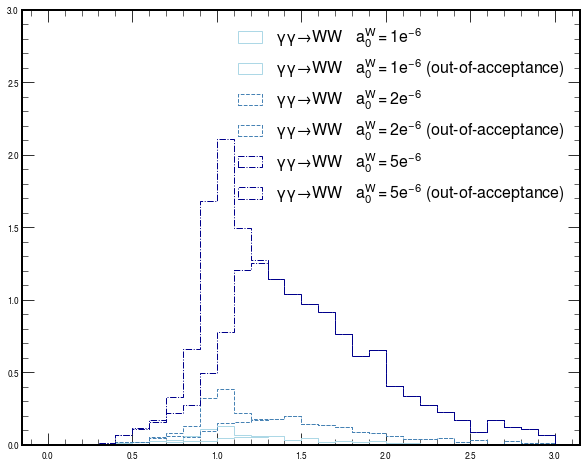

In [74]:
variation__ = "_nom"
var_str__ = {}
var_str__[ "_nom" ] = "_nom_nom"
var_weights__ = "nom"

fig = plt.figure( figsize=(10,8) )

colors_ = [ "lightblue", "steelblue", "darkblue" ]
linestyles_ = [ "-", "--", "-." ]
for idx_, label_ in enumerate( labels_signals ):
    plt.hist( df_signals_protons_multiRP_sig_plus_mix_selected_events_categories_concat[ label_ ][ variation__ ][ "R_MWW_MX" + var_str__[ "_nom" ] ], weights=weights_sig_plus_mix_categories_concat[ label_ ][ var_weights__ ][ variation__ ],
              histtype='step', color=colors_[ idx_ ], linestyle=linestyles_[ idx_ ], label=labels_samples[ label_ ],
              bins=30, range=(0.,3.) )
    plt.hist( df_signals_protons_multiRP_sig_plus_mix_selected_events_categories_concat_skip_sig[ label_ ][ variation__ ][ "R_MWW_MX" + var_str__[ "_nom" ] ], weights=weights_sig_plus_mix_categories_concat_skip_sig[ label_ ][ var_weights__ ][ variation__ ],
              histtype='step', color=colors_[ idx_ ], linestyle=linestyles_[ idx_ ], label=( labels_samples[ label_ ] + " (out-of-acceptance)" ),
              bins=30, range=(0.,3.) )
plt.legend( loc='best', fontsize=16 )
    
plt.ylim( (0.,3.) )

if save_figures:
    plt.savefig( "plots/Ratio_MWW_MX_signals_mix.pdf", bbox_inches='tight' )
    plt.savefig( "plots/Ratio_MWW_MX_signals_mix.png", bbox_inches='tight' )

(0.0, 3.0)

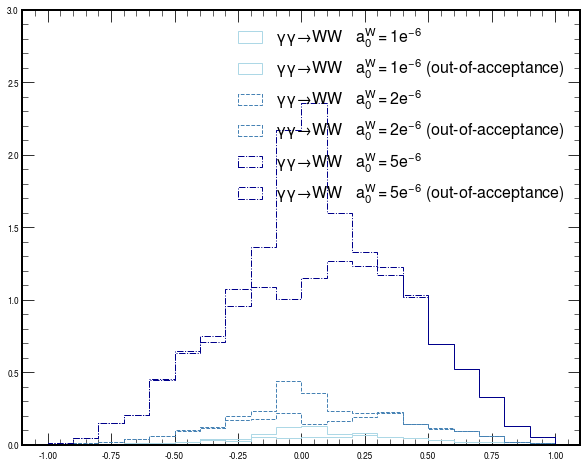

In [75]:
fig = plt.figure( figsize=(10,8) )

colors_ = [ "lightblue", "steelblue", "darkblue" ]
linestyles_ = [ "-", "--", "-." ]
for idx_, label_ in enumerate( labels_signals ):
    plt.hist( df_signals_protons_multiRP_sig_plus_mix_selected_events_categories_concat[ label_ ][ variation__ ][ "Diff_YWW_YX" + var_str__[ "_nom" ] ], weights=weights_sig_plus_mix_categories_concat[ label_ ][ var_weights__ ][ variation__ ],
              histtype='step', color=colors_[ idx_ ], linestyle=linestyles_[ idx_ ], label=labels_samples[ label_ ],
              bins=20, range=(-1.,1.) )
    plt.hist( df_signals_protons_multiRP_sig_plus_mix_selected_events_categories_concat_skip_sig[ label_ ][ variation__ ][ "Diff_YWW_YX" + var_str__[ "_nom" ] ], weights=weights_sig_plus_mix_categories_concat_skip_sig[ label_ ][ var_weights__ ][ variation__ ],
              histtype='step', color=colors_[ idx_ ], linestyle=linestyles_[ idx_ ], label=( labels_samples[ label_ ] + " (out-of-acceptance)" ),
              bins=20, range=(-1.,1.) )
plt.legend( loc='best', fontsize=16 )
    
plt.ylim( (0.,3.) )

2protons_sig
1proton_sig_Arm0
1proton_sig_Arm1
2protons_mix


(0.0, 0.2)

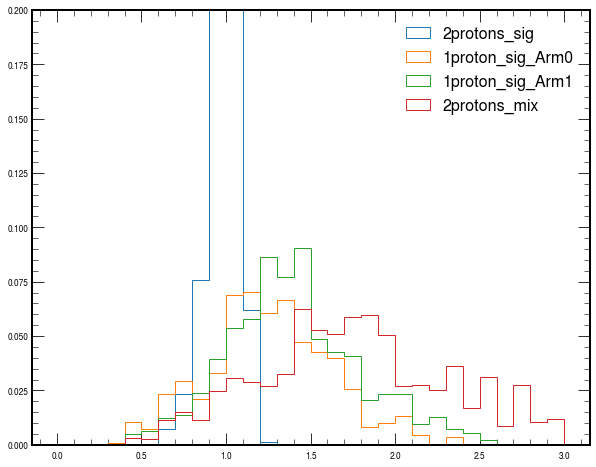

In [76]:
label_ = "GGToWW-AQGC-A0W2e-6"

fig = plt.figure( figsize=(10,8) )
for key_ in df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ]:
    print ( key_ )
    df_selected_events__ = df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ][ key_ ][ variation__ ]
    plt.hist( df_selected_events__[ "R_MWW_MX" + var_str__[ "_nom" ] ], weights=weights_sig_plus_mix_categories[ label_ ][ var_weights__ ][ key_ ][ variation__ ],
              histtype='step', label=key_,
              bins=30, range=(0.,3.) )
plt.legend( loc='best', fontsize=16 )
plt.ylim( 0., 0.2 )
# plt.ylim( 0., 0.5 )
# plt.ylim( 0., 3. )

2protons_sig
1proton_sig_Arm0
1proton_sig_Arm1
2protons_mix


(0.0, 0.2)

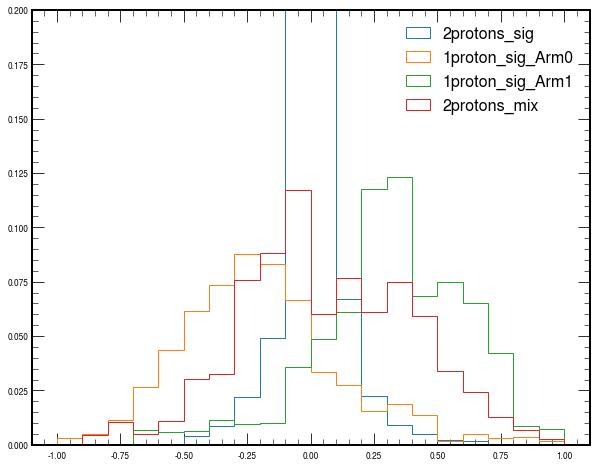

In [77]:
# label_ = "GGToWW-AQGC-A0W5e-6"

fig = plt.figure( figsize=(10,8) )
for key_ in df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ]:
    print ( key_ )
    df_selected_events__ = df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ][ key_ ][ variation__ ]
    plt.hist( df_selected_events__[ "Diff_YWW_YX" + var_str__[ "_nom" ] ], weights=weights_sig_plus_mix_categories[ label_ ][ var_weights__ ][ key_ ][ variation__ ],
              histtype='step', label=key_,
              bins=20, range=(-1.,1.) )
plt.legend( loc='best', fontsize=16 )
plt.ylim( 0., 0.2 )
# plt.ylim( 0., 0.5 )
# plt.ylim( 0., 3. )

In [78]:
# label_ = "GGToWW-AQGC-A0W5e-6"
# fig = plt.figure( figsize=(12,10) )
# for key_ in df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events[ label_ ]:
#     print ( key_ )
#     df_selected_events__ = df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events[ label_ ][ key_ ]
#     plt.hist( df_selected_events__[ "ratioMWW_MX" ], weights=weights_out_acceptance_misreconstructed[ label_ ][ key_ ],
#               histtype='step', label=key_,
#               bins=20, range=(0.,2.) )
# plt.legend( loc='best', fontsize=16 )

In [79]:
# fig = plt.figure( figsize=(10,8) )

# colors_ = [ "lightblue", "steelblue", "darkblue" ]
# linestyles_ = [ "-", "--", "-." ]
# for idx_, label_ in enumerate( labels_signals ):
#     plt.hist( df_signals_protons_multiRP_events[ label_ ][ "ratioMWW_MX" ], weights=weights_mc[ label_ ],
#               histtype='step', color=colors_[ idx_ ], linestyle=linestyles_[ idx_ ], label=labels_samples[ label_ ],
#               bins=30, range=(0.,3.) )
#     plt.hist( df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events_concat[ label_ ][ "ratioMWW_MX" ],
#               weights=weights_out_acceptance_misreconstructed_concat[ label_ ],
#               histtype='step', color=colors_[ idx_ ], linestyle=linestyles_[ idx_ ], label=( labels_samples[ label_ ] + " (out-of-acceptance)" ),
#               bins=30, range=(0.,3.) )


# plt.legend( loc='best', fontsize=16 )
    
# plt.ylim( (0.,3.) )

# if save_figures:
#     plt.savefig( "plots/Ratio_MWW_MX_signals.pdf", bbox_inches='tight' )
#     plt.savefig( "plots/Ratio_MWW_MX_signals.png", bbox_inches='tight' )

<ipython-input-80-9407e7634d14>:23: RuntimeWarning: invalid value encountered in true_divide
  axes[1,0].hist( bin_centers__, weights=( ( counts__ - counts_nom__ ) / counts_nom__ ),
<ipython-input-80-9407e7634d14>:23: RuntimeWarning: invalid value encountered in true_divide
  axes[1,0].hist( bin_centers__, weights=( ( counts__ - counts_nom__ ) / counts_nom__ ),


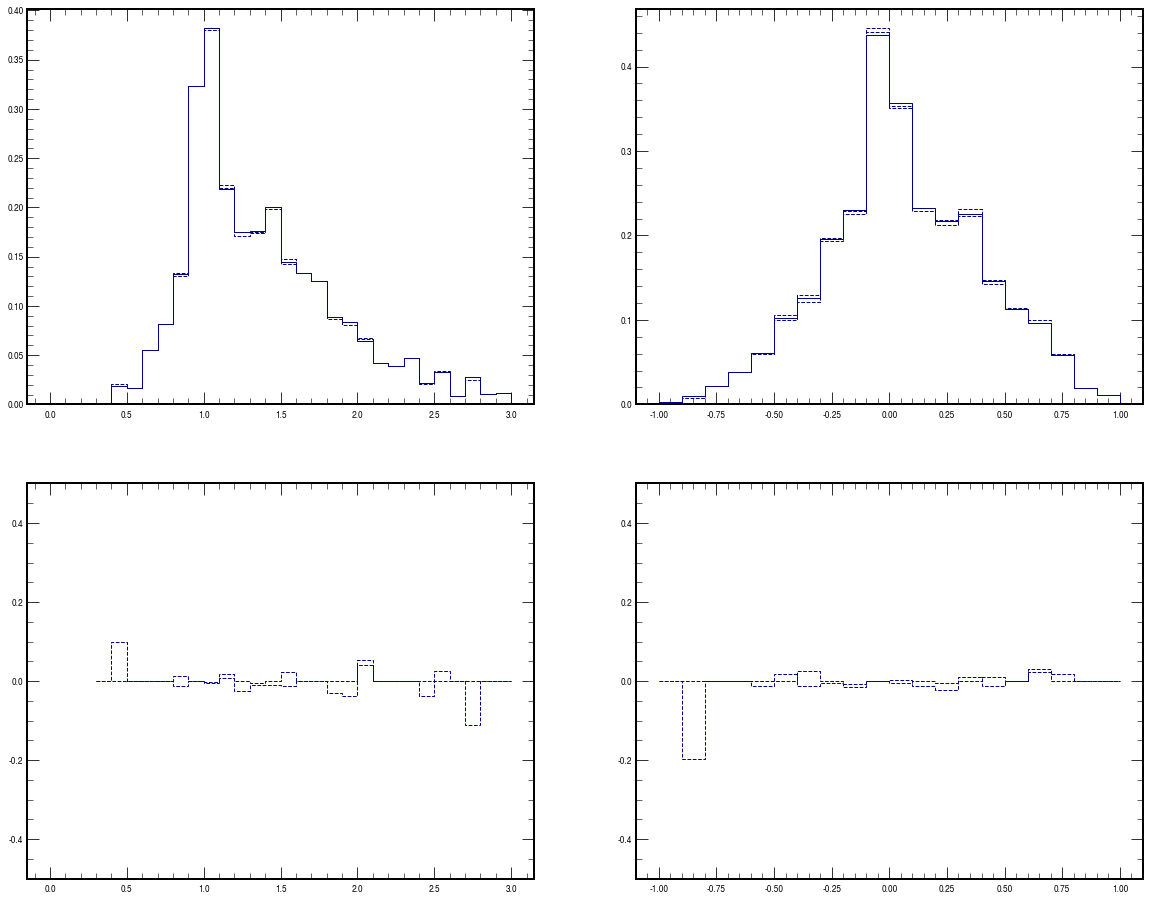

In [80]:
variations_ = [ "_nom", "_jes_up", "_jes_dw" ]
var_str__ = {}
for key_ in variations_:
    var_str__[ key_ ] = key_
# var_str__[ "_nom" ] = "_nom_nom"

fig, axes = plt.subplots( 2, 2, figsize=(2*10,2*8) )

color_ = "darkblue"
linestyles_ = [ "-", "--", "--" ]
for idx_, variation__ in enumerate( variations_ ):
    arr__ = df_signals_protons_multiRP_sig_plus_mix_selected_events_categories_concat[ label_ ][ variation__ ][ "R_MWW_MX" + var_str__[ variation__ ] ]
    weights__ = weights_sig_plus_mix_categories_concat[ label_ ][ "nom" ][ variation__ ]
    counts__, bins__, _ = axes[0,0].hist( arr__, weights=weights__,
                                                 histtype='step', color=color_, linestyle=linestyles_[ idx_ ], label=variation__,
                                                 bins=30, range=(0.,3.) )
    weights_nom__ = None
    if variation__ != "_nom":
        arr_nom__ = df_signals_protons_multiRP_sig_plus_mix_selected_events_categories_concat[ label_ ][ "_nom" ][ "R_MWW_MX" + var_str__[ "_nom" ] ]
        weights_nom__ = weights_sig_plus_mix_categories_concat[ label_ ][ "nom" ][ "_nom" ]
        counts_nom__, bins_nom__ = np.histogram( arr_nom__, weights=weights_nom__, bins=30, range=(0.,3.) )
        bin_centers__ = ( bins__[:-1] + bins__[1:] ) / 2
        axes[1,0].hist( bin_centers__, weights=( ( counts__ - counts_nom__ ) / counts_nom__ ),
                                       histtype='step', color=color_, linestyle=linestyles_[ idx_ ], label=variation__,
                                       bins=30, range=(0.,3.) )
        axes[1,0].set_ylim( -0.50, 0.50 )
        
    arr__ = df_signals_protons_multiRP_sig_plus_mix_selected_events_categories_concat[ label_ ][ variation__ ][ "Diff_YWW_YX" + var_str__[ variation__ ] ]
    counts__, bins__, _ = axes[0,1].hist( arr__, weights=weights__,
                                                 histtype='step', color=color_, linestyle=linestyles_[ idx_ ], label=variation__,
                                                 bins=20, range=(-1.,1.) )
    if variation__ != "_nom":
        arr_nom__ = df_signals_protons_multiRP_sig_plus_mix_selected_events_categories_concat[ label_ ][ "_nom" ][ "Diff_YWW_YX" + var_str__[ variation__ ] ]
        counts_nom__, bins_nom__ = np.histogram( arr_nom__, weights=weights_nom__, bins=20, range=(-1.,1.) )
        bin_centers__ = ( bins__[:-1] + bins__[1:] ) / 2
        axes[1,1].hist( bin_centers__, weights=( ( counts__ - counts_nom__ ) / counts_nom__ ),
                                       histtype='step', color=color_, linestyle=linestyles_[ idx_ ], label=variation__,
                                       bins=20, range=(-1.,1.) )
        axes[1,1].set_ylim( -0.50, 0.50 )
        

In [81]:
sum_weights_cut = {}
sum_weights_squared_cut = {}
sum_weights_cut_max = {}
sum_weights_cut_min = {}
for label_ in labels_signals:
    print ( label_ )
    sum_weights_cut_max_ = None
    sum_weights_cut_min_ = None
    for idx_, variation__ in enumerate( variations_ ):
        if variation__ != "_nom":
            print ( variation__ )
            df__ = df_signals_protons_multiRP_sig_plus_mix_selected_events_categories_concat[ label_ ][ variation__ ]
            weights__ = weights_sig_plus_mix_categories_concat[ label_ ][ "nom" ][ variation__ ]
            arr_R_MWW_MX__ = df__.loc[ :, "R_MWW_MX" + variation__ ]
            arr_Diff_YWW_YX__ = df__.loc[ :, "Diff_YWW_YX" + variation__ ]
            msk__ = ( ( np.abs( arr_Diff_YWW_YX__ ) <= 1.0 ) & ( arr_R_MWW_MX__ >= 0.80 ) )
            sum_weights_cut__ = np.sum( weights__.loc[ msk__ ] )
            if sum_weights_cut_max_ is None:
                sum_weights_cut_max_ = sum_weights_cut__
            if sum_weights_cut_min_ is None:
                sum_weights_cut_min_ = sum_weights_cut__
            if sum_weights_cut__ > sum_weights_cut_max_:
                sum_weights_cut_max_ = sum_weights_cut__
            if sum_weights_cut__ < sum_weights_cut_min_:
                sum_weights_cut_min_ = sum_weights_cut__

    df__ = df_signals_protons_multiRP_sig_plus_mix_selected_events_categories_concat[ label_ ][ "_nom" ]
    weights__ = weights_sig_plus_mix_categories_concat[ label_ ][ "nom" ][ "_nom" ]
    weights_squared__ = ( weights__ ** 2 )
    arr_R_MWW_MX__ = df__.loc[ :, "R_MWW_MX" + "_nom" ]
    arr_Diff_YWW_YX__ = df__.loc[ :, "Diff_YWW_YX" + "_nom" ]
    msk__ = ( ( np.abs( arr_Diff_YWW_YX__ ) <= 1.0 ) & ( arr_R_MWW_MX__ >= 0.80 ) )
    sum_weights_cut__ = np.sum( weights__.loc[ msk__ ] )
    sum_weights_squared_cut__ = np.sum( weights_squared__.loc[ msk__ ] )
    print ( "{} ± {}".format( sum_weights_cut__, np.sqrt( sum_weights_squared_cut__ ) ) )
    print ( sum_weights_cut_max_ )
    print ( sum_weights_cut_min_ )
    sum_weights_cut[ label_ ] = sum_weights_cut__
    sum_weights_squared_cut[ label_ ] = sum_weights_squared_cut__
    sum_weights_cut_max[ label_ ] = sum_weights_cut_max_
    sum_weights_cut_min[ label_ ] = sum_weights_cut_min_
    
print ( sum_weights_cut )
print ( sum_weights_squared_cut )
print ( sum_weights_cut_max )
print ( sum_weights_cut_min )

GGToWW-AQGC-A0W1e-6
_jes_up
_jes_dw
0.7210138861954447 ± 0.03067937808626465
0.7266969835072503
0.7182824580129841
GGToWW-AQGC-A0W2e-6
_jes_up
_jes_dw
2.5342270776120532 ± 0.07080329505049866
2.5381023435170675
2.523681677616661
GGToWW-AQGC-A0W5e-6
_jes_up
_jes_dw
15.496395130707567 ± 0.26375329651789825
15.58117035034572
15.438236239038563
{'GGToWW-AQGC-A0W1e-6': 0.7210138861954447, 'GGToWW-AQGC-A0W2e-6': 2.5342270776120532, 'GGToWW-AQGC-A0W5e-6': 15.496395130707567}
{'GGToWW-AQGC-A0W1e-6': 0.0009412242397599755, 'GGToWW-AQGC-A0W2e-6': 0.005013106590007969, 'GGToWW-AQGC-A0W5e-6': 0.06956580142405835}
{'GGToWW-AQGC-A0W1e-6': 0.7266969835072503, 'GGToWW-AQGC-A0W2e-6': 2.5381023435170675, 'GGToWW-AQGC-A0W5e-6': 15.58117035034572}
{'GGToWW-AQGC-A0W1e-6': 0.7182824580129841, 'GGToWW-AQGC-A0W2e-6': 2.523681677616661, 'GGToWW-AQGC-A0W5e-6': 15.438236239038563}


In [82]:
sum_weights = {}
for label_ in labels_signals:
    sum_weights[ label_ ] = {}
    sum_weights[ label_ ][ "central" ]        = sum_weights_cut[ label_ ]
    sum_weights[ label_ ][ "stat" ]           = np.sqrt( sum_weights_squared_cut[ label_ ] )
    sum_weights[ label_ ][ "syst_up_jes" ]    = ( sum_weights_cut_max[ label_ ] - sum_weights_cut[ label_ ] )
    sum_weights[ label_ ][ "syst_dw_jes" ]    = ( sum_weights_cut_min[ label_ ] - sum_weights_cut[ label_ ] )
print ( sum_weights )

{'GGToWW-AQGC-A0W1e-6': {'central': 0.7210138861954447, 'stat': 0.03067937808626465, 'syst_up_jes': 0.005683097311805607, 'syst_dw_jes': -0.002731428182460638}, 'GGToWW-AQGC-A0W2e-6': {'central': 2.5342270776120532, 'stat': 0.07080329505049866, 'syst_up_jes': 0.0038752659050143023, 'syst_dw_jes': -0.01054539999539239}, 'GGToWW-AQGC-A0W5e-6': {'central': 15.496395130707567, 'stat': 0.26375329651789825, 'syst_up_jes': 0.08477521963815349, 'syst_dw_jes': -0.05815889166900412}}


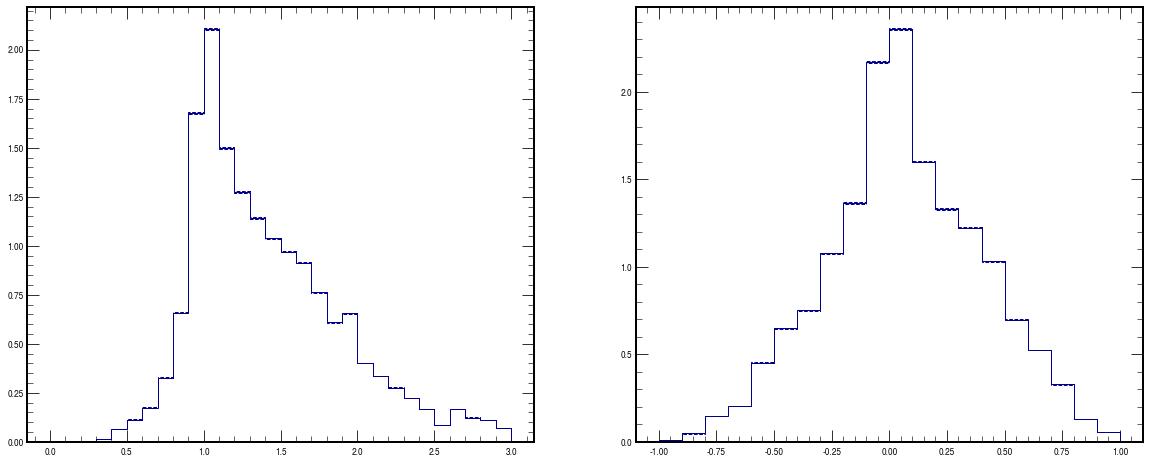

In [83]:
variations_weights_ = [ "nom", "sf_muon_id_up", "sf_muon_id_dw" ]
variation__ = "_nom"

fig, axes = plt.subplots( 1, 2, figsize=(2*10,8) )

color_ = "darkblue"
linestyles_ = [ "-", "--", "--" ]
for idx_, var_weights__ in enumerate( variations_weights_ ):
    axes[0].hist( df_signals_protons_multiRP_sig_plus_mix_selected_events_categories_concat[ label_ ][ variation__ ][ "R_MWW_MX" + var_str__[ variation__ ] ],
                  weights=weights_sig_plus_mix_categories_concat[ label_ ][ var_weights__ ][ variation__ ],
                  histtype='step', color=color_, linestyle=linestyles_[ idx_ ], label=var_weights__,
                  bins=30, range=(0.,3.) )
    axes[1].hist( df_signals_protons_multiRP_sig_plus_mix_selected_events_categories_concat[ label_ ][ variation__ ][ "Diff_YWW_YX" + var_str__[ variation__ ] ],
                  weights=weights_sig_plus_mix_categories_concat[ label_ ][ var_weights__ ][ variation__ ],
                  histtype='step', color=color_, linestyle=linestyles_[ idx_ ], label=var_weights__,
                  bins=20, range=(-1.,1.) )

In [84]:
sum_weights_cut = {}
sum_weights_squared_cut = {}
sum_weights_cut_max = {}
sum_weights_cut_min = {}
for label_ in labels_signals:
    print ( label_ )
    sum_weights_cut_max_ = None
    sum_weights_cut_min_ = None
    for idx_, var_weights__ in enumerate( variations_weights_ ):
        if var_weights__ != "nom":
            print ( var_weights__ )
            df__ = df_signals_protons_multiRP_sig_plus_mix_selected_events_categories_concat[ label_ ][ "_nom" ]
            weights__ = weights_sig_plus_mix_categories_concat[ label_ ][ var_weights__ ][ "_nom" ]
            print ( np.mean( weights__ ) )
            arr_R_MWW_MX__ = df__.loc[ :, "R_MWW_MX" + "_nom" ]
            arr_Diff_YWW_YX__ = df__.loc[ :, "Diff_YWW_YX" + "_nom" ]
            msk__ = ( ( np.abs( arr_Diff_YWW_YX__ ) <= 1.0 ) & ( arr_R_MWW_MX__ >= 0.80 ) )
            sum_weights_cut__ = np.sum( weights__.loc[ msk__ ] )
            if sum_weights_cut_max_ is None:
                sum_weights_cut_max_ = sum_weights_cut__
            if sum_weights_cut_min_ is None:
                sum_weights_cut_min_ = sum_weights_cut__
            if sum_weights_cut__ > sum_weights_cut_max_:
                sum_weights_cut_max_ = sum_weights_cut__
            if sum_weights_cut__ < sum_weights_cut_min_:
                sum_weights_cut_min_ = sum_weights_cut__

    df__ = df_signals_protons_multiRP_sig_plus_mix_selected_events_categories_concat[ label_ ][ "_nom" ]
    weights__ = weights_sig_plus_mix_categories_concat[ label_ ][ "nom" ][ "_nom" ]
    print ( np.mean( weights__ ) )
    weights_squared__ = ( weights__ ** 2 )
    arr_R_MWW_MX__ = df__.loc[ :, "R_MWW_MX" + "_nom" ]
    arr_Diff_YWW_YX__ = df__.loc[ :, "Diff_YWW_YX" + "_nom" ]
    msk__ = ( ( np.abs( arr_Diff_YWW_YX__ ) <= 1.0 ) & ( arr_R_MWW_MX__ >= 0.80 ) )
    sum_weights_cut__ = np.sum( weights__.loc[ msk__ ] )
    sum_weights_squared_cut__ = np.sum( weights_squared__.loc[ msk__ ] )
    print ( "{} ± {}".format( sum_weights_cut__, np.sqrt( sum_weights_squared_cut__ ) ) )
    print ( sum_weights_cut_max_ )
    print ( sum_weights_cut_min_ )
    sum_weights_cut[ label_ ] = sum_weights_cut__
    sum_weights_squared_cut[ label_ ] = sum_weights_squared_cut__
    sum_weights_cut_max[ label_ ] = sum_weights_cut_max_
    sum_weights_cut_min[ label_ ] = sum_weights_cut_min_
    
print ( sum_weights_cut )
print ( sum_weights_squared_cut )
print ( sum_weights_cut_max )
print ( sum_weights_cut_min )

GGToWW-AQGC-A0W1e-6
sf_muon_id_up
0.0009817441740815989
sf_muon_id_dw
0.0009750695620266775
0.0009784068680541384
0.7210138861954447 ± 0.03067937808626465
0.7234799106040188
0.7185478617868704
GGToWW-AQGC-A0W2e-6
sf_muon_id_up
0.0014400893891474977
sf_muon_id_dw
0.0014315100727784647
0.0014357997309629813
2.5342270776120532 ± 0.07080329505049866
2.541817844242551
2.526636310981556
GGToWW-AQGC-A0W5e-6
sf_muon_id_up
0.0032969001895028706
sf_muon_id_dw
0.003276584023963304
0.0032867421067330873
15.496395130707567 ± 0.26375329651789825
15.544031835658608
15.448758425756525
{'GGToWW-AQGC-A0W1e-6': 0.7210138861954447, 'GGToWW-AQGC-A0W2e-6': 2.5342270776120532, 'GGToWW-AQGC-A0W5e-6': 15.496395130707567}
{'GGToWW-AQGC-A0W1e-6': 0.0009412242397599755, 'GGToWW-AQGC-A0W2e-6': 0.005013106590007969, 'GGToWW-AQGC-A0W5e-6': 0.06956580142405835}
{'GGToWW-AQGC-A0W1e-6': 0.7234799106040188, 'GGToWW-AQGC-A0W2e-6': 2.541817844242551, 'GGToWW-AQGC-A0W5e-6': 15.544031835658608}
{'GGToWW-AQGC-A0W1e-6': 0.718

In [85]:
for label_ in labels_signals:
    sum_weights[ label_ ][ "syst_up_sf_muon_id" ]    = ( sum_weights_cut_max[ label_ ] - sum_weights_cut[ label_ ] )
    sum_weights[ label_ ][ "syst_dw_sf_muon_id" ]    = ( sum_weights_cut_min[ label_ ] - sum_weights_cut[ label_ ] )
print ( sum_weights )

{'GGToWW-AQGC-A0W1e-6': {'central': 0.7210138861954447, 'stat': 0.03067937808626465, 'syst_up_jes': 0.005683097311805607, 'syst_dw_jes': -0.002731428182460638, 'syst_up_sf_muon_id': 0.00246602440857413, 'syst_dw_sf_muon_id': -0.002466024408574352}, 'GGToWW-AQGC-A0W2e-6': {'central': 2.5342270776120532, 'stat': 0.07080329505049866, 'syst_up_jes': 0.0038752659050143023, 'syst_dw_jes': -0.01054539999539239, 'syst_up_sf_muon_id': 0.007590766630497736, 'syst_dw_sf_muon_id': -0.007590766630497292}, 'GGToWW-AQGC-A0W5e-6': {'central': 15.496395130707567, 'stat': 0.26375329651789825, 'syst_up_jes': 0.08477521963815349, 'syst_dw_jes': -0.05815889166900412, 'syst_up_sf_muon_id': 0.04763670495104044, 'syst_dw_sf_muon_id': -0.04763670495104222}}


R_MWW_MX
_nom_nom
_nom_p100
_nom_m100
_p100_nom
_p100_p100
_p100_m100
_m100_nom
_m100_p100
_m100_m100
[0.34242329 1.76024373 3.86071921 3.61585409 2.30031871 1.88323526
 1.54223258 1.12572252]
[0.26485637 0.68041796 2.79738195 2.57607611 2.09456972 1.81800458
 1.26799071 0.90654976]
0       0.189097
1       0.890878
2       3.171641
3     -79.631612
4      -5.566605
5      -3.667604
6      -3.078445
7      -2.844096
8      -2.769860
9      -2.795678
10     -2.904020
11     -3.098921
12     -3.403915
13     -3.872228
14     -4.619888
15     -5.933256
16     -8.734526
17    -18.470111
18     78.299881
19     11.542625
20      5.954289
21      3.886294
22      2.813134
23      2.158422
24      1.718745
25      1.404025
26      1.168263
27      0.985531
28      0.840109
29      0.721920
         ...    
170     0.121710
171     0.125601
172     0.129317
173     0.132835
174     0.136133
175     0.139184
176     0.141965
177     0.144448
178     0.146605
179     0.148408
180     0.149828
18

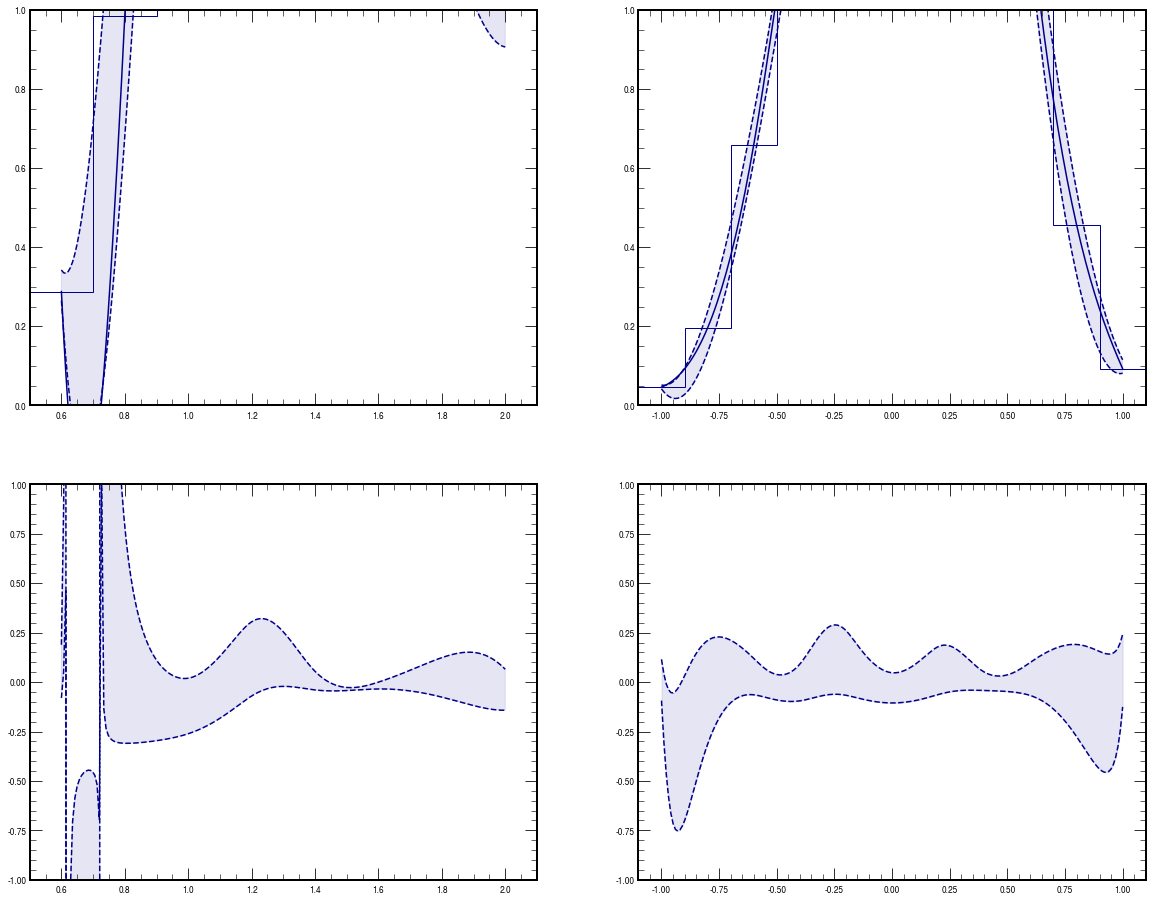

In [86]:
from scipy.interpolate import make_interp_spline

relative_uncertainty_ = True

# labels_xi_ = [ "_nom", "_p10", "_p30", "_p60", "_p100", "_m10", "_m30", "_m60", "_m100" ]
labels_xi_ = [ "_nom", "_p100", "_m100" ]
variations_ = []
for label0_ in labels_xi_:
    for label1_ in labels_xi_:
        variations_.append( label0_ + label1_ )

sel_str__ = {}
for key_ in variations_:
    sel_str__[ key_ ] = "_nom"

var_weights__ = "nom"
    
fig, axes = plt.subplots( 2, 2, figsize=(2*10,2*8) )

vars_ = {}
vars_[ "R_MWW_MX" ] = {}
# vars_[ "R_MWW_MX" ][ "bins" ]  = 30
# vars_[ "R_MWW_MX" ][ "range" ] = (0.,3.)
vars_[ "R_MWW_MX" ][ "bins" ]  = 0.5 + 0.2 * np.arange( 9 )
vars_[ "R_MWW_MX" ][ "range" ] = None
# vars_[ "R_MWW_MX" ][ "xlim" ]  = (0.5,2.)
vars_[ "R_MWW_MX" ][ "xlim" ]  = ( 0.5, 2.1 )
vars_[ "Diff_YWW_YX" ] = {}
# vars_[ "Diff_YWW_YX" ][ "bins" ]  = 20
# vars_[ "Diff_YWW_YX" ][ "range" ] = (-1.,1.)
vars_[ "Diff_YWW_YX" ][ "bins" ]  = -1.1 + 0.2 * np.arange( 12 )
vars_[ "Diff_YWW_YX" ][ "range" ] = None
# vars_[ "Diff_YWW_YX" ][ "xlim" ]  = (-1.,1.)
vars_[ "Diff_YWW_YX" ][ "xlim" ]  = ( -1.1, 1.1 )

# ylim_ = (0.,0.2)
# ylim_ = (0.,0.5)
ylim_ = (0.,1.)
# ylim_ = (0.,3.)

color_ = "darkblue"
# linestyles_ = [ "-", "--", "--", "-.", "-." ]

idx_col_ = 0
max_ = {}
min_ = {}
spline_nom_ = {}
spline_max_ = {}
spline_min_ = {}
spline_nom_arr_ = {}
spline_max_arr_ = {}
spline_min_arr_ = {}
for var__ in vars_:
    print ( var__ )
    max_[ var__ ] = None
    min_[ var__ ] = None
    for idx_, variation__ in enumerate( variations_ ):
    #     counts_, bins_, _ = plt.hist( df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ][ sel_str__[ variation__ ] ][ "R_MWW_MX" + variation__ ], weights=weights_sig_plus_mix_2protons[ label_ ][ sel_str__[ variation__ ] ],
    #                                   histtype='step', color=color_, linestyle=linestyles_[ idx_ ], label=variation__,
    #                                   bins=30, range=(0.,3.) )
    #     counts_, bins_ = np.histogram( df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ][ sel_str__[ variation__ ] ][ "R_MWW_MX" + variation__ ], weights=weights_sig_plus_mix_2protons[ label_ ][ sel_str__[ variation__ ] ], bins=30, range=(0.,3.) )
    #     bin_centers_ = ( bins_[:-1] + bins_[1:] ) / 2
    #     plt.plot( bin_centers_, counts_, color=color_, linestyle=linestyles_[ idx_ ] )
        if variation__ != "_nom":
            print ( variation__ )
            arr__ = df_signals_protons_multiRP_sig_plus_mix_selected_events_categories_concat[ label_ ][ sel_str__[ variation__ ] ][ var__ + variation__ ]
            weights__ = weights_sig_plus_mix_categories_concat[ label_ ][ var_weights__ ][ sel_str__[ variation__ ] ]
            counts_, bins_ = np.histogram( arr__, weights=weights__, bins=vars_[ var__ ][ "bins" ], range=vars_[ var__ ][ "range" ] )
#             counts_rebin_ = counts_[::2] + counts_[1::2]
#             bins_rebin_ = bins_[::2]
            
            if max_[ var__ ] is None: max_[ var__ ] = counts_.copy()
            if min_[ var__ ] is None: min_[ var__ ] = counts_.copy()
            msk__ = counts_ > max_[ var__ ]
            max_[ var__ ][ msk__ ] = counts_[ msk__ ]
            msk__ = counts_ < min_[ var__ ]
            min_[ var__ ][ msk__ ] = counts_[ msk__ ]

    print ( max_[ var__ ] )
    print ( min_[ var__ ] )
    counts_, bins_, _ = axes[0,idx_col_].hist( df_signals_protons_multiRP_sig_plus_mix_selected_events_categories_concat[ label_ ][ "_nom" ][ var__ + "_nom" ],
                                               weights=weights_sig_plus_mix_categories_concat[ label_ ][ var_weights__ ][ "_nom" ],
                                               histtype='step', color=color_, linestyle="-", label="_nom",
                                               bins=vars_[ var__ ][ "bins" ], range=vars_[ var__ ][ "range" ] )
    bin_centers_ = ( bins_[:-1] + bins_[1:] ) / 2
    # plt.plot( bin_centers_, counts_, color=color_, linestyle="-" )
    # plt.plot( bin_centers_, max_, color=color_, linestyle="--" )
    # plt.plot( bin_centers_, min_, color=color_, linestyle="--" )
#     bins_rebin_ = bins_[::2]
#     bins_rebin_ = bins_
#     bin_centers_rebin_ = ( bins_rebin_[:-1] + bins_rebin_[1:] ) / 2
    
    spline_nom_[ var__ ] = make_interp_spline( bin_centers_, counts_, k=3 )
    spline_max_[ var__ ] = make_interp_spline( bin_centers_, max_[ var__ ], k=3 )
    spline_min_[ var__ ] = make_interp_spline( bin_centers_, min_[ var__ ], k=3 )
    x_plot__ = np.linspace( bin_centers_[0], bin_centers_[-1], 200 )
#     rebin_factor_ = 1
    spline_nom_arr_[ var__ ] = spline_nom_[ var__ ]( x_plot__ )
    spline_max_arr_[ var__ ] = spline_max_[ var__ ]( x_plot__ )
    spline_min_arr_[ var__ ] = spline_min_[ var__ ]( x_plot__ )
    axes[0,idx_col_].plot( x_plot__, spline_nom_arr_[ var__ ], color=color_, linestyle="-" )
    axes[0,idx_col_].plot( x_plot__, spline_max_arr_[ var__ ], color=color_, linestyle="--" )
    axes[0,idx_col_].plot( x_plot__, spline_min_arr_[ var__ ], color=color_, linestyle="--" )
    axes[0,idx_col_].fill_between( x_plot__, spline_min_arr_[ var__ ], spline_max_arr_[ var__ ], color=color_, alpha=0.10 )
#     axes[0,idx_col_].set_xlim( 0.5, 2. )
    axes[0,idx_col_].set_xlim( vars_[ var__ ][ "xlim" ] )
#     axes[0,idx_col_].set_ylim( 0., 1. )
#     axes[0,idx_col_].set_ylim( 0., 3. )
    axes[0,idx_col_].set_ylim( ylim_ )

    if relative_uncertainty_:
        ratio_max_ = ( spline_max_arr_[ var__ ] - spline_nom_arr_[ var__ ] ) / spline_nom_arr_[ var__ ]
        ratio_min_ = ( spline_min_arr_[ var__ ] - spline_nom_arr_[ var__ ] ) / spline_nom_arr_[ var__ ]
        ratio_max_sel_ = pd.Series( ratio_max_ )
        ratio_max_sel_ = ratio_max_sel_[ ( x_plot__ >= 0.5 ) & ( x_plot__ <= 2.0 ) ]
        ratio_min_sel_ = pd.Series( ratio_min_ )
        ratio_min_sel_ = ratio_min_sel_[ ( x_plot__ >= 0.5 ) & ( x_plot__ <= 2.0 ) ]
        print ( ratio_max_sel_, ratio_max_sel_.mean() )
        print ( ratio_min_sel_, ratio_min_sel_.dropna().mean() )
        axes[1,idx_col_].plot( x_plot__, ratio_max_, color=color_, linestyle="--" )
        axes[1,idx_col_].plot( x_plot__, ratio_min_, color=color_, linestyle="--" )
        axes[1,idx_col_].fill_between( x_plot__, ratio_min_, ratio_max_, color=color_, alpha=0.10 )
    else:
        diff_max_ = ( spline_max_arr_[ var__ ] - spline_nom_arr_[ var__ ] )
        diff_min_ = ( spline_min_arr_[ var__ ] - spline_nom_arr_[ var__ ] )
        axes[1,idx_col_].plot( x_plot__, diff_max_, color=color_, linestyle="--" )
        axes[1,idx_col_].plot( x_plot__, diff_min_, color=color_, linestyle="--" )
        axes[1,idx_col_].fill_between( x_plot__, diff_min_, diff_max_, color=color_, alpha=0.10 )
#     axes[1,idx_col_].set_xlim( 0.5, 2. )
    axes[1,idx_col_].set_xlim( vars_[ var__ ][ "xlim" ] )
    axes[1,idx_col_].set_ylim( -1., 1. )
    idx_col_ += 1

In [87]:
sum_weights_cut = {}
sum_weights_squared_cut = {}
sum_weights_cut_max = {}
sum_weights_cut_min = {}
for label_ in labels_signals:
    print ( label_ )
    sum_weights_cut_max_ = None
    sum_weights_cut_min_ = None
    for idx_, variation__ in enumerate( variations_ ):
        if variation__ != "_nom":
            print ( variation__ )
            df__ = df_signals_protons_multiRP_sig_plus_mix_selected_events_categories_concat[ label_ ][ sel_str__[ variation__ ] ]
            weights__ = weights_sig_plus_mix_categories_concat[ label_ ][ "nom" ][ sel_str__[ variation__ ] ]
            arr_R_MWW_MX__ = df__.loc[ :, "R_MWW_MX" + variation__ ]
            arr_Diff_YWW_YX__ = df__.loc[ :, "Diff_YWW_YX" + variation__ ]
            msk__ = ( ( np.abs( arr_Diff_YWW_YX__ ) <= 1.0 ) & ( arr_R_MWW_MX__ >= 0.80 ) )
            sum_weights_cut__ = np.sum( weights__.loc[ msk__ ] )
            if sum_weights_cut_max_ is None:
                sum_weights_cut_max_ = sum_weights_cut__
            if sum_weights_cut_min_ is None:
                sum_weights_cut_min_ = sum_weights_cut__
            if sum_weights_cut__ > sum_weights_cut_max_:
                sum_weights_cut_max_ = sum_weights_cut__
            if sum_weights_cut__ < sum_weights_cut_min_:
                sum_weights_cut_min_ = sum_weights_cut__

    df__ = df_signals_protons_multiRP_sig_plus_mix_selected_events_categories_concat[ label_ ][ "_nom" ]
    weights__ = weights_sig_plus_mix_categories_concat[ label_ ][ "nom" ][ "_nom" ]
    weights_squared__ = ( weights__ ** 2 )
    arr_R_MWW_MX__ = df__.loc[ :, "R_MWW_MX" + "_nom" ]
    arr_Diff_YWW_YX__ = df__.loc[ :, "Diff_YWW_YX" + "_nom" ]
    msk__ = ( ( np.abs( arr_Diff_YWW_YX__ ) <= 1.0 ) & ( arr_R_MWW_MX__ >= 0.80 ) )
    sum_weights_cut__ = np.sum( weights__.loc[ msk__ ] )
    sum_weights_squared_cut__ = np.sum( weights_squared__.loc[ msk__ ] )
    print ( "{} ± {}".format( sum_weights_cut__, np.sqrt( sum_weights_squared_cut__ ) ) )
    print ( sum_weights_cut_max_ )
    print ( sum_weights_cut_min_ )
    sum_weights_cut[ label_ ] = sum_weights_cut__
    sum_weights_squared_cut[ label_ ] = sum_weights_squared_cut__
    sum_weights_cut_max[ label_ ] = sum_weights_cut_max_
    sum_weights_cut_min[ label_ ] = sum_weights_cut_min_
    
print ( sum_weights_cut )
print ( sum_weights_squared_cut )
print ( sum_weights_cut_max )
print ( sum_weights_cut_min )

GGToWW-AQGC-A0W1e-6
_nom_nom
_nom_p100
_nom_m100
_p100_nom
_p100_p100
_p100_m100
_m100_nom
_m100_p100
_m100_m100
0.7210138861954447 ± 0.03067937808626465
0.7356360005359186
0.7023713127137589
GGToWW-AQGC-A0W2e-6
_nom_nom
_nom_p100
_nom_m100
_p100_nom
_p100_p100
_p100_m100
_m100_nom
_m100_p100
_m100_m100
2.5342270776120532 ± 0.07080329505049866
2.553005518412036
2.5049535863856605
GGToWW-AQGC-A0W5e-6
_nom_nom
_nom_p100
_nom_m100
_p100_nom
_p100_p100
_p100_m100
_m100_nom
_m100_p100
_m100_m100
15.496395130707567 ± 0.26375329651789825
15.655223388041943
15.242102421048997
{'GGToWW-AQGC-A0W1e-6': 0.7210138861954447, 'GGToWW-AQGC-A0W2e-6': 2.5342270776120532, 'GGToWW-AQGC-A0W5e-6': 15.496395130707567}
{'GGToWW-AQGC-A0W1e-6': 0.0009412242397599755, 'GGToWW-AQGC-A0W2e-6': 0.005013106590007969, 'GGToWW-AQGC-A0W5e-6': 0.06956580142405835}
{'GGToWW-AQGC-A0W1e-6': 0.7356360005359186, 'GGToWW-AQGC-A0W2e-6': 2.553005518412036, 'GGToWW-AQGC-A0W5e-6': 15.655223388041943}
{'GGToWW-AQGC-A0W1e-6': 0.7023

In [88]:
for label_ in labels_signals:
    sum_weights[ label_ ][ "syst_up_proton_scale" ]    = ( sum_weights_cut_max[ label_ ] - sum_weights_cut[ label_ ] )
    sum_weights[ label_ ][ "syst_dw_proton_scale" ]    = ( sum_weights_cut_min[ label_ ] - sum_weights_cut[ label_ ] )
print ( sum_weights )

{'GGToWW-AQGC-A0W1e-6': {'central': 0.7210138861954447, 'stat': 0.03067937808626465, 'syst_up_jes': 0.005683097311805607, 'syst_dw_jes': -0.002731428182460638, 'syst_up_sf_muon_id': 0.00246602440857413, 'syst_dw_sf_muon_id': -0.002466024408574352, 'syst_up_proton_scale': 0.01462211434047389, 'syst_dw_proton_scale': -0.018642573481685853}, 'GGToWW-AQGC-A0W2e-6': {'central': 2.5342270776120532, 'stat': 0.07080329505049866, 'syst_up_jes': 0.0038752659050143023, 'syst_dw_jes': -0.01054539999539239, 'syst_up_sf_muon_id': 0.007590766630497736, 'syst_dw_sf_muon_id': -0.007590766630497292, 'syst_up_proton_scale': 0.01877844079998292, 'syst_dw_proton_scale': -0.029273491226392778}, 'GGToWW-AQGC-A0W5e-6': {'central': 15.496395130707567, 'stat': 0.26375329651789825, 'syst_up_jes': 0.08477521963815349, 'syst_dw_jes': -0.05815889166900412, 'syst_up_sf_muon_id': 0.04763670495104044, 'syst_dw_sf_muon_id': -0.04763670495104222, 'syst_up_proton_scale': 0.15882825733437578, 'syst_dw_proton_scale': -0.25

In [89]:
df__ = pd.DataFrame( sum_weights )
df__

,GGToWW-AQGC-A0W1e-6,GGToWW-AQGC-A0W2e-6,GGToWW-AQGC-A0W5e-6
central,0.721014,2.534227,15.496395
stat,0.030679,0.070803,0.263753
syst_dw_jes,-0.002731,-0.010545,-0.058159
syst_dw_proton_scale,-0.018643,-0.029273,-0.254293
syst_dw_sf_muon_id,-0.002466,-0.007591,-0.047637
syst_up_jes,0.005683,0.003875,0.084775
syst_up_proton_scale,0.014622,0.018778,0.158828
syst_up_sf_muon_id,0.002466,0.007591,0.047637


In [90]:
# arrays = [
#     ["bar","bar","foo","foo","baz","baz"],
#     ["one","one","two","two","one","one"]
# ]
# index = pd.MultiIndex.from_arrays(arrays, names=["first", "second"])
# df = pd.DataFrame( np.arange( 6*2 ).reshape( 6, 2 ), index=index, columns=['A','B'] )
# df_groupby = df.groupby( ["first","second"] )
# for name, group in df_groupby:
#     print ( name )
#     print ( group )
# df_groupby_apply_ = df_groupby.apply( lambda df__: ( df__['A'].iloc[0] * df__['B'].iloc[1] ) )
# print ( df_groupby_apply_ )
# df_nonduplicated = df[ ~df.index.duplicated(keep='first') ]
# df_nonduplicated.loc[ :, 'C' ] = df_groupby_apply_
# df_nonduplicated

In [91]:
from scipy.interpolate import make_interp_spline
np.info( make_interp_spline )

 make_interp_spline(x, y, k=3, t=None, bc_type=None, axis=0,
                    check_finite=True)

Compute the (coefficients of) interpolating B-spline.

Parameters
----------
x : array_like, shape (n,)
    Abscissas.
y : array_like, shape (n, ...)
    Ordinates.
k : int, optional
    B-spline degree. Default is cubic, k=3.
t : array_like, shape (nt + k + 1,), optional.
    Knots.
    The number of knots needs to agree with the number of datapoints and
    the number of derivatives at the edges. Specifically, ``nt - n`` must
    equal ``len(deriv_l) + len(deriv_r)``.
bc_type : 2-tuple or None
    Boundary conditions.
    Default is None, which means choosing the boundary conditions
    automatically. Otherwise, it must be a length-two tuple where the first
    element sets the boundary conditions at ``x[0]`` and the second
    element sets the boundary conditions at ``x[-1]``. Each of these must
    be an iterable of pairs ``(order, value)`` which gives the values of
    derivatives 